<a href="https://colab.research.google.com/github/Dipeshpal/avatar_gen_customized/blob/main/train_gan_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/avatar/pix2pix_model")

os.listdir()

['src_images.npy',
 'tar_images.npy',
 'visualisation',
 'models (1)',
 'intermediate_results',
 'models',
 'train_gan_pix2pix.ipynb']

In [ ]:
!pip install shutup --quiet
!pip install telepot --quiet
!pip install visualkeras --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 8.2 MB/s eta 0:00:00


In [ ]:
import os
from datetime import datetime
import numpy as np
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.models import load_model
from matplotlib import pyplot as plt
import visualkeras
import shutup
import warnings
# Place this before directly or indirectly importing tensorflow
import logging
import shutil

logging.getLogger("tensorflow").setLevel(logging.WARNING)

warnings.filterwarnings("ignore")
shutup.please()


def discriminator_model(image_shape=(256, 256, 3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)  # As described in the original paper

    # source image input
    in_src_image = Input(shape=image_shape)  # Image we want to convert to another image

    # target image input
    in_target_image = Input(shape=image_shape)  # Image we want to generate after training.

    # concatenate images, channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # C64: 4x4 kernel Stride 2x2
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128: 4x4 kernel Stride 2x2
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256: 4x4 kernel Stride 2x2
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer : 4x4 kernel but Stride 1x1
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    # The model is trained with a batch size of one image and Adam opt.
    # with a small learning rate and 0.5 beta.
    # The loss for the discriminator is weighted by 50% for each model update.
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


# Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g


# define the standalone generator model - U-net
def generator_model(image_shape=(256, 256, 3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(image_shape[2], (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(
        d7)  # Modified
    out_image = Activation('tanh')(g)  # Generates images in the range -1 to 1. So change inputs also to -1 to 1
    # define model
    model = Model(in_image, out_image)
    return model


def gan_model(discriminator_model_obj, generator_model_obj, image_shape=(256, 256, 3)):
    # make weights in the discriminator not trainable
    for layer in discriminator_model_obj.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False  # Descriminator layers set to untrainable in the combined GAN but
            # standalone descriminator will be trainable.

    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator
    gen_out = generator_model_obj(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = discriminator_model_obj([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    # Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    # Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'],
                  optimizer=opt, loss_weights=[1, 100])
    return model


class PixGan:
    def __init__(self, image_shape=(256, 256, 3)):
        self.image_shape = image_shape
        print("Loading discriminator_model")
        self.discriminator_model_obj = discriminator_model(self.image_shape)
        print("Loading generator_model")
        self.generator_model_obj = generator_model(self.image_shape)
        print("Loading gan_model")
        self.gan_model_obj = gan_model(self.discriminator_model_obj, self.generator_model_obj,
                                       image_shape=(self.image_shape))
        if not os.path.exists('visualisation'):
            os.makedirs('visualisation')
        visualkeras.layered_view(self.discriminator_model_obj, to_file='visualisation/vis_discriminator_model.png',
                                 legend=True)  # write to disk
        visualkeras.layered_view(self.generator_model_obj, to_file='visualisation/vis_generator_model.png',
                                 legend=True)  # write to disk
        visualkeras.layered_view(self.gan_model_obj, to_file='visualisation/vis_gan_model.png',
                                 legend=True)  # write to disk

        self.model_saved_list = []

        if os.path.exists('models'):
            shutil.rmtree("models", ignore_errors=True)

    # select a batch of random samples, returns images and target
    def generate_real_samples(self, x, y, n_samples, patch_shape):
        # unpack dataset
        trainA, trainB = x, y
        # choose random instances
        ix = randint(0, trainA.shape[0], n_samples)
        # retrieve selected images
        X1, X2 = trainA[ix], trainB[ix]
        # generate 'real' class labels (1)
        y = np.ones((n_samples, patch_shape, patch_shape, 1))
        return [X1, X2], y

    # generate a batch of images, returns images and targets
    def generate_fake_samples(self, samples, patch_shape):
        # generate fake instance
        X = self.generator_model_obj.predict(samples)
        # create 'fake' class labels (0)
        y = np.zeros((len(X), patch_shape, patch_shape, 1))
        return X, y

    def summarize_performance(self, epochs, step, g_model, x, y, callbacks, telegram_callback, n_samples=3):
        # select a sample of input images
        [X_realA, X_realB], _ = self.generate_real_samples(x, y, n_samples, 1)
        # generate a batch of fake samples
        X_fakeB, _ = self.generate_fake_samples(X_realA, 1)
        # scale all pixels from [-1,1] to [0,1]
        X_realA = (X_realA + 1) / 2.0
        X_realB = (X_realB + 1) / 2.0
        X_fakeB = (X_fakeB + 1) / 2.0
        # plot real source images
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + i)
            plt.axis('off')
            plt.imshow(X_realA[i])
        # plot generated target image
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + n_samples + i)
            plt.axis('off')
            plt.imshow(X_fakeB[i])
        # plot real target image
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + n_samples * 2 + i)
            plt.axis('off')
            plt.imshow(X_realB[i])
        if not os.path.exists('models'):
            os.mkdir('models')
        if not os.path.exists('intermediate_results'):
            os.mkdir('intermediate_results')
        # save plot to file
        filename1 = f'intermediate_results/plot_epochs-{epochs + 1}_step={step + 1}.png'
        plt.savefig(filename1)
        plt.close()

        # save the generator model
        filename2 = f'models/model_epochs-{epochs + 1}_step={step + 1}.h5'
        g_model.save(filename2)
        self.model_saved_list.append(f'models/model_epochs-{epochs + 1}_step={step + 1}.h5')

        # save the generator model final
        filename3 = 'models/model_latest.h5'
        g_model.save(filename3)

        print(f'>Saved: {filename1} and {filename2} and {filename3}')

        if telegram_callback is not None:
            telegram_callback(file_path=filename1)

        if len(self.model_saved_list) > 10:
            os.remove(self.model_saved_list[0])
            self.model_saved_list.pop(0)

    def preprocess_data(self, data):
        # load compressed arrays
        # unpack arrays
        X1, X2 = data[0], data[1]
        # scale from [0,255] to [-1,1]
        X1 = (X1 - 127.5) / 127.5
        X2 = (X2 - 127.5) / 127.5
        return [X1, X2]

    def fit(self, x=None, y=None, batch_size=None, epochs=1, verbose="auto",
            callbacks=None, steps_per_epoch=None, auto_preprocess=True,
            telegram_callback=None,
            auto_save_on_step=True,
            auto_save_on_epoch=True,
            auto_save_on_step_interval=10,
            auto_save_on_epoch_interval=1):
        if auto_preprocess:
            x, y = self.preprocess_data([x, y])
        else:
            print("Make sure you preprocess the x, y before passing it to fit method")
            print("It should be scaled from [0,255] to [-1,1]")

        n_patch = self.discriminator_model_obj.output_shape[1]

        if verbose == "auto":
            verbose = True
        else:
            verbose = False

        if batch_size is None:
            raise ValueError("batch_size must be provided")

        if steps_per_epoch is None:
            steps_per_epoch = len(x) // batch_size
        else:
            if steps_per_epoch > len(x):
                raise ValueError(f"steps_per_epoch is greater than the length of the dataset")
            else:
                steps_per_epoch = steps_per_epoch

        if verbose:
            print(f"Pix2Pix Model Training Started at {datetime.now()}")
            print("Length of x: ", len(x))
            print("Length of y: ", len(y))
            print("Number of epochs: ", epochs)
            print("steps_per_epoch: ", steps_per_epoch)

        if telegram_callback is not None:
            msg = f"Pix2Pix Model Training Started at {datetime.now()}\n"
            msg += f"Length of x: {len(x)}\n"
            msg += f"Length of y: {len(y)}\n"
            msg += f"Number of epochs: {epochs}\n"
            msg += f"steps_per_epoch: {steps_per_epoch}\n"
            telegram_callback(msg)

        for ep in range(epochs):
            for i in range(steps_per_epoch):
                # select a batch of real samples
                [X_realA, X_realB], y_real = self.generate_real_samples(x=x, y=y,
                                                                        n_samples=batch_size,
                                                                        patch_shape=n_patch)
                # generate a batch of fake samples
                X_fakeB, y_fake = self.generate_fake_samples(X_realA, n_patch)
                # update discriminator for real samples
                d_loss1 = self.discriminator_model_obj.train_on_batch([X_realA, X_realB], y_real)
                # update discriminator for generated samples
                d_loss2 = self.discriminator_model_obj.train_on_batch([X_realA, X_fakeB], y_fake)
                # update the generator
                g_loss, _, _ = self.gan_model_obj.train_on_batch(X_realA, [y_real, X_realB])

                if verbose:
                    # summarize performance
                    msg = f'Epoch {ep + 1}/{epochs}\n' \
                          f' {i + 1}/{steps_per_epoch} Discriminator-1_Loss: {d_loss1:.3f} Discriminator-2_Loss: {d_loss2:.3f} GAN_Loss: {g_loss:.3f}'
                    print(msg)
                    if telegram_callback is not None:
                        telegram_callback(msg=msg)
                if auto_save_on_step:
                    if (i + 1) % auto_save_on_step_interval == 0:
                        self.summarize_performance(ep, i, self.generator_model_obj, x, y, callbacks, telegram_callback)

            if auto_save_on_epoch:
                if (ep + 1) % auto_save_on_epoch_interval == 0:
                    self.summarize_performance(ep, i, self.generator_model_obj, x, y, callbacks, telegram_callback)

# Custom Loader
## And Inference

In [ ]:
import telepot

telegram_send_img = True
token = '6591170075:AAE6B_YY3a-LWMwcnjiy_Q6Pz_TuucOgjFs'
receiver_id = 479470573
bot = telepot.Bot(token)


def telegram_callback(msg=None, file_path=None):
    try:
        if msg is not None:
            bot.sendMessage(receiver_id, msg)
        if file_path is not None:
            bot.sendPhoto(receiver_id, photo=open(file_path, 'rb'))
    except Exception as e:
        print("Error while sending message to telegram")


src_images = np.load('src_images.npy')
tar_images = np.load('tar_images.npy')
model = PixGan()
callbacks = [telegram_callback]
model.fit(x=src_images, y=tar_images,
          batch_size=1,
          epochs=20,
          verbose="auto",
          steps_per_epoch=None,
          auto_preprocess=True,
          callbacks=None,
          telegram_callback=telegram_callback,
          auto_save_on_step=True,
          auto_save_on_epoch=True,
          auto_save_on_step_interval=10,
          auto_save_on_epoch_interval=1)

Loading discriminator_model
Loading generator_model
Loading gan_model
Pix2Pix Model Training Started at 2023-08-16 09:37:10.630969
Length of x:  152
Length of y:  152
Number of epochs:  20
steps_per_epoch:  152
1/1 [==============================] - 9s 9s/step
Epoch 1/20
 1/152 Discriminator-1_Loss: 0.391 Discriminator-2_Loss: 0.862 GAN_Loss: 59.658
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 2/152 Discriminator-1_Loss: 0.401 Discriminator-2_Loss: 1.122 GAN_Loss: 70.684
1/1 [==============================] - 0s 24ms/step
Epoch 1/20
 3/152 Discriminator-1_Loss: 0.377 Discriminator-2_Loss: 1.133 GAN_Loss: 64.776
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 4/152 Discriminator-1_Loss: 0.393 Discriminator-2_Loss: 0.604 GAN_Loss: 65.804
1/1 [==============================] - 0s 24ms/step
Epoch 1/20
 5/152 Discriminator-1_Loss: 0.389 Discriminator-2_Loss: 0.502 GAN_Loss: 64.882
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 6/152 Discri

>Saved: intermediate_results/plot_epochs-1_step=10.png and models/model_epochs-1_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 11/152 Discriminator-1_Loss: 0.284 Discriminator-2_Loss: 0.260 GAN_Loss: 53.186
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 12/152 Discriminator-1_Loss: 0.273 Discriminator-2_Loss: 0.273 GAN_Loss: 41.473
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 13/152 Discriminator-1_Loss: 0.283 Discriminator-2_Loss: 0.471 GAN_Loss: 49.467
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 14/152 Discriminator-1_Loss: 0.349 Discriminator-2_Loss: 0.304 GAN_Loss: 40.259
1/1 [==============================] - 0s 31ms/step
Epoch 1/20
 15/152 Discriminator-1_Loss: 0.197 Discriminator-2_Loss: 0.189 GAN_Loss: 38.307
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 16/152 Discriminator-1_Loss: 0.186 Discriminator-2_Loss: 0.168 GAN_Loss: 45.052
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=20.png and models/model_epochs-1_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 21/152 Discriminator-1_Loss: 0.584 Discriminator-2_Loss: 0.316 GAN_Loss: 30.534
1/1 [==============================] - 0s 30ms/step
Epoch 1/20
 22/152 Discriminator-1_Loss: 0.502 Discriminator-2_Loss: 0.333 GAN_Loss: 34.354
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 23/152 Discriminator-1_Loss: 0.290 Discriminator-2_Loss: 0.334 GAN_Loss: 32.845
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 24/152 Discriminator-1_Loss: 0.419 Discriminator-2_Loss: 0.371 GAN_Loss: 30.772
1/1 [==============================] - 0s 24ms/step
Epoch 1/20
 25/152 Discriminator-1_Loss: 0.383 Discriminator-2_Loss: 0.267 GAN_Loss: 36.236
1/1 [==============================] - 0s 24ms/step
Epoch 1/20
 26/152 Discriminator-1_Loss: 0.290 Discriminator-2_Loss: 0.307 GAN_Loss: 30.917
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=30.png and models/model_epochs-1_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 1/20
 31/152 Discriminator-1_Loss: 0.115 Discriminator-2_Loss: 0.280 GAN_Loss: 26.495
1/1 [==============================] - 0s 33ms/step
Epoch 1/20
 32/152 Discriminator-1_Loss: 0.843 Discriminator-2_Loss: 0.161 GAN_Loss: 25.693
1/1 [==============================] - 0s 34ms/step
Epoch 1/20
 33/152 Discriminator-1_Loss: 0.255 Discriminator-2_Loss: 0.342 GAN_Loss: 24.027
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 34/152 Discriminator-1_Loss: 0.272 Discriminator-2_Loss: 0.262 GAN_Loss: 32.901
1/1 [==============================] - 0s 34ms/step
Epoch 1/20
 35/152 Discriminator-1_Loss: 0.210 Discriminator-2_Loss: 0.172 GAN_Loss: 29.045
1/1 [==============================] - 0s 35ms/step
Epoch 1/20
 36/152 Discriminator-1_Loss: 0.092 Discriminator-2_Loss: 0.268 GAN_Loss: 25.059
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=40.png and models/model_epochs-1_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 1/20
 41/152 Discriminator-1_Loss: 0.210 Discriminator-2_Loss: 0.126 GAN_Loss: 21.084
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 42/152 Discriminator-1_Loss: 0.279 Discriminator-2_Loss: 0.646 GAN_Loss: 20.194
1/1 [==============================] - 0s 26ms/step
Epoch 1/20
 43/152 Discriminator-1_Loss: 0.443 Discriminator-2_Loss: 0.133 GAN_Loss: 24.117
1/1 [==============================] - 0s 33ms/step
Epoch 1/20
 44/152 Discriminator-1_Loss: 0.185 Discriminator-2_Loss: 0.191 GAN_Loss: 21.264
1/1 [==============================] - 0s 31ms/step
Epoch 1/20
 45/152 Discriminator-1_Loss: 0.151 Discriminator-2_Loss: 0.098 GAN_Loss: 19.615
1/1 [==============================] - 0s 35ms/step
Epoch 1/20
 46/152 Discriminator-1_Loss: 0.118 Discriminator-2_Loss: 0.158 GAN_Loss: 23.073
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=50.png and models/model_epochs-1_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 51/152 Discriminator-1_Loss: 0.242 Discriminator-2_Loss: 0.410 GAN_Loss: 19.604
1/1 [==============================] - 0s 39ms/step
Epoch 1/20
 52/152 Discriminator-1_Loss: 0.405 Discriminator-2_Loss: 0.380 GAN_Loss: 20.914
1/1 [==============================] - 0s 31ms/step
Epoch 1/20
 53/152 Discriminator-1_Loss: 0.298 Discriminator-2_Loss: 0.378 GAN_Loss: 16.712
1/1 [==============================] - 0s 34ms/step
Epoch 1/20
 54/152 Discriminator-1_Loss: 0.559 Discriminator-2_Loss: 0.333 GAN_Loss: 16.895
1/1 [==============================] - 0s 37ms/step
Epoch 1/20
 55/152 Discriminator-1_Loss: 0.218 Discriminator-2_Loss: 0.338 GAN_Loss: 17.821
1/1 [==============================] - 0s 37ms/step
Epoch 1/20
 56/152 Discriminator-1_Loss: 0.258 Discriminator-2_Loss: 0.402 GAN_Loss: 19.378
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=60.png and models/model_epochs-1_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 27ms/step
Epoch 1/20
 61/152 Discriminator-1_Loss: 0.429 Discriminator-2_Loss: 0.596 GAN_Loss: 16.695
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 62/152 Discriminator-1_Loss: 0.466 Discriminator-2_Loss: 0.417 GAN_Loss: 16.019
1/1 [==============================] - 0s 25ms/step
Epoch 1/20
 63/152 Discriminator-1_Loss: 0.396 Discriminator-2_Loss: 0.285 GAN_Loss: 15.396
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 64/152 Discriminator-1_Loss: 0.400 Discriminator-2_Loss: 0.379 GAN_Loss: 14.624
1/1 [==============================] - 0s 21ms/step
Epoch 1/20
 65/152 Discriminator-1_Loss: 0.249 Discriminator-2_Loss: 0.250 GAN_Loss: 18.704
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 66/152 Discriminator-1_Loss: 0.342 Discriminator-2_Loss: 0.318 GAN_Loss: 20.413
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=70.png and models/model_epochs-1_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 1/20
 71/152 Discriminator-1_Loss: 0.418 Discriminator-2_Loss: 0.346 GAN_Loss: 18.180
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 72/152 Discriminator-1_Loss: 0.350 Discriminator-2_Loss: 0.463 GAN_Loss: 14.487
1/1 [==============================] - 0s 21ms/step
Epoch 1/20
 73/152 Discriminator-1_Loss: 0.282 Discriminator-2_Loss: 0.276 GAN_Loss: 15.975
1/1 [==============================] - 0s 21ms/step
Epoch 1/20
 74/152 Discriminator-1_Loss: 0.505 Discriminator-2_Loss: 0.274 GAN_Loss: 19.095
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 75/152 Discriminator-1_Loss: 0.170 Discriminator-2_Loss: 0.221 GAN_Loss: 19.054
1/1 [==============================] - 0s 21ms/step
Epoch 1/20
 76/152 Discriminator-1_Loss: 0.419 Discriminator-2_Loss: 0.429 GAN_Loss: 14.019
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=80.png and models/model_epochs-1_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 1/20
 81/152 Discriminator-1_Loss: 0.175 Discriminator-2_Loss: 0.211 GAN_Loss: 16.894
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 82/152 Discriminator-1_Loss: 0.324 Discriminator-2_Loss: 0.307 GAN_Loss: 14.480
1/1 [==============================] - 0s 25ms/step
Epoch 1/20
 83/152 Discriminator-1_Loss: 0.498 Discriminator-2_Loss: 0.874 GAN_Loss: 21.095
1/1 [==============================] - 0s 21ms/step
Epoch 1/20
 84/152 Discriminator-1_Loss: 0.156 Discriminator-2_Loss: 0.102 GAN_Loss: 27.221
1/1 [==============================] - 0s 32ms/step
Epoch 1/20
 85/152 Discriminator-1_Loss: 0.631 Discriminator-2_Loss: 0.411 GAN_Loss: 16.493
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 86/152 Discriminator-1_Loss: 0.248 Discriminator-2_Loss: 0.339 GAN_Loss: 14.780
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=90.png and models/model_epochs-1_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 34ms/step
Epoch 1/20
 91/152 Discriminator-1_Loss: 0.402 Discriminator-2_Loss: 0.347 GAN_Loss: 12.245
1/1 [==============================] - 0s 21ms/step
Epoch 1/20
 92/152 Discriminator-1_Loss: 0.129 Discriminator-2_Loss: 0.314 GAN_Loss: 13.736
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 93/152 Discriminator-1_Loss: 0.467 Discriminator-2_Loss: 0.450 GAN_Loss: 12.796
1/1 [==============================] - 0s 31ms/step
Epoch 1/20
 94/152 Discriminator-1_Loss: 0.275 Discriminator-2_Loss: 0.272 GAN_Loss: 15.637
1/1 [==============================] - 0s 34ms/step
Epoch 1/20
 95/152 Discriminator-1_Loss: 0.199 Discriminator-2_Loss: 0.152 GAN_Loss: 20.157
1/1 [==============================] - 0s 34ms/step
Epoch 1/20
 96/152 Discriminator-1_Loss: 0.163 Discriminator-2_Loss: 0.150 GAN_Loss: 18.874
1/1 [============

>Saved: intermediate_results/plot_epochs-1_step=100.png and models/model_epochs-1_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 1/20
 101/152 Discriminator-1_Loss: 0.163 Discriminator-2_Loss: 0.143 GAN_Loss: 21.973
1/1 [==============================] - 0s 33ms/step
Epoch 1/20
 102/152 Discriminator-1_Loss: 0.163 Discriminator-2_Loss: 0.327 GAN_Loss: 12.199
1/1 [==============================] - 0s 31ms/step
Epoch 1/20
 103/152 Discriminator-1_Loss: 0.207 Discriminator-2_Loss: 0.137 GAN_Loss: 15.904
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 104/152 Discriminator-1_Loss: 0.236 Discriminator-2_Loss: 0.582 GAN_Loss: 18.479
1/1 [==============================] - 0s 21ms/step
Epoch 1/20
 105/152 Discriminator-1_Loss: 0.281 Discriminator-2_Loss: 0.308 GAN_Loss: 16.208
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 106/152 Discriminator-1_Loss: 0.832 Discriminator-2_Loss: 0.286 GAN_Loss: 14.322
1/1 [====

>Saved: intermediate_results/plot_epochs-1_step=110.png and models/model_epochs-1_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 111/152 Discriminator-1_Loss: 0.198 Discriminator-2_Loss: 0.234 GAN_Loss: 14.013
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 112/152 Discriminator-1_Loss: 0.250 Discriminator-2_Loss: 0.243 GAN_Loss: 12.274
1/1 [==============================] - 0s 25ms/step
Epoch 1/20
 113/152 Discriminator-1_Loss: 0.139 Discriminator-2_Loss: 0.149 GAN_Loss: 14.093
1/1 [==============================] - 0s 31ms/step
Epoch 1/20
 114/152 Discriminator-1_Loss: 0.374 Discriminator-2_Loss: 0.205 GAN_Loss: 12.669
1/1 [==============================] - 0s 36ms/step
Epoch 1/20
 115/152 Discriminator-1_Loss: 0.092 Discriminator-2_Loss: 0.188 GAN_Loss: 13.319
1/1 [==============================] - 0s 34ms/step
Epoch 1/20
 116/152 Discriminator-1_Loss: 0.155 Discriminator-2_Loss: 0.105 GAN_Loss: 14.879
1/1 [====

>Saved: intermediate_results/plot_epochs-1_step=120.png and models/model_epochs-1_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 1/20
 121/152 Discriminator-1_Loss: 0.169 Discriminator-2_Loss: 0.149 GAN_Loss: 18.458
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 122/152 Discriminator-1_Loss: 0.211 Discriminator-2_Loss: 0.054 GAN_Loss: 17.105
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 123/152 Discriminator-1_Loss: 0.095 Discriminator-2_Loss: 0.080 GAN_Loss: 15.379
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 124/152 Discriminator-1_Loss: 0.061 Discriminator-2_Loss: 0.178 GAN_Loss: 16.459
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 125/152 Discriminator-1_Loss: 0.179 Discriminator-2_Loss: 0.056 GAN_Loss: 21.278
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 126/152 Discriminator-1_Loss: 0.601 Discriminator-2_Loss: 0.778 GAN_Loss: 18.860
1/1 [====

>Saved: intermediate_results/plot_epochs-1_step=130.png and models/model_epochs-1_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 131/152 Discriminator-1_Loss: 0.082 Discriminator-2_Loss: 0.193 GAN_Loss: 18.288
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 132/152 Discriminator-1_Loss: 0.239 Discriminator-2_Loss: 0.559 GAN_Loss: 13.442
1/1 [==============================] - 0s 30ms/step
Epoch 1/20
 133/152 Discriminator-1_Loss: 0.174 Discriminator-2_Loss: 0.063 GAN_Loss: 16.544
1/1 [==============================] - 0s 46ms/step
Epoch 1/20
 134/152 Discriminator-1_Loss: 0.362 Discriminator-2_Loss: 0.453 GAN_Loss: 14.803
1/1 [==============================] - 0s 52ms/step
Epoch 1/20
 135/152 Discriminator-1_Loss: 0.126 Discriminator-2_Loss: 0.272 GAN_Loss: 15.967
1/1 [==============================] - 0s 50ms/step
Epoch 1/20
 136/152 Discriminator-1_Loss: 0.420 Discriminator-2_Loss: 0.100 GAN_Loss: 15.882
1/1 [====

>Saved: intermediate_results/plot_epochs-1_step=140.png and models/model_epochs-1_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 54ms/step
Epoch 1/20
 141/152 Discriminator-1_Loss: 0.228 Discriminator-2_Loss: 0.202 GAN_Loss: 11.897
1/1 [==============================] - 0s 43ms/step
Epoch 1/20
 142/152 Discriminator-1_Loss: 0.396 Discriminator-2_Loss: 0.378 GAN_Loss: 18.036
1/1 [==============================] - 0s 47ms/step
Epoch 1/20
 143/152 Discriminator-1_Loss: 0.330 Discriminator-2_Loss: 0.544 GAN_Loss: 11.625
1/1 [==============================] - 0s 46ms/step
Epoch 1/20
 144/152 Discriminator-1_Loss: 0.272 Discriminator-2_Loss: 0.257 GAN_Loss: 18.338
1/1 [==============================] - 0s 42ms/step
Epoch 1/20
 145/152 Discriminator-1_Loss: 0.241 Discriminator-2_Loss: 0.110 GAN_Loss: 14.379
1/1 [==============================] - 0s 52ms/step
Epoch 1/20
 146/152 Discriminator-1_Loss: 0.178 Discriminator-2_Loss: 0.270 GAN_Loss: 13.268
1/1 [====

>Saved: intermediate_results/plot_epochs-1_step=150.png and models/model_epochs-1_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 1/20
 151/152 Discriminator-1_Loss: 0.381 Discriminator-2_Loss: 0.084 GAN_Loss: 15.561
1/1 [==============================] - 0s 23ms/step
Epoch 1/20
 152/152 Discriminator-1_Loss: 0.166 Discriminator-2_Loss: 0.168 GAN_Loss: 15.520
1/1 [==============================] - 0s 30ms/step


>Saved: intermediate_results/plot_epochs-1_step=152.png and models/model_epochs-1_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 1/152 Discriminator-1_Loss: 0.536 Discriminator-2_Loss: 0.383 GAN_Loss: 11.474
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 2/152 Discriminator-1_Loss: 0.090 Discriminator-2_Loss: 0.173 GAN_Loss: 15.414
1/1 [==============================] - 0s 32ms/step
Epoch 2/20
 3/152 Discriminator-1_Loss: 0.173 Discriminator-2_Loss: 0.217 GAN_Loss: 13.763
1/1 [==============================] - 0s 32ms/step
Epoch 2/20
 4/152 Discriminator-1_Loss: 0.223 Discriminator-2_Loss: 0.118 GAN_Loss: 16.391
1/1 [==============================] - 0s 32ms/step
Epoch 2/20
 5/152 Discriminator-1_Loss: 0.125 Discriminator-2_Loss: 0.173 GAN_Loss: 19.602
1/1 [==============================] - 0s 31ms/step
Epoch 2/20
 6/152 Discriminator-1_Loss: 0.250 Discriminator-2_Loss: 0.486 GAN_Loss: 16.772
1/1 [================

>Saved: intermediate_results/plot_epochs-2_step=10.png and models/model_epochs-2_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 2/20
 11/152 Discriminator-1_Loss: 0.149 Discriminator-2_Loss: 0.106 GAN_Loss: 16.086
1/1 [==============================] - 0s 25ms/step
Epoch 2/20
 12/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.089 GAN_Loss: 19.340
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 13/152 Discriminator-1_Loss: 0.091 Discriminator-2_Loss: 0.097 GAN_Loss: 14.716
1/1 [==============================] - 0s 27ms/step
Epoch 2/20
 14/152 Discriminator-1_Loss: 0.144 Discriminator-2_Loss: 0.393 GAN_Loss: 14.361
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 15/152 Discriminator-1_Loss: 1.401 Discriminator-2_Loss: 0.449 GAN_Loss: 12.707
1/1 [==============================] - 0s 23ms/step
Epoch 2/20
 16/152 Discriminator-1_Loss: 0.221 Discriminator-2_Loss: 0.186 GAN_Loss: 13.448
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=20.png and models/model_epochs-2_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 21/152 Discriminator-1_Loss: 0.470 Discriminator-2_Loss: 0.917 GAN_Loss: 15.455
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 22/152 Discriminator-1_Loss: 0.088 Discriminator-2_Loss: 0.099 GAN_Loss: 15.282
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 23/152 Discriminator-1_Loss: 0.512 Discriminator-2_Loss: 0.147 GAN_Loss: 15.425
1/1 [==============================] - 0s 28ms/step
Epoch 2/20
 24/152 Discriminator-1_Loss: 0.087 Discriminator-2_Loss: 0.422 GAN_Loss: 13.989
1/1 [==============================] - 0s 29ms/step
Epoch 2/20
 25/152 Discriminator-1_Loss: 0.375 Discriminator-2_Loss: 0.113 GAN_Loss: 11.843
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 26/152 Discriminator-1_Loss: 0.289 Discriminator-2_Loss: 0.464 GAN_Loss: 15.734
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=30.png and models/model_epochs-2_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 35ms/step
Epoch 2/20
 31/152 Discriminator-1_Loss: 0.193 Discriminator-2_Loss: 0.266 GAN_Loss: 15.195
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 32/152 Discriminator-1_Loss: 0.372 Discriminator-2_Loss: 0.573 GAN_Loss: 21.176
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 33/152 Discriminator-1_Loss: 0.138 Discriminator-2_Loss: 0.074 GAN_Loss: 19.300
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 34/152 Discriminator-1_Loss: 0.136 Discriminator-2_Loss: 0.116 GAN_Loss: 19.699
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 35/152 Discriminator-1_Loss: 0.230 Discriminator-2_Loss: 0.296 GAN_Loss: 18.454
1/1 [==============================] - 0s 28ms/step
Epoch 2/20
 36/152 Discriminator-1_Loss: 0.116 Discriminator-2_Loss: 0.033 GAN_Loss: 16.924
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=40.png and models/model_epochs-2_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 41/152 Discriminator-1_Loss: 0.321 Discriminator-2_Loss: 0.343 GAN_Loss: 12.603
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 42/152 Discriminator-1_Loss: 0.121 Discriminator-2_Loss: 0.086 GAN_Loss: 12.992
1/1 [==============================] - 0s 36ms/step
Epoch 2/20
 43/152 Discriminator-1_Loss: 0.313 Discriminator-2_Loss: 0.288 GAN_Loss: 10.542
1/1 [==============================] - 0s 31ms/step
Epoch 2/20
 44/152 Discriminator-1_Loss: 0.168 Discriminator-2_Loss: 0.157 GAN_Loss: 12.053
1/1 [==============================] - 0s 35ms/step
Epoch 2/20
 45/152 Discriminator-1_Loss: 0.148 Discriminator-2_Loss: 0.114 GAN_Loss: 14.077
1/1 [==============================] - 0s 35ms/step
Epoch 2/20
 46/152 Discriminator-1_Loss: 0.285 Discriminator-2_Loss: 0.716 GAN_Loss: 15.653
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=50.png and models/model_epochs-2_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 51/152 Discriminator-1_Loss: 0.191 Discriminator-2_Loss: 0.219 GAN_Loss: 14.545
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 52/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.113 GAN_Loss: 18.615
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 53/152 Discriminator-1_Loss: 0.180 Discriminator-2_Loss: 0.143 GAN_Loss: 17.993
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 54/152 Discriminator-1_Loss: 0.163 Discriminator-2_Loss: 0.128 GAN_Loss: 17.431
1/1 [==============================] - 0s 23ms/step
Epoch 2/20
 55/152 Discriminator-1_Loss: 0.114 Discriminator-2_Loss: 0.113 GAN_Loss: 16.228
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 56/152 Discriminator-1_Loss: 0.236 Discriminator-2_Loss: 0.288 GAN_Loss: 16.279
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=60.png and models/model_epochs-2_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 61/152 Discriminator-1_Loss: 0.159 Discriminator-2_Loss: 0.232 GAN_Loss: 15.041
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 62/152 Discriminator-1_Loss: 0.094 Discriminator-2_Loss: 0.061 GAN_Loss: 13.295
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 63/152 Discriminator-1_Loss: 0.813 Discriminator-2_Loss: 0.949 GAN_Loss: 12.210
1/1 [==============================] - 0s 26ms/step
Epoch 2/20
 64/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.388 GAN_Loss: 15.280
1/1 [==============================] - 0s 23ms/step
Epoch 2/20
 65/152 Discriminator-1_Loss: 1.044 Discriminator-2_Loss: 0.062 GAN_Loss: 12.629
1/1 [==============================] - 0s 23ms/step
Epoch 2/20
 66/152 Discriminator-1_Loss: 0.157 Discriminator-2_Loss: 0.193 GAN_Loss: 11.955
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=70.png and models/model_epochs-2_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 71/152 Discriminator-1_Loss: 0.134 Discriminator-2_Loss: 0.080 GAN_Loss: 18.534
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 72/152 Discriminator-1_Loss: 0.089 Discriminator-2_Loss: 0.087 GAN_Loss: 19.909
1/1 [==============================] - 0s 26ms/step
Epoch 2/20
 73/152 Discriminator-1_Loss: 0.267 Discriminator-2_Loss: 0.513 GAN_Loss: 13.202
1/1 [==============================] - 0s 23ms/step
Epoch 2/20
 74/152 Discriminator-1_Loss: 0.722 Discriminator-2_Loss: 0.732 GAN_Loss: 16.917
1/1 [==============================] - 0s 31ms/step
Epoch 2/20
 75/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.041 GAN_Loss: 21.648
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 76/152 Discriminator-1_Loss: 0.553 Discriminator-2_Loss: 0.137 GAN_Loss: 13.497
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=80.png and models/model_epochs-2_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 2/20
 81/152 Discriminator-1_Loss: 0.257 Discriminator-2_Loss: 0.881 GAN_Loss: 12.533
1/1 [==============================] - 0s 43ms/step
Epoch 2/20
 82/152 Discriminator-1_Loss: 0.427 Discriminator-2_Loss: 0.207 GAN_Loss: 14.921
1/1 [==============================] - 0s 41ms/step
Epoch 2/20
 83/152 Discriminator-1_Loss: 0.555 Discriminator-2_Loss: 0.230 GAN_Loss: 15.167
1/1 [==============================] - 0s 34ms/step
Epoch 2/20
 84/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.133 GAN_Loss: 18.693
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 85/152 Discriminator-1_Loss: 0.071 Discriminator-2_Loss: 0.070 GAN_Loss: 20.307
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 86/152 Discriminator-1_Loss: 0.742 Discriminator-2_Loss: 0.503 GAN_Loss: 12.973
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=90.png and models/model_epochs-2_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 2/20
 91/152 Discriminator-1_Loss: 0.032 Discriminator-2_Loss: 0.193 GAN_Loss: 16.420
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 92/152 Discriminator-1_Loss: 0.062 Discriminator-2_Loss: 0.096 GAN_Loss: 15.027
1/1 [==============================] - 0s 25ms/step
Epoch 2/20
 93/152 Discriminator-1_Loss: 0.531 Discriminator-2_Loss: 0.434 GAN_Loss: 14.637
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 94/152 Discriminator-1_Loss: 0.100 Discriminator-2_Loss: 0.100 GAN_Loss: 15.164
1/1 [==============================] - 0s 35ms/step
Epoch 2/20
 95/152 Discriminator-1_Loss: 0.183 Discriminator-2_Loss: 0.086 GAN_Loss: 13.519
1/1 [==============================] - 0s 36ms/step
Epoch 2/20
 96/152 Discriminator-1_Loss: 0.114 Discriminator-2_Loss: 0.264 GAN_Loss: 15.698
1/1 [============

>Saved: intermediate_results/plot_epochs-2_step=100.png and models/model_epochs-2_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 58ms/step
Epoch 2/20
 101/152 Discriminator-1_Loss: 0.683 Discriminator-2_Loss: 0.829 GAN_Loss: 12.769
1/1 [==============================] - 0s 68ms/step
Epoch 2/20
 102/152 Discriminator-1_Loss: 0.277 Discriminator-2_Loss: 0.143 GAN_Loss: 16.684
1/1 [==============================] - 0s 60ms/step
Epoch 2/20
 103/152 Discriminator-1_Loss: 0.422 Discriminator-2_Loss: 0.590 GAN_Loss: 13.026
1/1 [==============================] - 0s 62ms/step
Epoch 2/20
 104/152 Discriminator-1_Loss: 0.449 Discriminator-2_Loss: 0.225 GAN_Loss: 11.012
1/1 [==============================] - 0s 60ms/step
Epoch 2/20
 105/152 Discriminator-1_Loss: 0.162 Discriminator-2_Loss: 0.216 GAN_Loss: 13.726
1/1 [==============================] - 0s 96ms/step
Epoch 2/20
 106/152 Discriminator-1_Loss: 0.443 Discriminator-2_Loss: 0.280 GAN_Loss: 16.506
1/1 [====

>Saved: intermediate_results/plot_epochs-2_step=110.png and models/model_epochs-2_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 35ms/step
Epoch 2/20
 111/152 Discriminator-1_Loss: 0.216 Discriminator-2_Loss: 0.310 GAN_Loss: 12.917
1/1 [==============================] - 0s 40ms/step
Epoch 2/20
 112/152 Discriminator-1_Loss: 0.081 Discriminator-2_Loss: 0.075 GAN_Loss: 15.555
1/1 [==============================] - 0s 26ms/step
Epoch 2/20
 113/152 Discriminator-1_Loss: 0.172 Discriminator-2_Loss: 0.108 GAN_Loss: 15.879
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 114/152 Discriminator-1_Loss: 0.068 Discriminator-2_Loss: 0.069 GAN_Loss: 14.957
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 115/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.197 GAN_Loss: 15.019
1/1 [==============================] - 0s 25ms/step
Epoch 2/20
 116/152 Discriminator-1_Loss: 0.362 Discriminator-2_Loss: 0.336 GAN_Loss: 19.553
1/1 [====

>Saved: intermediate_results/plot_epochs-2_step=120.png and models/model_epochs-2_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 121/152 Discriminator-1_Loss: 0.066 Discriminator-2_Loss: 0.061 GAN_Loss: 18.838
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 122/152 Discriminator-1_Loss: 0.175 Discriminator-2_Loss: 0.330 GAN_Loss: 16.318
1/1 [==============================] - 0s 25ms/step
Epoch 2/20
 123/152 Discriminator-1_Loss: 0.651 Discriminator-2_Loss: 0.415 GAN_Loss: 13.152
1/1 [==============================] - 0s 23ms/step
Epoch 2/20
 124/152 Discriminator-1_Loss: 0.103 Discriminator-2_Loss: 0.231 GAN_Loss: 15.104
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 125/152 Discriminator-1_Loss: 0.678 Discriminator-2_Loss: 0.212 GAN_Loss: 13.669
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 126/152 Discriminator-1_Loss: 0.158 Discriminator-2_Loss: 0.363 GAN_Loss: 12.106
1/1 [====

>Saved: intermediate_results/plot_epochs-2_step=130.png and models/model_epochs-2_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 131/152 Discriminator-1_Loss: 0.389 Discriminator-2_Loss: 0.615 GAN_Loss: 13.555
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 132/152 Discriminator-1_Loss: 0.252 Discriminator-2_Loss: 0.100 GAN_Loss: 16.367
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 133/152 Discriminator-1_Loss: 0.272 Discriminator-2_Loss: 0.212 GAN_Loss: 16.244
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 134/152 Discriminator-1_Loss: 0.464 Discriminator-2_Loss: 0.837 GAN_Loss: 12.249
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 135/152 Discriminator-1_Loss: 0.314 Discriminator-2_Loss: 0.314 GAN_Loss: 14.825
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 136/152 Discriminator-1_Loss: 0.278 Discriminator-2_Loss: 0.104 GAN_Loss: 13.414
1/1 [====

>Saved: intermediate_results/plot_epochs-2_step=140.png and models/model_epochs-2_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 36ms/step
Epoch 2/20
 141/152 Discriminator-1_Loss: 0.121 Discriminator-2_Loss: 0.225 GAN_Loss: 16.044
1/1 [==============================] - 0s 32ms/step
Epoch 2/20
 142/152 Discriminator-1_Loss: 0.071 Discriminator-2_Loss: 0.051 GAN_Loss: 18.205
1/1 [==============================] - 0s 39ms/step
Epoch 2/20
 143/152 Discriminator-1_Loss: 0.112 Discriminator-2_Loss: 0.054 GAN_Loss: 20.999
1/1 [==============================] - 0s 31ms/step
Epoch 2/20
 144/152 Discriminator-1_Loss: 0.594 Discriminator-2_Loss: 0.399 GAN_Loss: 9.594
1/1 [==============================] - 0s 43ms/step
Epoch 2/20
 145/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.153 GAN_Loss: 16.430
1/1 [==============================] - 0s 21ms/step
Epoch 2/20
 146/152 Discriminator-1_Loss: 0.033 Discriminator-2_Loss: 0.084 GAN_Loss: 19.662
1/1 [=====

>Saved: intermediate_results/plot_epochs-2_step=150.png and models/model_epochs-2_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 2/20
 151/152 Discriminator-1_Loss: 0.234 Discriminator-2_Loss: 0.160 GAN_Loss: 14.518
1/1 [==============================] - 0s 24ms/step
Epoch 2/20
 152/152 Discriminator-1_Loss: 0.186 Discriminator-2_Loss: 0.294 GAN_Loss: 11.791
1/1 [==============================] - 0s 23ms/step


>Saved: intermediate_results/plot_epochs-2_step=152.png and models/model_epochs-2_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 47ms/step
Epoch 3/20
 1/152 Discriminator-1_Loss: 0.191 Discriminator-2_Loss: 0.153 GAN_Loss: 12.272
1/1 [==============================] - 0s 58ms/step
Epoch 3/20
 2/152 Discriminator-1_Loss: 0.030 Discriminator-2_Loss: 0.175 GAN_Loss: 15.781
1/1 [==============================] - 0s 57ms/step
Epoch 3/20
 3/152 Discriminator-1_Loss: 0.386 Discriminator-2_Loss: 0.242 GAN_Loss: 10.614
1/1 [==============================] - 0s 31ms/step
Epoch 3/20
 4/152 Discriminator-1_Loss: 0.387 Discriminator-2_Loss: 0.640 GAN_Loss: 10.830
1/1 [==============================] - 0s 21ms/step
Epoch 3/20
 5/152 Discriminator-1_Loss: 0.330 Discriminator-2_Loss: 0.160 GAN_Loss: 13.233
1/1 [==============================] - 0s 21ms/step
Epoch 3/20
 6/152 Discriminator-1_Loss: 0.098 Discriminator-2_Loss: 0.193 GAN_Loss: 15.034
1/1 [================

>Saved: intermediate_results/plot_epochs-3_step=10.png and models/model_epochs-3_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 11/152 Discriminator-1_Loss: 0.122 Discriminator-2_Loss: 0.101 GAN_Loss: 13.805
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 12/152 Discriminator-1_Loss: 0.146 Discriminator-2_Loss: 0.113 GAN_Loss: 16.022
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 13/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.169 GAN_Loss: 20.912
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 14/152 Discriminator-1_Loss: 0.243 Discriminator-2_Loss: 0.550 GAN_Loss: 22.937
1/1 [==============================] - 0s 34ms/step
Epoch 3/20
 15/152 Discriminator-1_Loss: 0.225 Discriminator-2_Loss: 0.088 GAN_Loss: 15.309
1/1 [==============================] - 0s 34ms/step
Epoch 3/20
 16/152 Discriminator-1_Loss: 0.157 Discriminator-2_Loss: 0.111 GAN_Loss: 15.125
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=20.png and models/model_epochs-3_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 3/20
 21/152 Discriminator-1_Loss: 0.023 Discriminator-2_Loss: 0.076 GAN_Loss: 23.668
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 22/152 Discriminator-1_Loss: 0.357 Discriminator-2_Loss: 0.528 GAN_Loss: 14.866
1/1 [==============================] - 0s 27ms/step
Epoch 3/20
 23/152 Discriminator-1_Loss: 0.592 Discriminator-2_Loss: 0.517 GAN_Loss: 17.032
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 24/152 Discriminator-1_Loss: 0.428 Discriminator-2_Loss: 0.279 GAN_Loss: 13.266
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 25/152 Discriminator-1_Loss: 0.351 Discriminator-2_Loss: 0.082 GAN_Loss: 19.523
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 26/152 Discriminator-1_Loss: 0.154 Discriminator-2_Loss: 0.440 GAN_Loss: 18.981
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=30.png and models/model_epochs-3_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 31/152 Discriminator-1_Loss: 0.736 Discriminator-2_Loss: 0.237 GAN_Loss: 11.188
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 32/152 Discriminator-1_Loss: 0.181 Discriminator-2_Loss: 0.183 GAN_Loss: 15.815
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 33/152 Discriminator-1_Loss: 0.447 Discriminator-2_Loss: 0.587 GAN_Loss: 14.393
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 34/152 Discriminator-1_Loss: 0.199 Discriminator-2_Loss: 0.113 GAN_Loss: 14.821
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 35/152 Discriminator-1_Loss: 0.419 Discriminator-2_Loss: 0.133 GAN_Loss: 11.328
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 36/152 Discriminator-1_Loss: 0.059 Discriminator-2_Loss: 0.276 GAN_Loss: 11.613
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=40.png and models/model_epochs-3_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 36ms/step
Epoch 3/20
 41/152 Discriminator-1_Loss: 0.165 Discriminator-2_Loss: 0.201 GAN_Loss: 15.659
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 42/152 Discriminator-1_Loss: 0.058 Discriminator-2_Loss: 0.275 GAN_Loss: 11.955
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 43/152 Discriminator-1_Loss: 0.229 Discriminator-2_Loss: 0.077 GAN_Loss: 14.555
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 44/152 Discriminator-1_Loss: 0.085 Discriminator-2_Loss: 0.141 GAN_Loss: 16.981
1/1 [==============================] - 0s 21ms/step
Epoch 3/20
 45/152 Discriminator-1_Loss: 0.290 Discriminator-2_Loss: 0.271 GAN_Loss: 12.266
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 46/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.127 GAN_Loss: 16.172
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=50.png and models/model_epochs-3_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 51/152 Discriminator-1_Loss: 0.328 Discriminator-2_Loss: 0.444 GAN_Loss: 14.018
1/1 [==============================] - 0s 21ms/step
Epoch 3/20
 52/152 Discriminator-1_Loss: 0.021 Discriminator-2_Loss: 0.068 GAN_Loss: 18.263
1/1 [==============================] - 0s 32ms/step
Epoch 3/20
 53/152 Discriminator-1_Loss: 0.468 Discriminator-2_Loss: 0.346 GAN_Loss: 13.636
1/1 [==============================] - 0s 31ms/step
Epoch 3/20
 54/152 Discriminator-1_Loss: 0.206 Discriminator-2_Loss: 0.140 GAN_Loss: 11.410
1/1 [==============================] - 0s 34ms/step
Epoch 3/20
 55/152 Discriminator-1_Loss: 0.034 Discriminator-2_Loss: 0.209 GAN_Loss: 17.193
1/1 [==============================] - 0s 33ms/step
Epoch 3/20
 56/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.084 GAN_Loss: 15.907
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=60.png and models/model_epochs-3_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 61/152 Discriminator-1_Loss: 0.207 Discriminator-2_Loss: 0.159 GAN_Loss: 16.873
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 62/152 Discriminator-1_Loss: 0.148 Discriminator-2_Loss: 0.197 GAN_Loss: 13.960
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 63/152 Discriminator-1_Loss: 0.035 Discriminator-2_Loss: 0.034 GAN_Loss: 21.479
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 64/152 Discriminator-1_Loss: 0.099 Discriminator-2_Loss: 0.064 GAN_Loss: 15.472
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 65/152 Discriminator-1_Loss: 0.111 Discriminator-2_Loss: 0.334 GAN_Loss: 13.442
1/1 [==============================] - 0s 38ms/step
Epoch 3/20
 66/152 Discriminator-1_Loss: 0.142 Discriminator-2_Loss: 0.084 GAN_Loss: 16.593
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=70.png and models/model_epochs-3_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 54ms/step
Epoch 3/20
 71/152 Discriminator-1_Loss: 0.155 Discriminator-2_Loss: 0.312 GAN_Loss: 15.460
1/1 [==============================] - 0s 55ms/step
Epoch 3/20
 72/152 Discriminator-1_Loss: 0.141 Discriminator-2_Loss: 0.069 GAN_Loss: 16.151
1/1 [==============================] - 0s 55ms/step
Epoch 3/20
 73/152 Discriminator-1_Loss: 0.389 Discriminator-2_Loss: 0.701 GAN_Loss: 20.710
1/1 [==============================] - 0s 58ms/step
Epoch 3/20
 74/152 Discriminator-1_Loss: 0.208 Discriminator-2_Loss: 0.050 GAN_Loss: 14.534
1/1 [==============================] - 0s 57ms/step
Epoch 3/20
 75/152 Discriminator-1_Loss: 0.040 Discriminator-2_Loss: 0.102 GAN_Loss: 18.136
1/1 [==============================] - 0s 53ms/step
Epoch 3/20
 76/152 Discriminator-1_Loss: 0.296 Discriminator-2_Loss: 0.564 GAN_Loss: 11.922
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=80.png and models/model_epochs-3_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 81/152 Discriminator-1_Loss: 0.207 Discriminator-2_Loss: 0.136 GAN_Loss: 14.240
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 82/152 Discriminator-1_Loss: 0.016 Discriminator-2_Loss: 0.152 GAN_Loss: 25.524
1/1 [==============================] - 0s 25ms/step
Epoch 3/20
 83/152 Discriminator-1_Loss: 0.170 Discriminator-2_Loss: 0.142 GAN_Loss: 16.654
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 84/152 Discriminator-1_Loss: 0.183 Discriminator-2_Loss: 0.262 GAN_Loss: 16.885
1/1 [==============================] - 0s 25ms/step
Epoch 3/20
 85/152 Discriminator-1_Loss: 0.562 Discriminator-2_Loss: 0.497 GAN_Loss: 16.663
1/1 [==============================] - 0s 21ms/step
Epoch 3/20
 86/152 Discriminator-1_Loss: 0.354 Discriminator-2_Loss: 0.176 GAN_Loss: 15.209
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=90.png and models/model_epochs-3_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 91/152 Discriminator-1_Loss: 0.194 Discriminator-2_Loss: 0.289 GAN_Loss: 11.191
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 92/152 Discriminator-1_Loss: 0.076 Discriminator-2_Loss: 0.128 GAN_Loss: 14.801
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 93/152 Discriminator-1_Loss: 0.548 Discriminator-2_Loss: 0.233 GAN_Loss: 12.630
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 94/152 Discriminator-1_Loss: 0.109 Discriminator-2_Loss: 0.334 GAN_Loss: 11.652
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 95/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.122 GAN_Loss: 14.128
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 96/152 Discriminator-1_Loss: 0.397 Discriminator-2_Loss: 0.205 GAN_Loss: 13.476
1/1 [============

>Saved: intermediate_results/plot_epochs-3_step=100.png and models/model_epochs-3_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 101/152 Discriminator-1_Loss: 0.129 Discriminator-2_Loss: 0.252 GAN_Loss: 18.153
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 102/152 Discriminator-1_Loss: 0.432 Discriminator-2_Loss: 0.812 GAN_Loss: 17.415
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 103/152 Discriminator-1_Loss: 1.035 Discriminator-2_Loss: 0.109 GAN_Loss: 11.197
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 104/152 Discriminator-1_Loss: 0.166 Discriminator-2_Loss: 0.280 GAN_Loss: 14.902
1/1 [==============================] - 0s 31ms/step
Epoch 3/20
 105/152 Discriminator-1_Loss: 0.100 Discriminator-2_Loss: 0.111 GAN_Loss: 19.009
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 106/152 Discriminator-1_Loss: 0.207 Discriminator-2_Loss: 0.182 GAN_Loss: 13.783
1/1 [====

>Saved: intermediate_results/plot_epochs-3_step=110.png and models/model_epochs-3_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 111/152 Discriminator-1_Loss: 0.223 Discriminator-2_Loss: 0.244 GAN_Loss: 13.719
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 112/152 Discriminator-1_Loss: 0.124 Discriminator-2_Loss: 0.252 GAN_Loss: 14.625
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 113/152 Discriminator-1_Loss: 0.314 Discriminator-2_Loss: 0.142 GAN_Loss: 11.146
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 114/152 Discriminator-1_Loss: 0.513 Discriminator-2_Loss: 0.622 GAN_Loss: 13.654
1/1 [==============================] - 0s 32ms/step
Epoch 3/20
 115/152 Discriminator-1_Loss: 0.035 Discriminator-2_Loss: 0.111 GAN_Loss: 16.899
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 116/152 Discriminator-1_Loss: 0.208 Discriminator-2_Loss: 0.167 GAN_Loss: 14.031
1/1 [====

>Saved: intermediate_results/plot_epochs-3_step=120.png and models/model_epochs-3_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 34ms/step
Epoch 3/20
 121/152 Discriminator-1_Loss: 0.243 Discriminator-2_Loss: 0.351 GAN_Loss: 13.615
1/1 [==============================] - 0s 33ms/step
Epoch 3/20
 122/152 Discriminator-1_Loss: 0.155 Discriminator-2_Loss: 0.129 GAN_Loss: 13.896
1/1 [==============================] - 0s 35ms/step
Epoch 3/20
 123/152 Discriminator-1_Loss: 0.110 Discriminator-2_Loss: 0.253 GAN_Loss: 15.549
1/1 [==============================] - 0s 26ms/step
Epoch 3/20
 124/152 Discriminator-1_Loss: 0.867 Discriminator-2_Loss: 0.259 GAN_Loss: 10.810
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 125/152 Discriminator-1_Loss: 0.059 Discriminator-2_Loss: 0.388 GAN_Loss: 16.797
1/1 [==============================] - 0s 30ms/step
Epoch 3/20
 126/152 Discriminator-1_Loss: 0.245 Discriminator-2_Loss: 0.081 GAN_Loss: 18.230
1/1 [====

>Saved: intermediate_results/plot_epochs-3_step=130.png and models/model_epochs-3_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 131/152 Discriminator-1_Loss: 0.048 Discriminator-2_Loss: 0.258 GAN_Loss: 13.471
1/1 [==============================] - 0s 25ms/step
Epoch 3/20
 132/152 Discriminator-1_Loss: 0.082 Discriminator-2_Loss: 0.115 GAN_Loss: 16.802
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 133/152 Discriminator-1_Loss: 0.285 Discriminator-2_Loss: 0.231 GAN_Loss: 15.254
1/1 [==============================] - 0s 40ms/step
Epoch 3/20
 134/152 Discriminator-1_Loss: 0.277 Discriminator-2_Loss: 0.376 GAN_Loss: 11.646
1/1 [==============================] - 0s 33ms/step
Epoch 3/20
 135/152 Discriminator-1_Loss: 0.055 Discriminator-2_Loss: 0.166 GAN_Loss: 15.513
1/1 [==============================] - 0s 39ms/step
Epoch 3/20
 136/152 Discriminator-1_Loss: 0.239 Discriminator-2_Loss: 0.116 GAN_Loss: 16.186
1/1 [====

>Saved: intermediate_results/plot_epochs-3_step=140.png and models/model_epochs-3_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 141/152 Discriminator-1_Loss: 0.929 Discriminator-2_Loss: 0.216 GAN_Loss: 8.838
1/1 [==============================] - 0s 22ms/step
Epoch 3/20
 142/152 Discriminator-1_Loss: 0.011 Discriminator-2_Loss: 0.158 GAN_Loss: 20.087
1/1 [==============================] - 0s 23ms/step
Epoch 3/20
 143/152 Discriminator-1_Loss: 0.128 Discriminator-2_Loss: 0.189 GAN_Loss: 11.579
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 144/152 Discriminator-1_Loss: 0.083 Discriminator-2_Loss: 0.123 GAN_Loss: 15.066
1/1 [==============================] - 0s 32ms/step
Epoch 3/20
 145/152 Discriminator-1_Loss: 0.078 Discriminator-2_Loss: 0.119 GAN_Loss: 13.864
1/1 [==============================] - 0s 31ms/step
Epoch 3/20
 146/152 Discriminator-1_Loss: 0.246 Discriminator-2_Loss: 0.187 GAN_Loss: 14.481
1/1 [=====

>Saved: intermediate_results/plot_epochs-3_step=150.png and models/model_epochs-3_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 151/152 Discriminator-1_Loss: 1.008 Discriminator-2_Loss: 0.265 GAN_Loss: 11.924
1/1 [==============================] - 0s 24ms/step
Epoch 3/20
 152/152 Discriminator-1_Loss: 0.073 Discriminator-2_Loss: 0.259 GAN_Loss: 14.419
1/1 [==============================] - 0s 23ms/step


>Saved: intermediate_results/plot_epochs-3_step=152.png and models/model_epochs-3_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 35ms/step
Epoch 4/20
 1/152 Discriminator-1_Loss: 0.114 Discriminator-2_Loss: 0.138 GAN_Loss: 16.438
1/1 [==============================] - 0s 35ms/step
Epoch 4/20
 2/152 Discriminator-1_Loss: 0.452 Discriminator-2_Loss: 0.401 GAN_Loss: 15.646
1/1 [==============================] - 0s 38ms/step
Epoch 4/20
 3/152 Discriminator-1_Loss: 0.167 Discriminator-2_Loss: 0.113 GAN_Loss: 11.610
1/1 [==============================] - 0s 34ms/step
Epoch 4/20
 4/152 Discriminator-1_Loss: 0.252 Discriminator-2_Loss: 0.296 GAN_Loss: 11.304
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 5/152 Discriminator-1_Loss: 0.207 Discriminator-2_Loss: 0.504 GAN_Loss: 13.329
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 6/152 Discriminator-1_Loss: 0.208 Discriminator-2_Loss: 0.058 GAN_Loss: 17.997
1/1 [================

>Saved: intermediate_results/plot_epochs-4_step=10.png and models/model_epochs-4_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 34ms/step
Epoch 4/20
 11/152 Discriminator-1_Loss: 0.626 Discriminator-2_Loss: 0.248 GAN_Loss: 11.401
1/1 [==============================] - 0s 24ms/step
Epoch 4/20
 12/152 Discriminator-1_Loss: 0.118 Discriminator-2_Loss: 0.260 GAN_Loss: 12.880
1/1 [==============================] - 0s 39ms/step
Epoch 4/20
 13/152 Discriminator-1_Loss: 0.321 Discriminator-2_Loss: 0.470 GAN_Loss: 20.068
1/1 [==============================] - 0s 40ms/step
Epoch 4/20
 14/152 Discriminator-1_Loss: 0.161 Discriminator-2_Loss: 0.098 GAN_Loss: 16.126
1/1 [==============================] - 0s 32ms/step
Epoch 4/20
 15/152 Discriminator-1_Loss: 0.152 Discriminator-2_Loss: 0.065 GAN_Loss: 18.621
1/1 [==============================] - 0s 41ms/step
Epoch 4/20
 16/152 Discriminator-1_Loss: 0.008 Discriminator-2_Loss: 0.126 GAN_Loss: 24.992
1/1 [============

>Saved: intermediate_results/plot_epochs-4_step=20.png and models/model_epochs-4_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 4/20
 21/152 Discriminator-1_Loss: 0.175 Discriminator-2_Loss: 0.085 GAN_Loss: 14.707
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 22/152 Discriminator-1_Loss: 0.066 Discriminator-2_Loss: 0.165 GAN_Loss: 14.783
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 23/152 Discriminator-1_Loss: 0.027 Discriminator-2_Loss: 0.122 GAN_Loss: 17.917
1/1 [==============================] - 0s 29ms/step
Epoch 4/20
 24/152 Discriminator-1_Loss: 0.196 Discriminator-2_Loss: 0.362 GAN_Loss: 13.544
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 25/152 Discriminator-1_Loss: 0.690 Discriminator-2_Loss: 0.156 GAN_Loss: 16.777
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 26/152 Discriminator-1_Loss: 0.013 Discriminator-2_Loss: 0.179 GAN_Loss: 26.990
1/1 [============

>Saved: intermediate_results/plot_epochs-4_step=30.png and models/model_epochs-4_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 31/152 Discriminator-1_Loss: 0.228 Discriminator-2_Loss: 0.335 GAN_Loss: 16.309
1/1 [==============================] - 0s 29ms/step
Epoch 4/20
 32/152 Discriminator-1_Loss: 0.118 Discriminator-2_Loss: 0.081 GAN_Loss: 14.608
1/1 [==============================] - 0s 33ms/step
Epoch 4/20
 33/152 Discriminator-1_Loss: 0.108 Discriminator-2_Loss: 0.287 GAN_Loss: 14.480
1/1 [==============================] - 0s 26ms/step
Epoch 4/20
 34/152 Discriminator-1_Loss: 0.395 Discriminator-2_Loss: 0.106 GAN_Loss: 17.304
1/1 [==============================] - 0s 62ms/step
Epoch 4/20
 35/152 Discriminator-1_Loss: 0.586 Discriminator-2_Loss: 0.881 GAN_Loss: 11.472
1/1 [==============================] - 0s 61ms/step
Epoch 4/20
 36/152 Discriminator-1_Loss: 0.163 Discriminator-2_Loss: 0.150 GAN_Loss: 14.426
1/1 [============

>Saved: intermediate_results/plot_epochs-4_step=40.png and models/model_epochs-4_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 75ms/step
Epoch 4/20
 41/152 Discriminator-1_Loss: 0.039 Discriminator-2_Loss: 0.130 GAN_Loss: 14.024
1/1 [==============================] - 0s 35ms/step
Epoch 4/20
 42/152 Discriminator-1_Loss: 0.193 Discriminator-2_Loss: 0.442 GAN_Loss: 15.473
1/1 [==============================] - 0s 42ms/step
Epoch 4/20
 43/152 Discriminator-1_Loss: 0.182 Discriminator-2_Loss: 0.126 GAN_Loss: 14.776
1/1 [==============================] - 0s 36ms/step
Epoch 4/20
 44/152 Discriminator-1_Loss: 0.390 Discriminator-2_Loss: 0.252 GAN_Loss: 13.952
1/1 [==============================] - 0s 38ms/step
Epoch 4/20
 45/152 Discriminator-1_Loss: 0.316 Discriminator-2_Loss: 0.499 GAN_Loss: 12.444
1/1 [==============================] - 0s 36ms/step
Epoch 4/20
 46/152 Discriminator-1_Loss: 0.292 Discriminator-2_Loss: 0.133 GAN_Loss: 13.582
1/1 [============

>Saved: intermediate_results/plot_epochs-4_step=50.png and models/model_epochs-4_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 33ms/step
Epoch 4/20
 51/152 Discriminator-1_Loss: 0.266 Discriminator-2_Loss: 0.217 GAN_Loss: 18.423
1/1 [==============================] - 0s 47ms/step
Epoch 4/20
 52/152 Discriminator-1_Loss: 0.377 Discriminator-2_Loss: 0.589 GAN_Loss: 12.407
1/1 [==============================] - 0s 32ms/step
Epoch 4/20
 53/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.061 GAN_Loss: 16.257
1/1 [==============================] - 0s 32ms/step
Epoch 4/20
 54/152 Discriminator-1_Loss: 0.567 Discriminator-2_Loss: 0.234 GAN_Loss: 10.992
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 55/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.207 GAN_Loss: 14.958
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 56/152 Discriminator-1_Loss: 0.068 Discriminator-2_Loss: 0.102 GAN_Loss: 20.991
1/1 [============

>Saved: intermediate_results/plot_epochs-4_step=60.png and models/model_epochs-4_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 61/152 Discriminator-1_Loss: 0.263 Discriminator-2_Loss: 0.110 GAN_Loss: 14.314
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 62/152 Discriminator-1_Loss: 0.055 Discriminator-2_Loss: 0.375 GAN_Loss: 14.069
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 63/152 Discriminator-1_Loss: 0.129 Discriminator-2_Loss: 0.061 GAN_Loss: 16.485
1/1 [==============================] - 0s 26ms/step
Epoch 4/20
 64/152 Discriminator-1_Loss: 0.094 Discriminator-2_Loss: 0.129 GAN_Loss: 17.158
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 65/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.270 GAN_Loss: 16.425
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 66/152 Discriminator-1_Loss: 0.378 Discriminator-2_Loss: 0.204 GAN_Loss: 14.298
1/1 [============

>Saved: intermediate_results/plot_epochs-4_step=70.png and models/model_epochs-4_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 71/152 Discriminator-1_Loss: 0.019 Discriminator-2_Loss: 0.256 GAN_Loss: 18.988
1/1 [==============================] - 0s 26ms/step
Epoch 4/20
 72/152 Discriminator-1_Loss: 0.898 Discriminator-2_Loss: 0.170 GAN_Loss: 12.368
1/1 [==============================] - 0s 21ms/step
Epoch 4/20
 73/152 Discriminator-1_Loss: 0.247 Discriminator-2_Loss: 0.347 GAN_Loss: 12.555
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 74/152 Discriminator-1_Loss: 0.239 Discriminator-2_Loss: 0.217 GAN_Loss: 11.369
1/1 [==============================] - 0s 24ms/step
Epoch 4/20
 75/152 Discriminator-1_Loss: 0.148 Discriminator-2_Loss: 0.228 GAN_Loss: 9.571
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 76/152 Discriminator-1_Loss: 0.362 Discriminator-2_Loss: 0.265 GAN_Loss: 9.422
1/1 [==============

>Saved: intermediate_results/plot_epochs-4_step=80.png and models/model_epochs-4_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 39ms/step
Epoch 4/20
 81/152 Discriminator-1_Loss: 0.168 Discriminator-2_Loss: 0.245 GAN_Loss: 17.587
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 82/152 Discriminator-1_Loss: 0.383 Discriminator-2_Loss: 0.142 GAN_Loss: 13.624
1/1 [==============================] - 0s 24ms/step
Epoch 4/20
 83/152 Discriminator-1_Loss: 0.403 Discriminator-2_Loss: 0.436 GAN_Loss: 9.852
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 84/152 Discriminator-1_Loss: 0.039 Discriminator-2_Loss: 0.116 GAN_Loss: 15.876
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 85/152 Discriminator-1_Loss: 0.243 Discriminator-2_Loss: 0.187 GAN_Loss: 12.569
1/1 [==============================] - 0s 24ms/step
Epoch 4/20
 86/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.213 GAN_Loss: 14.500
1/1 [=============

>Saved: intermediate_results/plot_epochs-4_step=90.png and models/model_epochs-4_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 31ms/step
Epoch 4/20
 91/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.461 GAN_Loss: 15.182
1/1 [==============================] - 0s 41ms/step
Epoch 4/20
 92/152 Discriminator-1_Loss: 0.695 Discriminator-2_Loss: 0.144 GAN_Loss: 15.449
1/1 [==============================] - 0s 31ms/step
Epoch 4/20
 93/152 Discriminator-1_Loss: 0.503 Discriminator-2_Loss: 0.740 GAN_Loss: 12.789
1/1 [==============================] - 0s 35ms/step
Epoch 4/20
 94/152 Discriminator-1_Loss: 0.030 Discriminator-2_Loss: 0.052 GAN_Loss: 27.360
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 95/152 Discriminator-1_Loss: 0.735 Discriminator-2_Loss: 0.165 GAN_Loss: 10.796
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 96/152 Discriminator-1_Loss: 0.061 Discriminator-2_Loss: 0.228 GAN_Loss: 14.360
1/1 [============

>Saved: intermediate_results/plot_epochs-4_step=100.png and models/model_epochs-4_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 101/152 Discriminator-1_Loss: 0.139 Discriminator-2_Loss: 0.363 GAN_Loss: 14.866
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 102/152 Discriminator-1_Loss: 0.742 Discriminator-2_Loss: 0.234 GAN_Loss: 10.455
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 103/152 Discriminator-1_Loss: 0.192 Discriminator-2_Loss: 0.248 GAN_Loss: 15.766
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 104/152 Discriminator-1_Loss: 0.182 Discriminator-2_Loss: 0.273 GAN_Loss: 12.038
1/1 [==============================] - 0s 30ms/step
Epoch 4/20
 105/152 Discriminator-1_Loss: 0.549 Discriminator-2_Loss: 0.268 GAN_Loss: 9.297
1/1 [==============================] - 0s 32ms/step
Epoch 4/20
 106/152 Discriminator-1_Loss: 0.175 Discriminator-2_Loss: 0.142 GAN_Loss: 9.553
1/1 [======

>Saved: intermediate_results/plot_epochs-4_step=110.png and models/model_epochs-4_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 111/152 Discriminator-1_Loss: 0.295 Discriminator-2_Loss: 0.306 GAN_Loss: 9.231
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 112/152 Discriminator-1_Loss: 0.171 Discriminator-2_Loss: 0.247 GAN_Loss: 8.706
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 113/152 Discriminator-1_Loss: 0.108 Discriminator-2_Loss: 0.080 GAN_Loss: 17.747
1/1 [==============================] - 0s 24ms/step
Epoch 4/20
 114/152 Discriminator-1_Loss: 0.340 Discriminator-2_Loss: 0.583 GAN_Loss: 12.719
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 115/152 Discriminator-1_Loss: 0.181 Discriminator-2_Loss: 0.075 GAN_Loss: 13.524
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 116/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.198 GAN_Loss: 16.726
1/1 [======

>Saved: intermediate_results/plot_epochs-4_step=120.png and models/model_epochs-4_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 121/152 Discriminator-1_Loss: 0.099 Discriminator-2_Loss: 0.415 GAN_Loss: 13.097
1/1 [==============================] - 0s 27ms/step
Epoch 4/20
 122/152 Discriminator-1_Loss: 0.138 Discriminator-2_Loss: 0.063 GAN_Loss: 13.390
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 123/152 Discriminator-1_Loss: 0.751 Discriminator-2_Loss: 0.430 GAN_Loss: 10.872
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 124/152 Discriminator-1_Loss: 0.214 Discriminator-2_Loss: 0.260 GAN_Loss: 10.723
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 125/152 Discriminator-1_Loss: 0.042 Discriminator-2_Loss: 0.145 GAN_Loss: 15.929
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 126/152 Discriminator-1_Loss: 0.239 Discriminator-2_Loss: 0.179 GAN_Loss: 14.738
1/1 [====

>Saved: intermediate_results/plot_epochs-4_step=130.png and models/model_epochs-4_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 4/20
 131/152 Discriminator-1_Loss: 0.090 Discriminator-2_Loss: 0.113 GAN_Loss: 12.942
1/1 [==============================] - 0s 41ms/step
Epoch 4/20
 132/152 Discriminator-1_Loss: 0.198 Discriminator-2_Loss: 0.665 GAN_Loss: 13.060
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 133/152 Discriminator-1_Loss: 0.911 Discriminator-2_Loss: 0.098 GAN_Loss: 9.288
1/1 [==============================] - 0s 27ms/step
Epoch 4/20
 134/152 Discriminator-1_Loss: 0.211 Discriminator-2_Loss: 0.288 GAN_Loss: 13.086
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 135/152 Discriminator-1_Loss: 0.446 Discriminator-2_Loss: 0.201 GAN_Loss: 9.477
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 136/152 Discriminator-1_Loss: 0.054 Discriminator-2_Loss: 0.147 GAN_Loss: 13.333
1/1 [======

>Saved: intermediate_results/plot_epochs-4_step=140.png and models/model_epochs-4_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 141/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.549 GAN_Loss: 17.850
1/1 [==============================] - 0s 23ms/step
Epoch 4/20
 142/152 Discriminator-1_Loss: 0.426 Discriminator-2_Loss: 0.096 GAN_Loss: 12.524
1/1 [==============================] - 0s 34ms/step
Epoch 4/20
 143/152 Discriminator-1_Loss: 0.196 Discriminator-2_Loss: 0.253 GAN_Loss: 11.774
1/1 [==============================] - 0s 32ms/step
Epoch 4/20
 144/152 Discriminator-1_Loss: 0.018 Discriminator-2_Loss: 0.176 GAN_Loss: 15.298
1/1 [==============================] - 0s 38ms/step
Epoch 4/20
 145/152 Discriminator-1_Loss: 0.421 Discriminator-2_Loss: 0.196 GAN_Loss: 14.679
1/1 [==============================] - 0s 34ms/step
Epoch 4/20
 146/152 Discriminator-1_Loss: 0.282 Discriminator-2_Loss: 0.360 GAN_Loss: 11.153
1/1 [====

>Saved: intermediate_results/plot_epochs-4_step=150.png and models/model_epochs-4_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 4/20
 151/152 Discriminator-1_Loss: 0.366 Discriminator-2_Loss: 0.398 GAN_Loss: 10.897
1/1 [==============================] - 0s 22ms/step
Epoch 4/20
 152/152 Discriminator-1_Loss: 0.078 Discriminator-2_Loss: 0.289 GAN_Loss: 16.492
1/1 [==============================] - 0s 24ms/step


>Saved: intermediate_results/plot_epochs-4_step=152.png and models/model_epochs-4_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 63ms/step
Epoch 5/20
 1/152 Discriminator-1_Loss: 0.084 Discriminator-2_Loss: 0.056 GAN_Loss: 19.118
1/1 [==============================] - 0s 50ms/step
Epoch 5/20
 2/152 Discriminator-1_Loss: 0.272 Discriminator-2_Loss: 0.202 GAN_Loss: 12.935
1/1 [==============================] - 0s 49ms/step
Epoch 5/20
 3/152 Discriminator-1_Loss: 0.021 Discriminator-2_Loss: 0.069 GAN_Loss: 15.581
1/1 [==============================] - 0s 66ms/step
Epoch 5/20
 4/152 Discriminator-1_Loss: 0.020 Discriminator-2_Loss: 0.152 GAN_Loss: 16.357
1/1 [==============================] - 0s 65ms/step
Epoch 5/20
 5/152 Discriminator-1_Loss: 0.971 Discriminator-2_Loss: 0.201 GAN_Loss: 10.604
1/1 [==============================] - 0s 53ms/step
Epoch 5/20
 6/152 Discriminator-1_Loss: 0.033 Discriminator-2_Loss: 0.405 GAN_Loss: 13.212
1/1 [================

>Saved: intermediate_results/plot_epochs-5_step=10.png and models/model_epochs-5_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 11/152 Discriminator-1_Loss: 0.350 Discriminator-2_Loss: 0.352 GAN_Loss: 9.527
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 12/152 Discriminator-1_Loss: 0.116 Discriminator-2_Loss: 0.193 GAN_Loss: 16.300
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 13/152 Discriminator-1_Loss: 0.193 Discriminator-2_Loss: 0.167 GAN_Loss: 12.109
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 14/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.164 GAN_Loss: 14.637
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 15/152 Discriminator-1_Loss: 0.047 Discriminator-2_Loss: 0.148 GAN_Loss: 14.794
1/1 [==============================] - 0s 26ms/step
Epoch 5/20
 16/152 Discriminator-1_Loss: 0.228 Discriminator-2_Loss: 0.165 GAN_Loss: 13.238
1/1 [=============

>Saved: intermediate_results/plot_epochs-5_step=20.png and models/model_epochs-5_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 21/152 Discriminator-1_Loss: 0.051 Discriminator-2_Loss: 0.108 GAN_Loss: 18.779
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 22/152 Discriminator-1_Loss: 0.475 Discriminator-2_Loss: 0.353 GAN_Loss: 13.358
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 23/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.053 GAN_Loss: 19.278
1/1 [==============================] - 0s 21ms/step
Epoch 5/20
 24/152 Discriminator-1_Loss: 0.174 Discriminator-2_Loss: 0.165 GAN_Loss: 12.757
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 25/152 Discriminator-1_Loss: 0.075 Discriminator-2_Loss: 0.229 GAN_Loss: 14.875
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 26/152 Discriminator-1_Loss: 0.233 Discriminator-2_Loss: 0.166 GAN_Loss: 13.893
1/1 [============

>Saved: intermediate_results/plot_epochs-5_step=30.png and models/model_epochs-5_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 27ms/step
Epoch 5/20
 31/152 Discriminator-1_Loss: 0.215 Discriminator-2_Loss: 0.071 GAN_Loss: 13.301
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 32/152 Discriminator-1_Loss: 0.259 Discriminator-2_Loss: 0.254 GAN_Loss: 13.397
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 33/152 Discriminator-1_Loss: 0.119 Discriminator-2_Loss: 0.259 GAN_Loss: 14.379
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 34/152 Discriminator-1_Loss: 0.225 Discriminator-2_Loss: 0.143 GAN_Loss: 13.200
1/1 [==============================] - 0s 27ms/step
Epoch 5/20
 35/152 Discriminator-1_Loss: 0.069 Discriminator-2_Loss: 0.150 GAN_Loss: 14.915
1/1 [==============================] - 0s 21ms/step
Epoch 5/20
 36/152 Discriminator-1_Loss: 0.250 Discriminator-2_Loss: 0.536 GAN_Loss: 16.035
1/1 [============

>Saved: intermediate_results/plot_epochs-5_step=40.png and models/model_epochs-5_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 35ms/step
Epoch 5/20
 41/152 Discriminator-1_Loss: 0.024 Discriminator-2_Loss: 0.102 GAN_Loss: 16.186
1/1 [==============================] - 0s 40ms/step
Epoch 5/20
 42/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.101 GAN_Loss: 18.294
1/1 [==============================] - 0s 34ms/step
Epoch 5/20
 43/152 Discriminator-1_Loss: 0.772 Discriminator-2_Loss: 0.747 GAN_Loss: 11.818
1/1 [==============================] - 0s 43ms/step
Epoch 5/20
 44/152 Discriminator-1_Loss: 0.511 Discriminator-2_Loss: 0.286 GAN_Loss: 13.112
1/1 [==============================] - 0s 27ms/step
Epoch 5/20
 45/152 Discriminator-1_Loss: 0.468 Discriminator-2_Loss: 0.146 GAN_Loss: 13.848
1/1 [==============================] - 0s 26ms/step
Epoch 5/20
 46/152 Discriminator-1_Loss: 0.329 Discriminator-2_Loss: 0.459 GAN_Loss: 9.258
1/1 [=============

>Saved: intermediate_results/plot_epochs-5_step=50.png and models/model_epochs-5_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 51/152 Discriminator-1_Loss: 0.196 Discriminator-2_Loss: 0.290 GAN_Loss: 13.839
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 52/152 Discriminator-1_Loss: 0.043 Discriminator-2_Loss: 0.128 GAN_Loss: 16.334
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 53/152 Discriminator-1_Loss: 0.457 Discriminator-2_Loss: 0.261 GAN_Loss: 12.268
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 54/152 Discriminator-1_Loss: 0.217 Discriminator-2_Loss: 0.299 GAN_Loss: 12.754
1/1 [==============================] - 0s 37ms/step
Epoch 5/20
 55/152 Discriminator-1_Loss: 0.038 Discriminator-2_Loss: 0.168 GAN_Loss: 14.793
1/1 [==============================] - 0s 33ms/step
Epoch 5/20
 56/152 Discriminator-1_Loss: 0.257 Discriminator-2_Loss: 0.115 GAN_Loss: 12.842
1/1 [============

>Saved: intermediate_results/plot_epochs-5_step=60.png and models/model_epochs-5_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 61/152 Discriminator-1_Loss: 0.346 Discriminator-2_Loss: 0.241 GAN_Loss: 14.259
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 62/152 Discriminator-1_Loss: 0.220 Discriminator-2_Loss: 0.183 GAN_Loss: 11.128
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 63/152 Discriminator-1_Loss: 0.353 Discriminator-2_Loss: 0.305 GAN_Loss: 12.398
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 64/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.278 GAN_Loss: 13.093
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 65/152 Discriminator-1_Loss: 0.160 Discriminator-2_Loss: 0.107 GAN_Loss: 14.308
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 66/152 Discriminator-1_Loss: 0.151 Discriminator-2_Loss: 0.145 GAN_Loss: 14.140
1/1 [============

>Saved: intermediate_results/plot_epochs-5_step=70.png and models/model_epochs-5_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 28ms/step
Epoch 5/20
 71/152 Discriminator-1_Loss: 0.305 Discriminator-2_Loss: 0.301 GAN_Loss: 13.477
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 72/152 Discriminator-1_Loss: 0.318 Discriminator-2_Loss: 0.311 GAN_Loss: 10.077
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 73/152 Discriminator-1_Loss: 0.137 Discriminator-2_Loss: 0.129 GAN_Loss: 15.919
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 74/152 Discriminator-1_Loss: 0.336 Discriminator-2_Loss: 0.132 GAN_Loss: 14.544
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 75/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.191 GAN_Loss: 19.676
1/1 [==============================] - 0s 21ms/step
Epoch 5/20
 76/152 Discriminator-1_Loss: 0.796 Discriminator-2_Loss: 0.232 GAN_Loss: 10.151
1/1 [============

>Saved: intermediate_results/plot_epochs-5_step=80.png and models/model_epochs-5_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 5/20
 81/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.080 GAN_Loss: 17.965
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 82/152 Discriminator-1_Loss: 0.607 Discriminator-2_Loss: 0.543 GAN_Loss: 12.126
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 83/152 Discriminator-1_Loss: 0.154 Discriminator-2_Loss: 0.122 GAN_Loss: 14.231
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 84/152 Discriminator-1_Loss: 0.281 Discriminator-2_Loss: 0.270 GAN_Loss: 12.632
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 85/152 Discriminator-1_Loss: 0.171 Discriminator-2_Loss: 0.265 GAN_Loss: 13.851
1/1 [==============================] - 0s 27ms/step
Epoch 5/20
 86/152 Discriminator-1_Loss: 0.338 Discriminator-2_Loss: 0.241 GAN_Loss: 10.303
1/1 [============

>Saved: intermediate_results/plot_epochs-5_step=90.png and models/model_epochs-5_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 28ms/step
Epoch 5/20
 91/152 Discriminator-1_Loss: 0.260 Discriminator-2_Loss: 0.124 GAN_Loss: 11.803
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 92/152 Discriminator-1_Loss: 0.112 Discriminator-2_Loss: 0.186 GAN_Loss: 14.261
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 93/152 Discriminator-1_Loss: 0.240 Discriminator-2_Loss: 0.197 GAN_Loss: 11.640
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 94/152 Discriminator-1_Loss: 0.188 Discriminator-2_Loss: 0.405 GAN_Loss: 11.888
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 95/152 Discriminator-1_Loss: 0.292 Discriminator-2_Loss: 0.168 GAN_Loss: 11.065
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 96/152 Discriminator-1_Loss: 0.376 Discriminator-2_Loss: 0.409 GAN_Loss: 10.212
1/1 [============

>Saved: intermediate_results/plot_epochs-5_step=100.png and models/model_epochs-5_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 5/20
 101/152 Discriminator-1_Loss: 0.148 Discriminator-2_Loss: 0.182 GAN_Loss: 13.391
1/1 [==============================] - 0s 33ms/step
Epoch 5/20
 102/152 Discriminator-1_Loss: 0.063 Discriminator-2_Loss: 0.121 GAN_Loss: 13.607
1/1 [==============================] - 0s 50ms/step
Epoch 5/20
 103/152 Discriminator-1_Loss: 0.030 Discriminator-2_Loss: 0.060 GAN_Loss: 16.951
1/1 [==============================] - 0s 32ms/step
Epoch 5/20
 104/152 Discriminator-1_Loss: 0.369 Discriminator-2_Loss: 0.374 GAN_Loss: 16.151
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 105/152 Discriminator-1_Loss: 0.099 Discriminator-2_Loss: 0.079 GAN_Loss: 14.142
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 106/152 Discriminator-1_Loss: 0.203 Discriminator-2_Loss: 0.376 GAN_Loss: 13.865
1/1 [====

>Saved: intermediate_results/plot_epochs-5_step=110.png and models/model_epochs-5_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 111/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.069 GAN_Loss: 15.350
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 112/152 Discriminator-1_Loss: 0.056 Discriminator-2_Loss: 0.074 GAN_Loss: 17.527
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 113/152 Discriminator-1_Loss: 0.272 Discriminator-2_Loss: 0.297 GAN_Loss: 15.200
1/1 [==============================] - 0s 56ms/step
Epoch 5/20
 114/152 Discriminator-1_Loss: 0.090 Discriminator-2_Loss: 0.156 GAN_Loss: 13.383
1/1 [==============================] - 0s 137ms/step
Epoch 5/20
 115/152 Discriminator-1_Loss: 0.455 Discriminator-2_Loss: 0.539 GAN_Loss: 15.298
1/1 [==============================] - 0s 105ms/step
Epoch 5/20
 116/152 Discriminator-1_Loss: 0.285 Discriminator-2_Loss: 0.069 GAN_Loss: 12.863
1/1 [==

>Saved: intermediate_results/plot_epochs-5_step=120.png and models/model_epochs-5_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 83ms/step
Epoch 5/20
 121/152 Discriminator-1_Loss: 0.065 Discriminator-2_Loss: 0.053 GAN_Loss: 14.376
1/1 [==============================] - 0s 106ms/step
Epoch 5/20
 122/152 Discriminator-1_Loss: 0.207 Discriminator-2_Loss: 0.075 GAN_Loss: 18.391
1/1 [==============================] - 0s 36ms/step
Epoch 5/20
 123/152 Discriminator-1_Loss: 0.099 Discriminator-2_Loss: 0.451 GAN_Loss: 13.724
1/1 [==============================] - 0s 37ms/step
Epoch 5/20
 124/152 Discriminator-1_Loss: 0.069 Discriminator-2_Loss: 0.059 GAN_Loss: 19.834
1/1 [==============================] - 0s 21ms/step
Epoch 5/20
 125/152 Discriminator-1_Loss: 0.816 Discriminator-2_Loss: 0.413 GAN_Loss: 13.320
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 126/152 Discriminator-1_Loss: 0.028 Discriminator-2_Loss: 0.148 GAN_Loss: 16.576
1/1 [===

>Saved: intermediate_results/plot_epochs-5_step=130.png and models/model_epochs-5_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 131/152 Discriminator-1_Loss: 0.143 Discriminator-2_Loss: 0.078 GAN_Loss: 18.588
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 132/152 Discriminator-1_Loss: 0.066 Discriminator-2_Loss: 0.232 GAN_Loss: 12.542
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 133/152 Discriminator-1_Loss: 0.330 Discriminator-2_Loss: 0.154 GAN_Loss: 14.588
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 134/152 Discriminator-1_Loss: 0.137 Discriminator-2_Loss: 0.224 GAN_Loss: 13.056
1/1 [==============================] - 0s 35ms/step
Epoch 5/20
 135/152 Discriminator-1_Loss: 0.393 Discriminator-2_Loss: 0.284 GAN_Loss: 12.169
1/1 [==============================] - 0s 37ms/step
Epoch 5/20
 136/152 Discriminator-1_Loss: 0.398 Discriminator-2_Loss: 0.366 GAN_Loss: 11.662
1/1 [====

>Saved: intermediate_results/plot_epochs-5_step=140.png and models/model_epochs-5_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 5/20
 141/152 Discriminator-1_Loss: 0.055 Discriminator-2_Loss: 0.134 GAN_Loss: 13.146
1/1 [==============================] - 0s 27ms/step
Epoch 5/20
 142/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.181 GAN_Loss: 13.722
1/1 [==============================] - 0s 35ms/step
Epoch 5/20
 143/152 Discriminator-1_Loss: 0.373 Discriminator-2_Loss: 0.226 GAN_Loss: 13.499
1/1 [==============================] - 0s 22ms/step
Epoch 5/20
 144/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.188 GAN_Loss: 16.040
1/1 [==============================] - 0s 25ms/step
Epoch 5/20
 145/152 Discriminator-1_Loss: 0.024 Discriminator-2_Loss: 0.082 GAN_Loss: 16.465
1/1 [==============================] - 0s 27ms/step
Epoch 5/20
 146/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.077 GAN_Loss: 15.859
1/1 [====

>Saved: intermediate_results/plot_epochs-5_step=150.png and models/model_epochs-5_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 151/152 Discriminator-1_Loss: 0.068 Discriminator-2_Loss: 0.194 GAN_Loss: 12.408
1/1 [==============================] - 0s 23ms/step
Epoch 5/20
 152/152 Discriminator-1_Loss: 0.282 Discriminator-2_Loss: 0.232 GAN_Loss: 10.483
1/1 [==============================] - 0s 23ms/step


>Saved: intermediate_results/plot_epochs-5_step=152.png and models/model_epochs-5_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 1/152 Discriminator-1_Loss: 0.094 Discriminator-2_Loss: 0.215 GAN_Loss: 12.505
1/1 [==============================] - 0s 35ms/step
Epoch 6/20
 2/152 Discriminator-1_Loss: 0.181 Discriminator-2_Loss: 0.225 GAN_Loss: 13.959
1/1 [==============================] - 0s 32ms/step
Epoch 6/20
 3/152 Discriminator-1_Loss: 0.205 Discriminator-2_Loss: 0.232 GAN_Loss: 12.296
1/1 [==============================] - 0s 31ms/step
Epoch 6/20
 4/152 Discriminator-1_Loss: 0.139 Discriminator-2_Loss: 0.148 GAN_Loss: 12.307
1/1 [==============================] - 0s 33ms/step
Epoch 6/20
 5/152 Discriminator-1_Loss: 0.150 Discriminator-2_Loss: 0.182 GAN_Loss: 15.815
1/1 [==============================] - 0s 36ms/step
Epoch 6/20
 6/152 Discriminator-1_Loss: 0.230 Discriminator-2_Loss: 0.192 GAN_Loss: 11.894
1/1 [================

>Saved: intermediate_results/plot_epochs-6_step=10.png and models/model_epochs-6_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 6/20
 11/152 Discriminator-1_Loss: 0.070 Discriminator-2_Loss: 0.141 GAN_Loss: 13.539
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 12/152 Discriminator-1_Loss: 0.403 Discriminator-2_Loss: 0.263 GAN_Loss: 17.799
1/1 [==============================] - 0s 25ms/step
Epoch 6/20
 13/152 Discriminator-1_Loss: 0.034 Discriminator-2_Loss: 0.150 GAN_Loss: 18.233
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 14/152 Discriminator-1_Loss: 0.622 Discriminator-2_Loss: 0.323 GAN_Loss: 13.580
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 15/152 Discriminator-1_Loss: 0.137 Discriminator-2_Loss: 0.212 GAN_Loss: 13.444
1/1 [==============================] - 0s 36ms/step
Epoch 6/20
 16/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.106 GAN_Loss: 16.685
1/1 [============

>Saved: intermediate_results/plot_epochs-6_step=20.png and models/model_epochs-6_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 21/152 Discriminator-1_Loss: 0.483 Discriminator-2_Loss: 0.319 GAN_Loss: 12.056
1/1 [==============================] - 0s 29ms/step
Epoch 6/20
 22/152 Discriminator-1_Loss: 0.011 Discriminator-2_Loss: 0.202 GAN_Loss: 15.370
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 23/152 Discriminator-1_Loss: 0.123 Discriminator-2_Loss: 0.063 GAN_Loss: 17.667
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 24/152 Discriminator-1_Loss: 0.332 Discriminator-2_Loss: 0.610 GAN_Loss: 11.148
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 25/152 Discriminator-1_Loss: 0.344 Discriminator-2_Loss: 0.109 GAN_Loss: 12.713
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 26/152 Discriminator-1_Loss: 0.170 Discriminator-2_Loss: 0.338 GAN_Loss: 16.434
1/1 [============

>Saved: intermediate_results/plot_epochs-6_step=30.png and models/model_epochs-6_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 31/152 Discriminator-1_Loss: 0.707 Discriminator-2_Loss: 0.574 GAN_Loss: 9.437
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 32/152 Discriminator-1_Loss: 0.096 Discriminator-2_Loss: 0.131 GAN_Loss: 11.428
1/1 [==============================] - 0s 21ms/step
Epoch 6/20
 33/152 Discriminator-1_Loss: 0.361 Discriminator-2_Loss: 0.207 GAN_Loss: 11.813
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 34/152 Discriminator-1_Loss: 0.110 Discriminator-2_Loss: 0.336 GAN_Loss: 11.953
1/1 [==============================] - 0s 21ms/step
Epoch 6/20
 35/152 Discriminator-1_Loss: 0.428 Discriminator-2_Loss: 0.225 GAN_Loss: 10.434
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 36/152 Discriminator-1_Loss: 0.026 Discriminator-2_Loss: 0.169 GAN_Loss: 15.359
1/1 [=============

>Saved: intermediate_results/plot_epochs-6_step=40.png and models/model_epochs-6_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 41/152 Discriminator-1_Loss: 0.086 Discriminator-2_Loss: 0.051 GAN_Loss: 17.219
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 42/152 Discriminator-1_Loss: 0.256 Discriminator-2_Loss: 0.224 GAN_Loss: 13.245
1/1 [==============================] - 0s 27ms/step
Epoch 6/20
 43/152 Discriminator-1_Loss: 0.225 Discriminator-2_Loss: 0.186 GAN_Loss: 12.371
1/1 [==============================] - 0s 25ms/step
Epoch 6/20
 44/152 Discriminator-1_Loss: 0.422 Discriminator-2_Loss: 0.471 GAN_Loss: 10.441
1/1 [==============================] - 0s 21ms/step
Epoch 6/20
 45/152 Discriminator-1_Loss: 0.048 Discriminator-2_Loss: 0.124 GAN_Loss: 11.722
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 46/152 Discriminator-1_Loss: 0.058 Discriminator-2_Loss: 0.078 GAN_Loss: 18.098
1/1 [============

>Saved: intermediate_results/plot_epochs-6_step=50.png and models/model_epochs-6_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 6/20
 51/152 Discriminator-1_Loss: 0.454 Discriminator-2_Loss: 0.384 GAN_Loss: 13.547
1/1 [==============================] - 0s 28ms/step
Epoch 6/20
 52/152 Discriminator-1_Loss: 0.436 Discriminator-2_Loss: 0.247 GAN_Loss: 12.489
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 53/152 Discriminator-1_Loss: 0.051 Discriminator-2_Loss: 0.089 GAN_Loss: 12.488
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 54/152 Discriminator-1_Loss: 0.113 Discriminator-2_Loss: 0.093 GAN_Loss: 12.721
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 55/152 Discriminator-1_Loss: 0.021 Discriminator-2_Loss: 0.135 GAN_Loss: 14.908
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 56/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.069 GAN_Loss: 18.915
1/1 [============

>Saved: intermediate_results/plot_epochs-6_step=60.png and models/model_epochs-6_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 36ms/step
Epoch 6/20
 61/152 Discriminator-1_Loss: 0.466 Discriminator-2_Loss: 0.375 GAN_Loss: 11.460
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 62/152 Discriminator-1_Loss: 0.127 Discriminator-2_Loss: 0.259 GAN_Loss: 12.682
1/1 [==============================] - 0s 26ms/step
Epoch 6/20
 63/152 Discriminator-1_Loss: 0.304 Discriminator-2_Loss: 0.149 GAN_Loss: 14.507
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 64/152 Discriminator-1_Loss: 0.507 Discriminator-2_Loss: 0.525 GAN_Loss: 17.535
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 65/152 Discriminator-1_Loss: 0.060 Discriminator-2_Loss: 0.201 GAN_Loss: 13.740
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 66/152 Discriminator-1_Loss: 0.547 Discriminator-2_Loss: 0.100 GAN_Loss: 10.968
1/1 [============

>Saved: intermediate_results/plot_epochs-6_step=70.png and models/model_epochs-6_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 71/152 Discriminator-1_Loss: 0.180 Discriminator-2_Loss: 0.254 GAN_Loss: 12.193
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 72/152 Discriminator-1_Loss: 0.117 Discriminator-2_Loss: 0.154 GAN_Loss: 10.246
1/1 [==============================] - 0s 33ms/step
Epoch 6/20
 73/152 Discriminator-1_Loss: 0.089 Discriminator-2_Loss: 0.347 GAN_Loss: 12.035
1/1 [==============================] - 0s 48ms/step
Epoch 6/20
 74/152 Discriminator-1_Loss: 0.056 Discriminator-2_Loss: 0.083 GAN_Loss: 16.715
1/1 [==============================] - 0s 34ms/step
Epoch 6/20
 75/152 Discriminator-1_Loss: 0.438 Discriminator-2_Loss: 0.410 GAN_Loss: 14.594
1/1 [==============================] - 0s 31ms/step
Epoch 6/20
 76/152 Discriminator-1_Loss: 0.630 Discriminator-2_Loss: 0.165 GAN_Loss: 11.270
1/1 [============

>Saved: intermediate_results/plot_epochs-6_step=80.png and models/model_epochs-6_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 85ms/step
Epoch 6/20
 81/152 Discriminator-1_Loss: 0.090 Discriminator-2_Loss: 0.166 GAN_Loss: 14.380
1/1 [==============================] - 0s 81ms/step
Epoch 6/20
 82/152 Discriminator-1_Loss: 0.055 Discriminator-2_Loss: 0.216 GAN_Loss: 14.301
1/1 [==============================] - 0s 123ms/step
Epoch 6/20
 83/152 Discriminator-1_Loss: 0.188 Discriminator-2_Loss: 0.204 GAN_Loss: 14.622
1/1 [==============================] - 0s 73ms/step
Epoch 6/20
 84/152 Discriminator-1_Loss: 0.218 Discriminator-2_Loss: 0.162 GAN_Loss: 12.990
1/1 [==============================] - 0s 47ms/step
Epoch 6/20
 85/152 Discriminator-1_Loss: 0.352 Discriminator-2_Loss: 0.411 GAN_Loss: 14.216
1/1 [==============================] - 0s 43ms/step
Epoch 6/20
 86/152 Discriminator-1_Loss: 0.185 Discriminator-2_Loss: 0.105 GAN_Loss: 12.433
1/1 [===========

>Saved: intermediate_results/plot_epochs-6_step=90.png and models/model_epochs-6_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 91/152 Discriminator-1_Loss: 0.472 Discriminator-2_Loss: 0.279 GAN_Loss: 10.868
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 92/152 Discriminator-1_Loss: 0.114 Discriminator-2_Loss: 0.201 GAN_Loss: 10.510
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 93/152 Discriminator-1_Loss: 0.054 Discriminator-2_Loss: 0.121 GAN_Loss: 17.739
1/1 [==============================] - 0s 36ms/step
Epoch 6/20
 94/152 Discriminator-1_Loss: 0.838 Discriminator-2_Loss: 0.372 GAN_Loss: 10.841
1/1 [==============================] - 0s 39ms/step
Epoch 6/20
 95/152 Discriminator-1_Loss: 0.167 Discriminator-2_Loss: 0.177 GAN_Loss: 11.497
1/1 [==============================] - 0s 36ms/step
Epoch 6/20
 96/152 Discriminator-1_Loss: 0.097 Discriminator-2_Loss: 0.180 GAN_Loss: 10.465
1/1 [============

>Saved: intermediate_results/plot_epochs-6_step=100.png and models/model_epochs-6_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 39ms/step
Epoch 6/20
 101/152 Discriminator-1_Loss: 0.091 Discriminator-2_Loss: 0.101 GAN_Loss: 12.570
1/1 [==============================] - 0s 34ms/step
Epoch 6/20
 102/152 Discriminator-1_Loss: 0.075 Discriminator-2_Loss: 0.198 GAN_Loss: 11.890
1/1 [==============================] - 0s 34ms/step
Epoch 6/20
 103/152 Discriminator-1_Loss: 0.292 Discriminator-2_Loss: 0.215 GAN_Loss: 12.060
1/1 [==============================] - 0s 34ms/step
Epoch 6/20
 104/152 Discriminator-1_Loss: 0.304 Discriminator-2_Loss: 0.354 GAN_Loss: 12.227
1/1 [==============================] - 0s 24ms/step
Epoch 6/20
 105/152 Discriminator-1_Loss: 0.026 Discriminator-2_Loss: 0.096 GAN_Loss: 17.677
1/1 [==============================] - 0s 26ms/step
Epoch 6/20
 106/152 Discriminator-1_Loss: 0.402 Discriminator-2_Loss: 0.198 GAN_Loss: 12.545
1/1 [====

>Saved: intermediate_results/plot_epochs-6_step=110.png and models/model_epochs-6_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 6/20
 111/152 Discriminator-1_Loss: 0.495 Discriminator-2_Loss: 0.872 GAN_Loss: 14.910
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 112/152 Discriminator-1_Loss: 0.554 Discriminator-2_Loss: 0.278 GAN_Loss: 10.841
1/1 [==============================] - 0s 26ms/step
Epoch 6/20
 113/152 Discriminator-1_Loss: 0.508 Discriminator-2_Loss: 0.461 GAN_Loss: 12.834
1/1 [==============================] - 0s 48ms/step
Epoch 6/20
 114/152 Discriminator-1_Loss: 0.359 Discriminator-2_Loss: 0.204 GAN_Loss: 12.177
1/1 [==============================] - 0s 34ms/step
Epoch 6/20
 115/152 Discriminator-1_Loss: 0.199 Discriminator-2_Loss: 0.117 GAN_Loss: 12.790
1/1 [==============================] - 0s 37ms/step
Epoch 6/20
 116/152 Discriminator-1_Loss: 0.190 Discriminator-2_Loss: 0.257 GAN_Loss: 11.406
1/1 [====

>Saved: intermediate_results/plot_epochs-6_step=120.png and models/model_epochs-6_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 30ms/step
Epoch 6/20
 121/152 Discriminator-1_Loss: 0.130 Discriminator-2_Loss: 0.197 GAN_Loss: 11.809
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 122/152 Discriminator-1_Loss: 0.169 Discriminator-2_Loss: 0.166 GAN_Loss: 10.762
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 123/152 Discriminator-1_Loss: 0.018 Discriminator-2_Loss: 0.216 GAN_Loss: 15.883
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 124/152 Discriminator-1_Loss: 0.279 Discriminator-2_Loss: 0.145 GAN_Loss: 13.027
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 125/152 Discriminator-1_Loss: 0.146 Discriminator-2_Loss: 0.279 GAN_Loss: 16.049
1/1 [==============================] - 0s 21ms/step
Epoch 6/20
 126/152 Discriminator-1_Loss: 0.156 Discriminator-2_Loss: 0.146 GAN_Loss: 10.925
1/1 [====

>Saved: intermediate_results/plot_epochs-6_step=130.png and models/model_epochs-6_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 131/152 Discriminator-1_Loss: 0.130 Discriminator-2_Loss: 0.330 GAN_Loss: 13.295
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 132/152 Discriminator-1_Loss: 0.085 Discriminator-2_Loss: 0.095 GAN_Loss: 15.188
1/1 [==============================] - 0s 21ms/step
Epoch 6/20
 133/152 Discriminator-1_Loss: 0.257 Discriminator-2_Loss: 0.240 GAN_Loss: 10.052
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 134/152 Discriminator-1_Loss: 0.062 Discriminator-2_Loss: 0.081 GAN_Loss: 14.352
1/1 [==============================] - 0s 23ms/step
Epoch 6/20
 135/152 Discriminator-1_Loss: 0.504 Discriminator-2_Loss: 0.436 GAN_Loss: 11.022
1/1 [==============================] - 0s 29ms/step
Epoch 6/20
 136/152 Discriminator-1_Loss: 0.198 Discriminator-2_Loss: 0.203 GAN_Loss: 14.684
1/1 [====

>Saved: intermediate_results/plot_epochs-6_step=140.png and models/model_epochs-6_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 6/20
 141/152 Discriminator-1_Loss: 0.331 Discriminator-2_Loss: 0.174 GAN_Loss: 11.437
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 142/152 Discriminator-1_Loss: 0.475 Discriminator-2_Loss: 0.212 GAN_Loss: 8.854
1/1 [==============================] - 0s 24ms/step
Epoch 6/20
 143/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.403 GAN_Loss: 10.834
1/1 [==============================] - 0s 26ms/step
Epoch 6/20
 144/152 Discriminator-1_Loss: 0.177 Discriminator-2_Loss: 0.097 GAN_Loss: 16.639
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 145/152 Discriminator-1_Loss: 0.096 Discriminator-2_Loss: 0.184 GAN_Loss: 10.621
1/1 [==============================] - 0s 22ms/step
Epoch 6/20
 146/152 Discriminator-1_Loss: 0.245 Discriminator-2_Loss: 0.126 GAN_Loss: 11.582
1/1 [=====

>Saved: intermediate_results/plot_epochs-6_step=150.png and models/model_epochs-6_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 43ms/step
Epoch 6/20
 151/152 Discriminator-1_Loss: 0.065 Discriminator-2_Loss: 0.261 GAN_Loss: 16.258
1/1 [==============================] - 0s 31ms/step
Epoch 6/20
 152/152 Discriminator-1_Loss: 0.076 Discriminator-2_Loss: 0.116 GAN_Loss: 14.105
1/1 [==============================] - 0s 23ms/step


>Saved: intermediate_results/plot_epochs-6_step=152.png and models/model_epochs-6_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 7/20
 1/152 Discriminator-1_Loss: 0.302 Discriminator-2_Loss: 0.173 GAN_Loss: 11.625
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 2/152 Discriminator-1_Loss: 0.175 Discriminator-2_Loss: 0.452 GAN_Loss: 12.912
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 3/152 Discriminator-1_Loss: 0.793 Discriminator-2_Loss: 0.120 GAN_Loss: 10.341
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 4/152 Discriminator-1_Loss: 0.200 Discriminator-2_Loss: 0.340 GAN_Loss: 12.916
1/1 [==============================] - 0s 25ms/step
Epoch 7/20
 5/152 Discriminator-1_Loss: 0.232 Discriminator-2_Loss: 0.279 GAN_Loss: 13.558
1/1 [==============================] - 0s 27ms/step
Epoch 7/20
 6/152 Discriminator-1_Loss: 0.415 Discriminator-2_Loss: 0.239 GAN_Loss: 10.797
1/1 [================

>Saved: intermediate_results/plot_epochs-7_step=10.png and models/model_epochs-7_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 11/152 Discriminator-1_Loss: 0.158 Discriminator-2_Loss: 0.211 GAN_Loss: 14.180
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 12/152 Discriminator-1_Loss: 0.485 Discriminator-2_Loss: 0.336 GAN_Loss: 11.008
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 13/152 Discriminator-1_Loss: 0.112 Discriminator-2_Loss: 0.162 GAN_Loss: 12.849
1/1 [==============================] - 0s 28ms/step
Epoch 7/20
 14/152 Discriminator-1_Loss: 0.182 Discriminator-2_Loss: 0.333 GAN_Loss: 12.929
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 15/152 Discriminator-1_Loss: 0.184 Discriminator-2_Loss: 0.119 GAN_Loss: 10.647
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 16/152 Discriminator-1_Loss: 0.150 Discriminator-2_Loss: 0.314 GAN_Loss: 10.753
1/1 [============

>Saved: intermediate_results/plot_epochs-7_step=20.png and models/model_epochs-7_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 28ms/step
Epoch 7/20
 21/152 Discriminator-1_Loss: 0.156 Discriminator-2_Loss: 0.197 GAN_Loss: 14.216
1/1 [==============================] - 0s 26ms/step
Epoch 7/20
 22/152 Discriminator-1_Loss: 0.256 Discriminator-2_Loss: 0.235 GAN_Loss: 12.114
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 23/152 Discriminator-1_Loss: 0.215 Discriminator-2_Loss: 0.354 GAN_Loss: 11.497
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 24/152 Discriminator-1_Loss: 0.063 Discriminator-2_Loss: 0.090 GAN_Loss: 11.209
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 25/152 Discriminator-1_Loss: 0.181 Discriminator-2_Loss: 0.162 GAN_Loss: 12.205
1/1 [==============================] - 0s 26ms/step
Epoch 7/20
 26/152 Discriminator-1_Loss: 0.318 Discriminator-2_Loss: 0.181 GAN_Loss: 9.624
1/1 [=============

>Saved: intermediate_results/plot_epochs-7_step=30.png and models/model_epochs-7_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 34ms/step
Epoch 7/20
 31/152 Discriminator-1_Loss: 0.496 Discriminator-2_Loss: 0.402 GAN_Loss: 13.246
1/1 [==============================] - 0s 36ms/step
Epoch 7/20
 32/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.352 GAN_Loss: 11.236
1/1 [==============================] - 0s 31ms/step
Epoch 7/20
 33/152 Discriminator-1_Loss: 0.244 Discriminator-2_Loss: 0.102 GAN_Loss: 11.099
1/1 [==============================] - 0s 37ms/step
Epoch 7/20
 34/152 Discriminator-1_Loss: 0.162 Discriminator-2_Loss: 0.212 GAN_Loss: 14.441
1/1 [==============================] - 0s 39ms/step
Epoch 7/20
 35/152 Discriminator-1_Loss: 0.336 Discriminator-2_Loss: 0.122 GAN_Loss: 10.976
1/1 [==============================] - 0s 45ms/step
Epoch 7/20
 36/152 Discriminator-1_Loss: 0.493 Discriminator-2_Loss: 1.091 GAN_Loss: 12.140
1/1 [============

>Saved: intermediate_results/plot_epochs-7_step=40.png and models/model_epochs-7_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 69ms/step
Epoch 7/20
 41/152 Discriminator-1_Loss: 0.051 Discriminator-2_Loss: 0.096 GAN_Loss: 20.883
1/1 [==============================] - 0s 109ms/step
Epoch 7/20
 42/152 Discriminator-1_Loss: 0.169 Discriminator-2_Loss: 0.228 GAN_Loss: 13.422
1/1 [==============================] - 0s 53ms/step
Epoch 7/20
 43/152 Discriminator-1_Loss: 0.098 Discriminator-2_Loss: 0.157 GAN_Loss: 16.879
1/1 [==============================] - 0s 101ms/step
Epoch 7/20
 44/152 Discriminator-1_Loss: 0.103 Discriminator-2_Loss: 0.186 GAN_Loss: 15.035
1/1 [==============================] - 0s 76ms/step
Epoch 7/20
 45/152 Discriminator-1_Loss: 0.204 Discriminator-2_Loss: 0.100 GAN_Loss: 10.928
1/1 [==============================] - 0s 50ms/step
Epoch 7/20
 46/152 Discriminator-1_Loss: 0.091 Discriminator-2_Loss: 0.175 GAN_Loss: 15.416
1/1 [==========

>Saved: intermediate_results/plot_epochs-7_step=50.png and models/model_epochs-7_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 21ms/step
Epoch 7/20
 51/152 Discriminator-1_Loss: 0.341 Discriminator-2_Loss: 0.267 GAN_Loss: 14.116
1/1 [==============================] - 0s 32ms/step
Epoch 7/20
 52/152 Discriminator-1_Loss: 0.155 Discriminator-2_Loss: 0.187 GAN_Loss: 11.833
1/1 [==============================] - 0s 31ms/step
Epoch 7/20
 53/152 Discriminator-1_Loss: 0.286 Discriminator-2_Loss: 0.254 GAN_Loss: 12.469
1/1 [==============================] - 0s 32ms/step
Epoch 7/20
 54/152 Discriminator-1_Loss: 0.073 Discriminator-2_Loss: 0.183 GAN_Loss: 10.238
1/1 [==============================] - 0s 32ms/step
Epoch 7/20
 55/152 Discriminator-1_Loss: 0.130 Discriminator-2_Loss: 0.179 GAN_Loss: 10.792
1/1 [==============================] - 0s 37ms/step
Epoch 7/20
 56/152 Discriminator-1_Loss: 0.453 Discriminator-2_Loss: 0.145 GAN_Loss: 9.274
1/1 [=============

>Saved: intermediate_results/plot_epochs-7_step=60.png and models/model_epochs-7_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 61/152 Discriminator-1_Loss: 0.230 Discriminator-2_Loss: 0.178 GAN_Loss: 9.643
1/1 [==============================] - 0s 35ms/step
Epoch 7/20
 62/152 Discriminator-1_Loss: 0.164 Discriminator-2_Loss: 0.152 GAN_Loss: 12.879
1/1 [==============================] - 0s 31ms/step
Epoch 7/20
 63/152 Discriminator-1_Loss: 0.091 Discriminator-2_Loss: 0.151 GAN_Loss: 14.137
1/1 [==============================] - 0s 31ms/step
Epoch 7/20
 64/152 Discriminator-1_Loss: 0.013 Discriminator-2_Loss: 0.240 GAN_Loss: 15.282
1/1 [==============================] - 0s 32ms/step
Epoch 7/20
 65/152 Discriminator-1_Loss: 0.357 Discriminator-2_Loss: 0.170 GAN_Loss: 11.884
1/1 [==============================] - 0s 25ms/step
Epoch 7/20
 66/152 Discriminator-1_Loss: 0.166 Discriminator-2_Loss: 0.145 GAN_Loss: 13.751
1/1 [=============

>Saved: intermediate_results/plot_epochs-7_step=70.png and models/model_epochs-7_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 7/20
 71/152 Discriminator-1_Loss: 0.152 Discriminator-2_Loss: 0.273 GAN_Loss: 12.414
1/1 [==============================] - 0s 39ms/step
Epoch 7/20
 72/152 Discriminator-1_Loss: 0.159 Discriminator-2_Loss: 0.093 GAN_Loss: 12.736
1/1 [==============================] - 0s 32ms/step
Epoch 7/20
 73/152 Discriminator-1_Loss: 0.445 Discriminator-2_Loss: 0.140 GAN_Loss: 10.932
1/1 [==============================] - 0s 34ms/step
Epoch 7/20
 74/152 Discriminator-1_Loss: 0.128 Discriminator-2_Loss: 0.285 GAN_Loss: 11.355
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 75/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.150 GAN_Loss: 11.538
1/1 [==============================] - 0s 28ms/step
Epoch 7/20
 76/152 Discriminator-1_Loss: 0.093 Discriminator-2_Loss: 0.104 GAN_Loss: 19.702
1/1 [============

>Saved: intermediate_results/plot_epochs-7_step=80.png and models/model_epochs-7_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 81/152 Discriminator-1_Loss: 0.068 Discriminator-2_Loss: 0.258 GAN_Loss: 11.260
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 82/152 Discriminator-1_Loss: 0.220 Discriminator-2_Loss: 0.210 GAN_Loss: 10.607
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 83/152 Discriminator-1_Loss: 0.162 Discriminator-2_Loss: 0.258 GAN_Loss: 10.084
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 84/152 Discriminator-1_Loss: 0.231 Discriminator-2_Loss: 0.138 GAN_Loss: 10.091
1/1 [==============================] - 0s 28ms/step
Epoch 7/20
 85/152 Discriminator-1_Loss: 0.587 Discriminator-2_Loss: 0.260 GAN_Loss: 14.215
1/1 [==============================] - 0s 35ms/step
Epoch 7/20
 86/152 Discriminator-1_Loss: 0.029 Discriminator-2_Loss: 0.575 GAN_Loss: 13.497
1/1 [============

>Saved: intermediate_results/plot_epochs-7_step=90.png and models/model_epochs-7_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 91/152 Discriminator-1_Loss: 0.070 Discriminator-2_Loss: 0.117 GAN_Loss: 12.535
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 92/152 Discriminator-1_Loss: 0.216 Discriminator-2_Loss: 0.152 GAN_Loss: 15.278
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 93/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.179 GAN_Loss: 14.011
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 94/152 Discriminator-1_Loss: 0.172 Discriminator-2_Loss: 0.224 GAN_Loss: 12.835
1/1 [==============================] - 0s 24ms/step
Epoch 7/20
 95/152 Discriminator-1_Loss: 0.221 Discriminator-2_Loss: 0.152 GAN_Loss: 12.318
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 96/152 Discriminator-1_Loss: 0.168 Discriminator-2_Loss: 0.363 GAN_Loss: 14.068
1/1 [============

>Saved: intermediate_results/plot_epochs-7_step=100.png and models/model_epochs-7_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 101/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.162 GAN_Loss: 11.888
1/1 [==============================] - 0s 24ms/step
Epoch 7/20
 102/152 Discriminator-1_Loss: 0.459 Discriminator-2_Loss: 0.312 GAN_Loss: 11.545
1/1 [==============================] - 0s 24ms/step
Epoch 7/20
 103/152 Discriminator-1_Loss: 0.061 Discriminator-2_Loss: 0.092 GAN_Loss: 10.260
1/1 [==============================] - 0s 24ms/step
Epoch 7/20
 104/152 Discriminator-1_Loss: 0.080 Discriminator-2_Loss: 0.115 GAN_Loss: 9.496
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 105/152 Discriminator-1_Loss: 0.238 Discriminator-2_Loss: 0.330 GAN_Loss: 11.016
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 106/152 Discriminator-1_Loss: 0.275 Discriminator-2_Loss: 0.474 GAN_Loss: 13.994
1/1 [=====

>Saved: intermediate_results/plot_epochs-7_step=110.png and models/model_epochs-7_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 7/20
 111/152 Discriminator-1_Loss: 0.176 Discriminator-2_Loss: 0.244 GAN_Loss: 14.767
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 112/152 Discriminator-1_Loss: 0.519 Discriminator-2_Loss: 0.252 GAN_Loss: 12.454
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 113/152 Discriminator-1_Loss: 0.075 Discriminator-2_Loss: 0.139 GAN_Loss: 12.089
1/1 [==============================] - 0s 30ms/step
Epoch 7/20
 114/152 Discriminator-1_Loss: 0.166 Discriminator-2_Loss: 0.265 GAN_Loss: 9.996
1/1 [==============================] - 0s 25ms/step
Epoch 7/20
 115/152 Discriminator-1_Loss: 0.165 Discriminator-2_Loss: 0.177 GAN_Loss: 14.059
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 116/152 Discriminator-1_Loss: 0.198 Discriminator-2_Loss: 0.217 GAN_Loss: 8.800
1/1 [======

>Saved: intermediate_results/plot_epochs-7_step=120.png and models/model_epochs-7_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 121/152 Discriminator-1_Loss: 0.529 Discriminator-2_Loss: 0.717 GAN_Loss: 11.808
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 122/152 Discriminator-1_Loss: 0.322 Discriminator-2_Loss: 0.139 GAN_Loss: 10.771
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 123/152 Discriminator-1_Loss: 0.396 Discriminator-2_Loss: 0.394 GAN_Loss: 14.552
1/1 [==============================] - 0s 29ms/step
Epoch 7/20
 124/152 Discriminator-1_Loss: 0.294 Discriminator-2_Loss: 0.125 GAN_Loss: 13.475
1/1 [==============================] - 0s 25ms/step
Epoch 7/20
 125/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.183 GAN_Loss: 12.415
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 126/152 Discriminator-1_Loss: 0.087 Discriminator-2_Loss: 0.197 GAN_Loss: 15.143
1/1 [====

>Saved: intermediate_results/plot_epochs-7_step=130.png and models/model_epochs-7_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 131/152 Discriminator-1_Loss: 0.043 Discriminator-2_Loss: 0.126 GAN_Loss: 12.347
1/1 [==============================] - 0s 24ms/step
Epoch 7/20
 132/152 Discriminator-1_Loss: 0.197 Discriminator-2_Loss: 0.154 GAN_Loss: 13.370
1/1 [==============================] - 0s 25ms/step
Epoch 7/20
 133/152 Discriminator-1_Loss: 0.031 Discriminator-2_Loss: 0.167 GAN_Loss: 12.256
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 134/152 Discriminator-1_Loss: 0.181 Discriminator-2_Loss: 0.174 GAN_Loss: 15.185
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 135/152 Discriminator-1_Loss: 0.125 Discriminator-2_Loss: 0.248 GAN_Loss: 12.477
1/1 [==============================] - 0s 23ms/step
Epoch 7/20
 136/152 Discriminator-1_Loss: 0.422 Discriminator-2_Loss: 0.103 GAN_Loss: 12.410
1/1 [====

>Saved: intermediate_results/plot_epochs-7_step=140.png and models/model_epochs-7_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 7/20
 141/152 Discriminator-1_Loss: 0.197 Discriminator-2_Loss: 0.654 GAN_Loss: 14.016
1/1 [==============================] - 0s 31ms/step
Epoch 7/20
 142/152 Discriminator-1_Loss: 0.267 Discriminator-2_Loss: 0.065 GAN_Loss: 9.675
1/1 [==============================] - 0s 34ms/step
Epoch 7/20
 143/152 Discriminator-1_Loss: 0.287 Discriminator-2_Loss: 0.149 GAN_Loss: 10.368
1/1 [==============================] - 0s 61ms/step
Epoch 7/20
 144/152 Discriminator-1_Loss: 0.235 Discriminator-2_Loss: 0.224 GAN_Loss: 9.527
1/1 [==============================] - 0s 34ms/step
Epoch 7/20
 145/152 Discriminator-1_Loss: 0.050 Discriminator-2_Loss: 0.227 GAN_Loss: 12.386
1/1 [==============================] - 0s 47ms/step
Epoch 7/20
 146/152 Discriminator-1_Loss: 0.159 Discriminator-2_Loss: 0.145 GAN_Loss: 9.312
1/1 [=======

>Saved: intermediate_results/plot_epochs-7_step=150.png and models/model_epochs-7_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 7/20
 151/152 Discriminator-1_Loss: 0.105 Discriminator-2_Loss: 0.280 GAN_Loss: 12.291
1/1 [==============================] - 0s 31ms/step
Epoch 7/20
 152/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.248 GAN_Loss: 11.371
1/1 [==============================] - 0s 35ms/step


>Saved: intermediate_results/plot_epochs-7_step=152.png and models/model_epochs-7_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 1/152 Discriminator-1_Loss: 0.214 Discriminator-2_Loss: 0.098 GAN_Loss: 8.949
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 2/152 Discriminator-1_Loss: 0.270 Discriminator-2_Loss: 0.162 GAN_Loss: 13.158
1/1 [==============================] - 0s 21ms/step
Epoch 8/20
 3/152 Discriminator-1_Loss: 0.295 Discriminator-2_Loss: 0.291 GAN_Loss: 11.841
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 4/152 Discriminator-1_Loss: 0.164 Discriminator-2_Loss: 0.201 GAN_Loss: 11.142
1/1 [==============================] - 0s 30ms/step
Epoch 8/20
 5/152 Discriminator-1_Loss: 0.066 Discriminator-2_Loss: 0.184 GAN_Loss: 15.511
1/1 [==============================] - 0s 26ms/step
Epoch 8/20
 6/152 Discriminator-1_Loss: 0.196 Discriminator-2_Loss: 0.160 GAN_Loss: 10.735
1/1 [=================

>Saved: intermediate_results/plot_epochs-8_step=10.png and models/model_epochs-8_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 34ms/step
Epoch 8/20
 11/152 Discriminator-1_Loss: 0.192 Discriminator-2_Loss: 0.270 GAN_Loss: 14.683
1/1 [==============================] - 0s 26ms/step
Epoch 8/20
 12/152 Discriminator-1_Loss: 0.267 Discriminator-2_Loss: 0.198 GAN_Loss: 10.646
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 13/152 Discriminator-1_Loss: 0.226 Discriminator-2_Loss: 0.190 GAN_Loss: 11.985
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 14/152 Discriminator-1_Loss: 0.120 Discriminator-2_Loss: 0.108 GAN_Loss: 12.383
1/1 [==============================] - 0s 26ms/step
Epoch 8/20
 15/152 Discriminator-1_Loss: 0.083 Discriminator-2_Loss: 0.310 GAN_Loss: 10.412
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 16/152 Discriminator-1_Loss: 0.128 Discriminator-2_Loss: 0.110 GAN_Loss: 10.383
1/1 [============

>Saved: intermediate_results/plot_epochs-8_step=20.png and models/model_epochs-8_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 8/20
 21/152 Discriminator-1_Loss: 0.106 Discriminator-2_Loss: 0.166 GAN_Loss: 9.178
1/1 [==============================] - 0s 34ms/step
Epoch 8/20
 22/152 Discriminator-1_Loss: 0.415 Discriminator-2_Loss: 0.237 GAN_Loss: 12.539
1/1 [==============================] - 0s 33ms/step
Epoch 8/20
 23/152 Discriminator-1_Loss: 0.004 Discriminator-2_Loss: 0.310 GAN_Loss: 18.621
1/1 [==============================] - 0s 31ms/step
Epoch 8/20
 24/152 Discriminator-1_Loss: 0.180 Discriminator-2_Loss: 0.060 GAN_Loss: 15.606
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 25/152 Discriminator-1_Loss: 0.350 Discriminator-2_Loss: 0.314 GAN_Loss: 9.909
1/1 [==============================] - 0s 24ms/step
Epoch 8/20
 26/152 Discriminator-1_Loss: 0.172 Discriminator-2_Loss: 0.265 GAN_Loss: 12.772
1/1 [==============

>Saved: intermediate_results/plot_epochs-8_step=30.png and models/model_epochs-8_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 31/152 Discriminator-1_Loss: 0.177 Discriminator-2_Loss: 0.337 GAN_Loss: 11.701
1/1 [==============================] - 0s 26ms/step
Epoch 8/20
 32/152 Discriminator-1_Loss: 0.384 Discriminator-2_Loss: 0.244 GAN_Loss: 13.464
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 33/152 Discriminator-1_Loss: 0.279 Discriminator-2_Loss: 0.267 GAN_Loss: 11.088
1/1 [==============================] - 0s 21ms/step
Epoch 8/20
 34/152 Discriminator-1_Loss: 0.287 Discriminator-2_Loss: 0.169 GAN_Loss: 10.943
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 35/152 Discriminator-1_Loss: 0.033 Discriminator-2_Loss: 0.266 GAN_Loss: 12.862
1/1 [==============================] - 0s 34ms/step
Epoch 8/20
 36/152 Discriminator-1_Loss: 0.140 Discriminator-2_Loss: 0.169 GAN_Loss: 10.583
1/1 [============

>Saved: intermediate_results/plot_epochs-8_step=40.png and models/model_epochs-8_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 8/20
 41/152 Discriminator-1_Loss: 0.111 Discriminator-2_Loss: 0.131 GAN_Loss: 10.968
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 42/152 Discriminator-1_Loss: 0.385 Discriminator-2_Loss: 0.192 GAN_Loss: 13.124
1/1 [==============================] - 0s 35ms/step
Epoch 8/20
 43/152 Discriminator-1_Loss: 0.184 Discriminator-2_Loss: 0.268 GAN_Loss: 12.733
1/1 [==============================] - 0s 31ms/step
Epoch 8/20
 44/152 Discriminator-1_Loss: 0.551 Discriminator-2_Loss: 0.318 GAN_Loss: 9.633
1/1 [==============================] - 0s 40ms/step
Epoch 8/20
 45/152 Discriminator-1_Loss: 0.060 Discriminator-2_Loss: 0.104 GAN_Loss: 11.574
1/1 [==============================] - 0s 47ms/step
Epoch 8/20
 46/152 Discriminator-1_Loss: 0.023 Discriminator-2_Loss: 0.160 GAN_Loss: 13.553
1/1 [=============

>Saved: intermediate_results/plot_epochs-8_step=50.png and models/model_epochs-8_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 51/152 Discriminator-1_Loss: 0.044 Discriminator-2_Loss: 0.236 GAN_Loss: 13.644
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 52/152 Discriminator-1_Loss: 0.268 Discriminator-2_Loss: 0.159 GAN_Loss: 12.004
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 53/152 Discriminator-1_Loss: 0.266 Discriminator-2_Loss: 0.277 GAN_Loss: 11.911
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 54/152 Discriminator-1_Loss: 0.058 Discriminator-2_Loss: 0.215 GAN_Loss: 13.027
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 55/152 Discriminator-1_Loss: 0.388 Discriminator-2_Loss: 0.148 GAN_Loss: 9.903
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 56/152 Discriminator-1_Loss: 0.227 Discriminator-2_Loss: 0.149 GAN_Loss: 10.458
1/1 [=============

>Saved: intermediate_results/plot_epochs-8_step=60.png and models/model_epochs-8_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 27ms/step
Epoch 8/20
 61/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.138 GAN_Loss: 12.353
1/1 [==============================] - 0s 26ms/step
Epoch 8/20
 62/152 Discriminator-1_Loss: 0.223 Discriminator-2_Loss: 0.283 GAN_Loss: 9.005
1/1 [==============================] - 0s 25ms/step
Epoch 8/20
 63/152 Discriminator-1_Loss: 0.127 Discriminator-2_Loss: 0.236 GAN_Loss: 10.773
1/1 [==============================] - 0s 26ms/step
Epoch 8/20
 64/152 Discriminator-1_Loss: 0.149 Discriminator-2_Loss: 0.185 GAN_Loss: 15.046
1/1 [==============================] - 0s 31ms/step
Epoch 8/20
 65/152 Discriminator-1_Loss: 0.057 Discriminator-2_Loss: 0.174 GAN_Loss: 12.092
1/1 [==============================] - 0s 25ms/step
Epoch 8/20
 66/152 Discriminator-1_Loss: 0.148 Discriminator-2_Loss: 0.115 GAN_Loss: 15.966
1/1 [=============

>Saved: intermediate_results/plot_epochs-8_step=70.png and models/model_epochs-8_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 27ms/step
Epoch 8/20
 71/152 Discriminator-1_Loss: 0.383 Discriminator-2_Loss: 0.162 GAN_Loss: 10.557
1/1 [==============================] - 0s 24ms/step
Epoch 8/20
 72/152 Discriminator-1_Loss: 0.533 Discriminator-2_Loss: 0.320 GAN_Loss: 10.500
1/1 [==============================] - 0s 24ms/step
Epoch 8/20
 73/152 Discriminator-1_Loss: 0.612 Discriminator-2_Loss: 0.359 GAN_Loss: 9.241
1/1 [==============================] - 0s 25ms/step
Epoch 8/20
 74/152 Discriminator-1_Loss: 0.080 Discriminator-2_Loss: 0.135 GAN_Loss: 11.560
1/1 [==============================] - 0s 28ms/step
Epoch 8/20
 75/152 Discriminator-1_Loss: 0.105 Discriminator-2_Loss: 0.298 GAN_Loss: 12.261
1/1 [==============================] - 0s 26ms/step
Epoch 8/20
 76/152 Discriminator-1_Loss: 0.259 Discriminator-2_Loss: 0.147 GAN_Loss: 10.752
1/1 [=============

>Saved: intermediate_results/plot_epochs-8_step=80.png and models/model_epochs-8_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 34ms/step
Epoch 8/20
 81/152 Discriminator-1_Loss: 0.109 Discriminator-2_Loss: 0.232 GAN_Loss: 9.669
1/1 [==============================] - 0s 42ms/step
Epoch 8/20
 82/152 Discriminator-1_Loss: 0.333 Discriminator-2_Loss: 0.192 GAN_Loss: 8.569
1/1 [==============================] - 0s 37ms/step
Epoch 8/20
 83/152 Discriminator-1_Loss: 0.083 Discriminator-2_Loss: 0.247 GAN_Loss: 10.638
1/1 [==============================] - 0s 38ms/step
Epoch 8/20
 84/152 Discriminator-1_Loss: 0.109 Discriminator-2_Loss: 0.172 GAN_Loss: 11.405
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 85/152 Discriminator-1_Loss: 0.273 Discriminator-2_Loss: 0.112 GAN_Loss: 11.169
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 86/152 Discriminator-1_Loss: 0.128 Discriminator-2_Loss: 0.144 GAN_Loss: 11.915
1/1 [==============

>Saved: intermediate_results/plot_epochs-8_step=90.png and models/model_epochs-8_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 33ms/step
Epoch 8/20
 91/152 Discriminator-1_Loss: 0.049 Discriminator-2_Loss: 0.234 GAN_Loss: 12.519
1/1 [==============================] - 0s 34ms/step
Epoch 8/20
 92/152 Discriminator-1_Loss: 0.241 Discriminator-2_Loss: 0.146 GAN_Loss: 14.403
1/1 [==============================] - 0s 46ms/step
Epoch 8/20
 93/152 Discriminator-1_Loss: 0.242 Discriminator-2_Loss: 0.257 GAN_Loss: 12.796
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 94/152 Discriminator-1_Loss: 0.201 Discriminator-2_Loss: 0.279 GAN_Loss: 10.454
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 95/152 Discriminator-1_Loss: 0.200 Discriminator-2_Loss: 0.165 GAN_Loss: 13.782
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 96/152 Discriminator-1_Loss: 0.164 Discriminator-2_Loss: 0.176 GAN_Loss: 18.088
1/1 [============

>Saved: intermediate_results/plot_epochs-8_step=100.png and models/model_epochs-8_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 101/152 Discriminator-1_Loss: 0.038 Discriminator-2_Loss: 0.119 GAN_Loss: 11.198
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 102/152 Discriminator-1_Loss: 0.383 Discriminator-2_Loss: 0.137 GAN_Loss: 8.399
1/1 [==============================] - 0s 42ms/step
Epoch 8/20
 103/152 Discriminator-1_Loss: 0.074 Discriminator-2_Loss: 0.153 GAN_Loss: 14.634
1/1 [==============================] - 0s 93ms/step
Epoch 8/20
 104/152 Discriminator-1_Loss: 0.048 Discriminator-2_Loss: 0.134 GAN_Loss: 14.670
1/1 [==============================] - 0s 138ms/step
Epoch 8/20
 105/152 Discriminator-1_Loss: 0.352 Discriminator-2_Loss: 0.454 GAN_Loss: 12.297
1/1 [==============================] - 0s 80ms/step
Epoch 8/20
 106/152 Discriminator-1_Loss: 0.152 Discriminator-2_Loss: 0.182 GAN_Loss: 10.939
1/1 [====

>Saved: intermediate_results/plot_epochs-8_step=110.png and models/model_epochs-8_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 74ms/step
Epoch 8/20
 111/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.081 GAN_Loss: 12.232
1/1 [==============================] - 0s 94ms/step
Epoch 8/20
 112/152 Discriminator-1_Loss: 0.144 Discriminator-2_Loss: 0.096 GAN_Loss: 12.178
1/1 [==============================] - 0s 102ms/step
Epoch 8/20
 113/152 Discriminator-1_Loss: 0.123 Discriminator-2_Loss: 0.237 GAN_Loss: 9.947
1/1 [==============================] - 0s 28ms/step
Epoch 8/20
 114/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.103 GAN_Loss: 16.578
1/1 [==============================] - 0s 28ms/step
Epoch 8/20
 115/152 Discriminator-1_Loss: 0.279 Discriminator-2_Loss: 0.337 GAN_Loss: 13.081
1/1 [==============================] - 0s 38ms/step
Epoch 8/20
 116/152 Discriminator-1_Loss: 0.172 Discriminator-2_Loss: 0.283 GAN_Loss: 13.327
1/1 [====

>Saved: intermediate_results/plot_epochs-8_step=120.png and models/model_epochs-8_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 121/152 Discriminator-1_Loss: 0.058 Discriminator-2_Loss: 0.288 GAN_Loss: 12.874
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 122/152 Discriminator-1_Loss: 0.576 Discriminator-2_Loss: 0.112 GAN_Loss: 9.934
1/1 [==============================] - 0s 34ms/step
Epoch 8/20
 123/152 Discriminator-1_Loss: 0.315 Discriminator-2_Loss: 0.369 GAN_Loss: 11.204
1/1 [==============================] - 0s 37ms/step
Epoch 8/20
 124/152 Discriminator-1_Loss: 0.113 Discriminator-2_Loss: 0.137 GAN_Loss: 11.511
1/1 [==============================] - 0s 32ms/step
Epoch 8/20
 125/152 Discriminator-1_Loss: 0.126 Discriminator-2_Loss: 0.123 GAN_Loss: 9.516
1/1 [==============================] - 0s 31ms/step
Epoch 8/20
 126/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.210 GAN_Loss: 9.882
1/1 [=======

>Saved: intermediate_results/plot_epochs-8_step=130.png and models/model_epochs-8_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 131/152 Discriminator-1_Loss: 0.677 Discriminator-2_Loss: 0.179 GAN_Loss: 9.812
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 132/152 Discriminator-1_Loss: 0.019 Discriminator-2_Loss: 0.843 GAN_Loss: 10.229
1/1 [==============================] - 0s 31ms/step
Epoch 8/20
 133/152 Discriminator-1_Loss: 0.597 Discriminator-2_Loss: 0.256 GAN_Loss: 12.382
1/1 [==============================] - 0s 31ms/step
Epoch 8/20
 134/152 Discriminator-1_Loss: 0.606 Discriminator-2_Loss: 0.174 GAN_Loss: 8.292
1/1 [==============================] - 0s 31ms/step
Epoch 8/20
 135/152 Discriminator-1_Loss: 0.488 Discriminator-2_Loss: 0.341 GAN_Loss: 10.232
1/1 [==============================] - 0s 31ms/step
Epoch 8/20
 136/152 Discriminator-1_Loss: 0.132 Discriminator-2_Loss: 0.136 GAN_Loss: 10.560
1/1 [======

>Saved: intermediate_results/plot_epochs-8_step=140.png and models/model_epochs-8_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 141/152 Discriminator-1_Loss: 0.272 Discriminator-2_Loss: 0.279 GAN_Loss: 10.746
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 142/152 Discriminator-1_Loss: 0.227 Discriminator-2_Loss: 0.158 GAN_Loss: 10.478
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 143/152 Discriminator-1_Loss: 0.242 Discriminator-2_Loss: 0.186 GAN_Loss: 9.312
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 144/152 Discriminator-1_Loss: 0.210 Discriminator-2_Loss: 0.463 GAN_Loss: 9.179
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 145/152 Discriminator-1_Loss: 0.211 Discriminator-2_Loss: 0.094 GAN_Loss: 9.061
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 146/152 Discriminator-1_Loss: 0.062 Discriminator-2_Loss: 0.329 GAN_Loss: 10.972
1/1 [=======

>Saved: intermediate_results/plot_epochs-8_step=150.png and models/model_epochs-8_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 8/20
 151/152 Discriminator-1_Loss: 0.111 Discriminator-2_Loss: 0.166 GAN_Loss: 11.123
1/1 [==============================] - 0s 23ms/step
Epoch 8/20
 152/152 Discriminator-1_Loss: 0.169 Discriminator-2_Loss: 0.232 GAN_Loss: 11.458
1/1 [==============================] - 0s 25ms/step


>Saved: intermediate_results/plot_epochs-8_step=152.png and models/model_epochs-8_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 1/152 Discriminator-1_Loss: 0.101 Discriminator-2_Loss: 0.080 GAN_Loss: 12.880
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 2/152 Discriminator-1_Loss: 0.260 Discriminator-2_Loss: 0.211 GAN_Loss: 9.608
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 3/152 Discriminator-1_Loss: 0.050 Discriminator-2_Loss: 0.241 GAN_Loss: 9.518
1/1 [==============================] - 0s 21ms/step
Epoch 9/20
 4/152 Discriminator-1_Loss: 0.116 Discriminator-2_Loss: 0.127 GAN_Loss: 12.416
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 5/152 Discriminator-1_Loss: 0.191 Discriminator-2_Loss: 0.161 GAN_Loss: 11.926
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 6/152 Discriminator-1_Loss: 0.140 Discriminator-2_Loss: 0.307 GAN_Loss: 14.528
1/1 [==================

>Saved: intermediate_results/plot_epochs-9_step=10.png and models/model_epochs-9_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 38ms/step
Epoch 9/20
 11/152 Discriminator-1_Loss: 0.298 Discriminator-2_Loss: 0.167 GAN_Loss: 11.167
1/1 [==============================] - 0s 34ms/step
Epoch 9/20
 12/152 Discriminator-1_Loss: 0.195 Discriminator-2_Loss: 0.370 GAN_Loss: 13.061
1/1 [==============================] - 0s 33ms/step
Epoch 9/20
 13/152 Discriminator-1_Loss: 0.336 Discriminator-2_Loss: 0.268 GAN_Loss: 10.453
1/1 [==============================] - 0s 32ms/step
Epoch 9/20
 14/152 Discriminator-1_Loss: 0.323 Discriminator-2_Loss: 0.238 GAN_Loss: 8.271
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 15/152 Discriminator-1_Loss: 0.044 Discriminator-2_Loss: 0.122 GAN_Loss: 10.809
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 16/152 Discriminator-1_Loss: 0.118 Discriminator-2_Loss: 0.148 GAN_Loss: 11.841
1/1 [=============

>Saved: intermediate_results/plot_epochs-9_step=20.png and models/model_epochs-9_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 21/152 Discriminator-1_Loss: 0.128 Discriminator-2_Loss: 0.180 GAN_Loss: 10.700
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 22/152 Discriminator-1_Loss: 0.081 Discriminator-2_Loss: 0.142 GAN_Loss: 12.337
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 23/152 Discriminator-1_Loss: 0.357 Discriminator-2_Loss: 0.230 GAN_Loss: 9.576
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 24/152 Discriminator-1_Loss: 0.123 Discriminator-2_Loss: 0.184 GAN_Loss: 9.936
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 25/152 Discriminator-1_Loss: 0.074 Discriminator-2_Loss: 0.214 GAN_Loss: 9.281
1/1 [==============================] - 0s 33ms/step
Epoch 9/20
 26/152 Discriminator-1_Loss: 0.200 Discriminator-2_Loss: 0.148 GAN_Loss: 13.848
1/1 [===============

>Saved: intermediate_results/plot_epochs-9_step=30.png and models/model_epochs-9_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 31/152 Discriminator-1_Loss: 0.231 Discriminator-2_Loss: 0.120 GAN_Loss: 12.376
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 32/152 Discriminator-1_Loss: 0.104 Discriminator-2_Loss: 0.259 GAN_Loss: 12.076
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 33/152 Discriminator-1_Loss: 0.073 Discriminator-2_Loss: 0.093 GAN_Loss: 14.555
1/1 [==============================] - 0s 33ms/step
Epoch 9/20
 34/152 Discriminator-1_Loss: 0.237 Discriminator-2_Loss: 0.227 GAN_Loss: 11.158
1/1 [==============================] - 0s 39ms/step
Epoch 9/20
 35/152 Discriminator-1_Loss: 0.515 Discriminator-2_Loss: 0.260 GAN_Loss: 12.879
1/1 [==============================] - 0s 34ms/step
Epoch 9/20
 36/152 Discriminator-1_Loss: 0.159 Discriminator-2_Loss: 0.200 GAN_Loss: 11.513
1/1 [============

>Saved: intermediate_results/plot_epochs-9_step=40.png and models/model_epochs-9_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 41/152 Discriminator-1_Loss: 0.086 Discriminator-2_Loss: 0.189 GAN_Loss: 10.832
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 42/152 Discriminator-1_Loss: 0.171 Discriminator-2_Loss: 0.151 GAN_Loss: 8.277
1/1 [==============================] - 0s 25ms/step
Epoch 9/20
 43/152 Discriminator-1_Loss: 0.045 Discriminator-2_Loss: 0.189 GAN_Loss: 9.301
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 44/152 Discriminator-1_Loss: 0.218 Discriminator-2_Loss: 0.172 GAN_Loss: 9.306
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 45/152 Discriminator-1_Loss: 0.102 Discriminator-2_Loss: 0.128 GAN_Loss: 9.868
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 46/152 Discriminator-1_Loss: 0.119 Discriminator-2_Loss: 0.227 GAN_Loss: 10.594
1/1 [================

>Saved: intermediate_results/plot_epochs-9_step=50.png and models/model_epochs-9_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 51/152 Discriminator-1_Loss: 0.513 Discriminator-2_Loss: 0.233 GAN_Loss: 11.707
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 52/152 Discriminator-1_Loss: 0.102 Discriminator-2_Loss: 0.137 GAN_Loss: 11.334
1/1 [==============================] - 0s 30ms/step
Epoch 9/20
 53/152 Discriminator-1_Loss: 0.249 Discriminator-2_Loss: 0.300 GAN_Loss: 11.570
1/1 [==============================] - 0s 40ms/step
Epoch 9/20
 54/152 Discriminator-1_Loss: 0.114 Discriminator-2_Loss: 0.066 GAN_Loss: 11.377
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 55/152 Discriminator-1_Loss: 0.030 Discriminator-2_Loss: 0.139 GAN_Loss: 10.196
1/1 [==============================] - 0s 32ms/step
Epoch 9/20
 56/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.097 GAN_Loss: 14.445
1/1 [============

>Saved: intermediate_results/plot_epochs-9_step=60.png and models/model_epochs-9_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 61/152 Discriminator-1_Loss: 0.112 Discriminator-2_Loss: 0.082 GAN_Loss: 12.031
1/1 [==============================] - 0s 25ms/step
Epoch 9/20
 62/152 Discriminator-1_Loss: 0.073 Discriminator-2_Loss: 0.080 GAN_Loss: 10.639
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 63/152 Discriminator-1_Loss: 0.086 Discriminator-2_Loss: 0.103 GAN_Loss: 13.091
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 64/152 Discriminator-1_Loss: 0.134 Discriminator-2_Loss: 0.610 GAN_Loss: 11.809
1/1 [==============================] - 0s 27ms/step
Epoch 9/20
 65/152 Discriminator-1_Loss: 0.596 Discriminator-2_Loss: 0.117 GAN_Loss: 11.952
1/1 [==============================] - 0s 28ms/step
Epoch 9/20
 66/152 Discriminator-1_Loss: 0.188 Discriminator-2_Loss: 0.506 GAN_Loss: 11.723
1/1 [============

>Saved: intermediate_results/plot_epochs-9_step=70.png and models/model_epochs-9_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 9/20
 71/152 Discriminator-1_Loss: 0.335 Discriminator-2_Loss: 0.455 GAN_Loss: 10.404
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 72/152 Discriminator-1_Loss: 0.389 Discriminator-2_Loss: 0.197 GAN_Loss: 9.885
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 73/152 Discriminator-1_Loss: 0.141 Discriminator-2_Loss: 0.315 GAN_Loss: 9.243
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 74/152 Discriminator-1_Loss: 0.625 Discriminator-2_Loss: 0.481 GAN_Loss: 9.926
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 75/152 Discriminator-1_Loss: 0.120 Discriminator-2_Loss: 0.216 GAN_Loss: 14.958
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 76/152 Discriminator-1_Loss: 0.081 Discriminator-2_Loss: 0.222 GAN_Loss: 11.451
1/1 [===============

>Saved: intermediate_results/plot_epochs-9_step=80.png and models/model_epochs-9_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 34ms/step
Epoch 9/20
 81/152 Discriminator-1_Loss: 0.331 Discriminator-2_Loss: 0.168 GAN_Loss: 10.221
1/1 [==============================] - 0s 33ms/step
Epoch 9/20
 82/152 Discriminator-1_Loss: 0.206 Discriminator-2_Loss: 0.250 GAN_Loss: 14.056
1/1 [==============================] - 0s 31ms/step
Epoch 9/20
 83/152 Discriminator-1_Loss: 0.284 Discriminator-2_Loss: 0.211 GAN_Loss: 9.853
1/1 [==============================] - 0s 34ms/step
Epoch 9/20
 84/152 Discriminator-1_Loss: 0.194 Discriminator-2_Loss: 0.230 GAN_Loss: 9.932
1/1 [==============================] - 0s 33ms/step
Epoch 9/20
 85/152 Discriminator-1_Loss: 0.047 Discriminator-2_Loss: 0.374 GAN_Loss: 9.300
1/1 [==============================] - 0s 33ms/step
Epoch 9/20
 86/152 Discriminator-1_Loss: 0.898 Discriminator-2_Loss: 0.107 GAN_Loss: 8.154
1/1 [================

>Saved: intermediate_results/plot_epochs-9_step=90.png and models/model_epochs-9_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 91/152 Discriminator-1_Loss: 0.325 Discriminator-2_Loss: 0.221 GAN_Loss: 7.854
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 92/152 Discriminator-1_Loss: 0.033 Discriminator-2_Loss: 0.148 GAN_Loss: 11.477
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 93/152 Discriminator-1_Loss: 0.063 Discriminator-2_Loss: 0.156 GAN_Loss: 8.668
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 94/152 Discriminator-1_Loss: 0.258 Discriminator-2_Loss: 0.229 GAN_Loss: 10.517
1/1 [==============================] - 0s 32ms/step
Epoch 9/20
 95/152 Discriminator-1_Loss: 0.269 Discriminator-2_Loss: 0.158 GAN_Loss: 8.936
1/1 [==============================] - 0s 35ms/step
Epoch 9/20
 96/152 Discriminator-1_Loss: 0.137 Discriminator-2_Loss: 0.133 GAN_Loss: 10.089
1/1 [===============

>Saved: intermediate_results/plot_epochs-9_step=100.png and models/model_epochs-9_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 9/20
 101/152 Discriminator-1_Loss: 0.098 Discriminator-2_Loss: 0.234 GAN_Loss: 10.387
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 102/152 Discriminator-1_Loss: 0.387 Discriminator-2_Loss: 0.190 GAN_Loss: 7.646
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 103/152 Discriminator-1_Loss: 0.183 Discriminator-2_Loss: 0.306 GAN_Loss: 9.532
1/1 [==============================] - 0s 33ms/step
Epoch 9/20
 104/152 Discriminator-1_Loss: 0.076 Discriminator-2_Loss: 0.145 GAN_Loss: 10.237
1/1 [==============================] - 0s 51ms/step
Epoch 9/20
 105/152 Discriminator-1_Loss: 0.398 Discriminator-2_Loss: 0.120 GAN_Loss: 14.144
1/1 [==============================] - 0s 35ms/step
Epoch 9/20
 106/152 Discriminator-1_Loss: 0.155 Discriminator-2_Loss: 0.441 GAN_Loss: 9.057
1/1 [=======

>Saved: intermediate_results/plot_epochs-9_step=110.png and models/model_epochs-9_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 111/152 Discriminator-1_Loss: 0.439 Discriminator-2_Loss: 0.322 GAN_Loss: 9.900
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 112/152 Discriminator-1_Loss: 0.171 Discriminator-2_Loss: 0.200 GAN_Loss: 10.128
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 113/152 Discriminator-1_Loss: 0.148 Discriminator-2_Loss: 0.251 GAN_Loss: 13.704
1/1 [==============================] - 0s 21ms/step
Epoch 9/20
 114/152 Discriminator-1_Loss: 0.165 Discriminator-2_Loss: 0.100 GAN_Loss: 14.227
1/1 [==============================] - 0s 25ms/step
Epoch 9/20
 115/152 Discriminator-1_Loss: 0.416 Discriminator-2_Loss: 0.455 GAN_Loss: 10.563
1/1 [==============================] - 0s 25ms/step
Epoch 9/20
 116/152 Discriminator-1_Loss: 0.066 Discriminator-2_Loss: 0.153 GAN_Loss: 10.871
1/1 [=====

>Saved: intermediate_results/plot_epochs-9_step=120.png and models/model_epochs-9_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 121/152 Discriminator-1_Loss: 0.122 Discriminator-2_Loss: 0.255 GAN_Loss: 10.258
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 122/152 Discriminator-1_Loss: 0.223 Discriminator-2_Loss: 0.082 GAN_Loss: 9.530
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 123/152 Discriminator-1_Loss: 0.110 Discriminator-2_Loss: 0.191 GAN_Loss: 11.201
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 124/152 Discriminator-1_Loss: 0.090 Discriminator-2_Loss: 0.166 GAN_Loss: 11.210
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 125/152 Discriminator-1_Loss: 0.107 Discriminator-2_Loss: 0.174 GAN_Loss: 10.673
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 126/152 Discriminator-1_Loss: 0.161 Discriminator-2_Loss: 0.134 GAN_Loss: 13.738
1/1 [=====

>Saved: intermediate_results/plot_epochs-9_step=130.png and models/model_epochs-9_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 131/152 Discriminator-1_Loss: 0.255 Discriminator-2_Loss: 0.102 GAN_Loss: 9.358
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 132/152 Discriminator-1_Loss: 0.023 Discriminator-2_Loss: 0.381 GAN_Loss: 11.811
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 133/152 Discriminator-1_Loss: 0.285 Discriminator-2_Loss: 0.082 GAN_Loss: 10.337
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 134/152 Discriminator-1_Loss: 0.309 Discriminator-2_Loss: 0.342 GAN_Loss: 10.269
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 135/152 Discriminator-1_Loss: 0.170 Discriminator-2_Loss: 0.083 GAN_Loss: 11.500
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 136/152 Discriminator-1_Loss: 0.073 Discriminator-2_Loss: 0.238 GAN_Loss: 9.658
1/1 [======

>Saved: intermediate_results/plot_epochs-9_step=140.png and models/model_epochs-9_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 9/20
 141/152 Discriminator-1_Loss: 0.181 Discriminator-2_Loss: 0.212 GAN_Loss: 11.894
1/1 [==============================] - 0s 24ms/step
Epoch 9/20
 142/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.175 GAN_Loss: 11.849
1/1 [==============================] - 0s 26ms/step
Epoch 9/20
 143/152 Discriminator-1_Loss: 0.054 Discriminator-2_Loss: 0.122 GAN_Loss: 9.628
1/1 [==============================] - 0s 25ms/step
Epoch 9/20
 144/152 Discriminator-1_Loss: 0.499 Discriminator-2_Loss: 0.105 GAN_Loss: 10.316
1/1 [==============================] - 0s 24ms/step
Epoch 9/20
 145/152 Discriminator-1_Loss: 0.022 Discriminator-2_Loss: 0.273 GAN_Loss: 10.971
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 146/152 Discriminator-1_Loss: 0.388 Discriminator-2_Loss: 0.154 GAN_Loss: 9.439
1/1 [======

>Saved: intermediate_results/plot_epochs-9_step=150.png and models/model_epochs-9_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 9/20
 151/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.179 GAN_Loss: 11.760
1/1 [==============================] - 0s 23ms/step
Epoch 9/20
 152/152 Discriminator-1_Loss: 0.196 Discriminator-2_Loss: 0.088 GAN_Loss: 12.847
1/1 [==============================] - 0s 33ms/step


>Saved: intermediate_results/plot_epochs-9_step=152.png and models/model_epochs-9_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 1/152 Discriminator-1_Loss: 0.289 Discriminator-2_Loss: 0.318 GAN_Loss: 12.147
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 2/152 Discriminator-1_Loss: 0.050 Discriminator-2_Loss: 0.219 GAN_Loss: 10.673
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 3/152 Discriminator-1_Loss: 0.232 Discriminator-2_Loss: 0.144 GAN_Loss: 12.667
1/1 [==============================] - 0s 29ms/step
Epoch 10/20
 4/152 Discriminator-1_Loss: 0.119 Discriminator-2_Loss: 0.092 GAN_Loss: 10.080
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 5/152 Discriminator-1_Loss: 0.534 Discriminator-2_Loss: 0.227 GAN_Loss: 8.076
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 6/152 Discriminator-1_Loss: 0.010 Discriminator-2_Loss: 0.476 GAN_Loss: 11.879
1/1 [===========

>Saved: intermediate_results/plot_epochs-10_step=10.png and models/model_epochs-10_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 71ms/step
Epoch 10/20
 11/152 Discriminator-1_Loss: 0.603 Discriminator-2_Loss: 0.276 GAN_Loss: 8.314
1/1 [==============================] - 0s 51ms/step
Epoch 10/20
 12/152 Discriminator-1_Loss: 0.210 Discriminator-2_Loss: 0.114 GAN_Loss: 12.521
1/1 [==============================] - 0s 48ms/step
Epoch 10/20
 13/152 Discriminator-1_Loss: 0.168 Discriminator-2_Loss: 0.233 GAN_Loss: 8.323
1/1 [==============================] - 0s 49ms/step
Epoch 10/20
 14/152 Discriminator-1_Loss: 0.188 Discriminator-2_Loss: 0.184 GAN_Loss: 10.086
1/1 [==============================] - 0s 83ms/step
Epoch 10/20
 15/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.107 GAN_Loss: 10.263
1/1 [==============================] - 0s 42ms/step
Epoch 10/20
 16/152 Discriminator-1_Loss: 0.060 Discriminator-2_Loss: 0.197 GAN_Loss: 10.051
1/1 [======

>Saved: intermediate_results/plot_epochs-10_step=20.png and models/model_epochs-10_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 10/20
 21/152 Discriminator-1_Loss: 0.393 Discriminator-2_Loss: 0.154 GAN_Loss: 12.692
1/1 [==============================] - 0s 21ms/step
Epoch 10/20
 22/152 Discriminator-1_Loss: 0.051 Discriminator-2_Loss: 0.255 GAN_Loss: 10.202
1/1 [==============================] - 0s 30ms/step
Epoch 10/20
 23/152 Discriminator-1_Loss: 0.127 Discriminator-2_Loss: 0.125 GAN_Loss: 11.438
1/1 [==============================] - 0s 21ms/step
Epoch 10/20
 24/152 Discriminator-1_Loss: 0.102 Discriminator-2_Loss: 0.110 GAN_Loss: 10.934
1/1 [==============================] - 0s 26ms/step
Epoch 10/20
 25/152 Discriminator-1_Loss: 0.050 Discriminator-2_Loss: 0.095 GAN_Loss: 10.027
1/1 [==============================] - 0s 24ms/step
Epoch 10/20
 26/152 Discriminator-1_Loss: 0.056 Discriminator-2_Loss: 0.252 GAN_Loss: 9.783
1/1 [=====

>Saved: intermediate_results/plot_epochs-10_step=30.png and models/model_epochs-10_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 31/152 Discriminator-1_Loss: 0.086 Discriminator-2_Loss: 0.088 GAN_Loss: 10.391
1/1 [==============================] - 0s 21ms/step
Epoch 10/20
 32/152 Discriminator-1_Loss: 0.117 Discriminator-2_Loss: 0.199 GAN_Loss: 8.828
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 33/152 Discriminator-1_Loss: 0.108 Discriminator-2_Loss: 0.133 GAN_Loss: 13.523
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 34/152 Discriminator-1_Loss: 0.255 Discriminator-2_Loss: 0.204 GAN_Loss: 9.562
1/1 [==============================] - 0s 21ms/step
Epoch 10/20
 35/152 Discriminator-1_Loss: 0.139 Discriminator-2_Loss: 0.124 GAN_Loss: 8.832
1/1 [==============================] - 0s 27ms/step
Epoch 10/20
 36/152 Discriminator-1_Loss: 0.109 Discriminator-2_Loss: 0.383 GAN_Loss: 13.325
1/1 [=======

>Saved: intermediate_results/plot_epochs-10_step=40.png and models/model_epochs-10_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 41/152 Discriminator-1_Loss: 0.090 Discriminator-2_Loss: 0.097 GAN_Loss: 8.878
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 42/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.094 GAN_Loss: 12.905
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 43/152 Discriminator-1_Loss: 0.070 Discriminator-2_Loss: 0.118 GAN_Loss: 12.048
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 44/152 Discriminator-1_Loss: 0.144 Discriminator-2_Loss: 0.153 GAN_Loss: 10.029
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 45/152 Discriminator-1_Loss: 0.055 Discriminator-2_Loss: 0.146 GAN_Loss: 10.398
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 46/152 Discriminator-1_Loss: 0.231 Discriminator-2_Loss: 0.085 GAN_Loss: 10.490
1/1 [=====

>Saved: intermediate_results/plot_epochs-10_step=50.png and models/model_epochs-10_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 35ms/step
Epoch 10/20
 51/152 Discriminator-1_Loss: 0.210 Discriminator-2_Loss: 0.104 GAN_Loss: 9.214
1/1 [==============================] - 0s 33ms/step
Epoch 10/20
 52/152 Discriminator-1_Loss: 0.201 Discriminator-2_Loss: 0.215 GAN_Loss: 9.867
1/1 [==============================] - 0s 35ms/step
Epoch 10/20
 53/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.317 GAN_Loss: 10.696
1/1 [==============================] - 0s 34ms/step
Epoch 10/20
 54/152 Discriminator-1_Loss: 0.100 Discriminator-2_Loss: 0.051 GAN_Loss: 10.350
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 55/152 Discriminator-1_Loss: 0.174 Discriminator-2_Loss: 0.146 GAN_Loss: 8.596
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 56/152 Discriminator-1_Loss: 0.241 Discriminator-2_Loss: 0.312 GAN_Loss: 10.139
1/1 [=======

>Saved: intermediate_results/plot_epochs-10_step=60.png and models/model_epochs-10_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 61/152 Discriminator-1_Loss: 0.389 Discriminator-2_Loss: 0.181 GAN_Loss: 9.840
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 62/152 Discriminator-1_Loss: 0.029 Discriminator-2_Loss: 0.102 GAN_Loss: 9.978
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 63/152 Discriminator-1_Loss: 0.160 Discriminator-2_Loss: 0.124 GAN_Loss: 8.929
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 64/152 Discriminator-1_Loss: 0.148 Discriminator-2_Loss: 0.101 GAN_Loss: 11.435
1/1 [==============================] - 0s 37ms/step
Epoch 10/20
 65/152 Discriminator-1_Loss: 0.021 Discriminator-2_Loss: 0.256 GAN_Loss: 12.079
1/1 [==============================] - 0s 32ms/step
Epoch 10/20
 66/152 Discriminator-1_Loss: 0.139 Discriminator-2_Loss: 0.140 GAN_Loss: 10.964
1/1 [=======

>Saved: intermediate_results/plot_epochs-10_step=70.png and models/model_epochs-10_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 10/20
 71/152 Discriminator-1_Loss: 0.014 Discriminator-2_Loss: 0.333 GAN_Loss: 10.937
1/1 [==============================] - 0s 27ms/step
Epoch 10/20
 72/152 Discriminator-1_Loss: 0.197 Discriminator-2_Loss: 0.090 GAN_Loss: 12.098
1/1 [==============================] - 0s 26ms/step
Epoch 10/20
 73/152 Discriminator-1_Loss: 0.115 Discriminator-2_Loss: 0.340 GAN_Loss: 9.709
1/1 [==============================] - 0s 39ms/step
Epoch 10/20
 74/152 Discriminator-1_Loss: 0.166 Discriminator-2_Loss: 0.039 GAN_Loss: 11.788
1/1 [==============================] - 0s 40ms/step
Epoch 10/20
 75/152 Discriminator-1_Loss: 0.076 Discriminator-2_Loss: 0.148 GAN_Loss: 10.418
1/1 [==============================] - 0s 37ms/step
Epoch 10/20
 76/152 Discriminator-1_Loss: 0.027 Discriminator-2_Loss: 0.102 GAN_Loss: 12.342
1/1 [=====

>Saved: intermediate_results/plot_epochs-10_step=80.png and models/model_epochs-10_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 10/20
 81/152 Discriminator-1_Loss: 0.162 Discriminator-2_Loss: 0.085 GAN_Loss: 9.821
1/1 [==============================] - 0s 25ms/step
Epoch 10/20
 82/152 Discriminator-1_Loss: 0.069 Discriminator-2_Loss: 0.161 GAN_Loss: 10.671
1/1 [==============================] - 0s 25ms/step
Epoch 10/20
 83/152 Discriminator-1_Loss: 0.216 Discriminator-2_Loss: 0.089 GAN_Loss: 8.911
1/1 [==============================] - 0s 25ms/step
Epoch 10/20
 84/152 Discriminator-1_Loss: 0.075 Discriminator-2_Loss: 0.320 GAN_Loss: 9.622
1/1 [==============================] - 0s 35ms/step
Epoch 10/20
 85/152 Discriminator-1_Loss: 0.111 Discriminator-2_Loss: 0.101 GAN_Loss: 10.687
1/1 [==============================] - 0s 26ms/step
Epoch 10/20
 86/152 Discriminator-1_Loss: 0.306 Discriminator-2_Loss: 0.203 GAN_Loss: 13.002
1/1 [=======

>Saved: intermediate_results/plot_epochs-10_step=90.png and models/model_epochs-10_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 28ms/step
Epoch 10/20
 91/152 Discriminator-1_Loss: 0.245 Discriminator-2_Loss: 0.226 GAN_Loss: 10.828
1/1 [==============================] - 0s 28ms/step
Epoch 10/20
 92/152 Discriminator-1_Loss: 0.105 Discriminator-2_Loss: 0.168 GAN_Loss: 8.186
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 93/152 Discriminator-1_Loss: 0.191 Discriminator-2_Loss: 0.064 GAN_Loss: 9.069
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 94/152 Discriminator-1_Loss: 0.021 Discriminator-2_Loss: 0.181 GAN_Loss: 10.137
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 95/152 Discriminator-1_Loss: 0.010 Discriminator-2_Loss: 0.128 GAN_Loss: 12.545
1/1 [==============================] - 0s 24ms/step
Epoch 10/20
 96/152 Discriminator-1_Loss: 0.258 Discriminator-2_Loss: 0.152 GAN_Loss: 13.582
1/1 [======

>Saved: intermediate_results/plot_epochs-10_step=100.png and models/model_epochs-10_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 10/20
 101/152 Discriminator-1_Loss: 0.816 Discriminator-2_Loss: 0.101 GAN_Loss: 10.192
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 102/152 Discriminator-1_Loss: 0.419 Discriminator-2_Loss: 0.241 GAN_Loss: 10.020
1/1 [==============================] - 0s 26ms/step
Epoch 10/20
 103/152 Discriminator-1_Loss: 0.330 Discriminator-2_Loss: 0.688 GAN_Loss: 11.709
1/1 [==============================] - 0s 30ms/step
Epoch 10/20
 104/152 Discriminator-1_Loss: 0.506 Discriminator-2_Loss: 0.326 GAN_Loss: 9.601
1/1 [==============================] - 0s 24ms/step
Epoch 10/20
 105/152 Discriminator-1_Loss: 0.288 Discriminator-2_Loss: 0.288 GAN_Loss: 11.359
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 106/152 Discriminator-1_Loss: 0.240 Discriminator-2_Loss: 0.065 GAN_Loss: 10.598
1/

>Saved: intermediate_results/plot_epochs-10_step=110.png and models/model_epochs-10_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 111/152 Discriminator-1_Loss: 0.252 Discriminator-2_Loss: 0.200 GAN_Loss: 10.507
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 112/152 Discriminator-1_Loss: 0.242 Discriminator-2_Loss: 0.209 GAN_Loss: 9.743
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 113/152 Discriminator-1_Loss: 0.048 Discriminator-2_Loss: 0.079 GAN_Loss: 12.197
1/1 [==============================] - 0s 26ms/step
Epoch 10/20
 114/152 Discriminator-1_Loss: 0.548 Discriminator-2_Loss: 0.184 GAN_Loss: 9.983
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 115/152 Discriminator-1_Loss: 0.005 Discriminator-2_Loss: 0.694 GAN_Loss: 10.281
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 116/152 Discriminator-1_Loss: 0.760 Discriminator-2_Loss: 0.126 GAN_Loss: 10.098
1/1

>Saved: intermediate_results/plot_epochs-10_step=120.png and models/model_epochs-10_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 82ms/step
Epoch 10/20
 121/152 Discriminator-1_Loss: 0.034 Discriminator-2_Loss: 0.401 GAN_Loss: 8.742
1/1 [==============================] - 0s 41ms/step
Epoch 10/20
 122/152 Discriminator-1_Loss: 0.185 Discriminator-2_Loss: 0.124 GAN_Loss: 9.052
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 123/152 Discriminator-1_Loss: 0.085 Discriminator-2_Loss: 0.202 GAN_Loss: 8.169
1/1 [==============================] - 0s 25ms/step
Epoch 10/20
 124/152 Discriminator-1_Loss: 0.301 Discriminator-2_Loss: 0.161 GAN_Loss: 10.963
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 125/152 Discriminator-1_Loss: 0.216 Discriminator-2_Loss: 0.285 GAN_Loss: 10.431
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 126/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.328 GAN_Loss: 10.453
1/1 

>Saved: intermediate_results/plot_epochs-10_step=130.png and models/model_epochs-10_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 33ms/step
Epoch 10/20
 131/152 Discriminator-1_Loss: 0.087 Discriminator-2_Loss: 0.122 GAN_Loss: 10.459
1/1 [==============================] - 0s 32ms/step
Epoch 10/20
 132/152 Discriminator-1_Loss: 0.508 Discriminator-2_Loss: 0.340 GAN_Loss: 10.066
1/1 [==============================] - 0s 39ms/step
Epoch 10/20
 133/152 Discriminator-1_Loss: 0.160 Discriminator-2_Loss: 0.160 GAN_Loss: 9.312
1/1 [==============================] - 0s 22ms/step
Epoch 10/20
 134/152 Discriminator-1_Loss: 0.182 Discriminator-2_Loss: 0.220 GAN_Loss: 9.867
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 135/152 Discriminator-1_Loss: 0.130 Discriminator-2_Loss: 0.222 GAN_Loss: 9.932
1/1 [==============================] - 0s 23ms/step
Epoch 10/20
 136/152 Discriminator-1_Loss: 0.226 Discriminator-2_Loss: 0.179 GAN_Loss: 10.006
1/1 

>Saved: intermediate_results/plot_epochs-10_step=140.png and models/model_epochs-10_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 10/20
 141/152 Discriminator-1_Loss: 0.116 Discriminator-2_Loss: 0.059 GAN_Loss: 11.171
1/1 [==============================] - 0s 45ms/step
Epoch 10/20
 142/152 Discriminator-1_Loss: 0.264 Discriminator-2_Loss: 0.160 GAN_Loss: 8.677
1/1 [==============================] - 0s 40ms/step
Epoch 10/20
 143/152 Discriminator-1_Loss: 0.120 Discriminator-2_Loss: 0.170 GAN_Loss: 13.748
1/1 [==============================] - 0s 54ms/step
Epoch 10/20
 144/152 Discriminator-1_Loss: 0.074 Discriminator-2_Loss: 0.133 GAN_Loss: 9.382
1/1 [==============================] - 0s 37ms/step
Epoch 10/20
 145/152 Discriminator-1_Loss: 0.115 Discriminator-2_Loss: 0.135 GAN_Loss: 13.192
1/1 [==============================] - 0s 26ms/step
Epoch 10/20
 146/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.118 GAN_Loss: 9.567
1/1 

>Saved: intermediate_results/plot_epochs-10_step=150.png and models/model_epochs-10_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 35ms/step
Epoch 10/20
 151/152 Discriminator-1_Loss: 0.029 Discriminator-2_Loss: 0.140 GAN_Loss: 9.362
1/1 [==============================] - 0s 36ms/step
Epoch 10/20
 152/152 Discriminator-1_Loss: 0.172 Discriminator-2_Loss: 0.057 GAN_Loss: 9.438
1/1 [==============================] - 0s 34ms/step


>Saved: intermediate_results/plot_epochs-10_step=152.png and models/model_epochs-10_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 1/152 Discriminator-1_Loss: 0.054 Discriminator-2_Loss: 0.264 GAN_Loss: 10.037
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 2/152 Discriminator-1_Loss: 0.266 Discriminator-2_Loss: 0.131 GAN_Loss: 13.879
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 3/152 Discriminator-1_Loss: 0.014 Discriminator-2_Loss: 0.175 GAN_Loss: 10.036
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 4/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.119 GAN_Loss: 13.165
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 5/152 Discriminator-1_Loss: 0.446 Discriminator-2_Loss: 0.278 GAN_Loss: 9.949
1/1 [==============================] - 0s 26ms/step
Epoch 11/20
 6/152 Discriminator-1_Loss: 0.155 Discriminator-2_Loss: 0.135 GAN_Loss: 10.512
1/1 [=========

>Saved: intermediate_results/plot_epochs-11_step=10.png and models/model_epochs-11_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 11/152 Discriminator-1_Loss: 0.563 Discriminator-2_Loss: 0.242 GAN_Loss: 8.225
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 12/152 Discriminator-1_Loss: 0.055 Discriminator-2_Loss: 0.219 GAN_Loss: 13.509
1/1 [==============================] - 0s 25ms/step
Epoch 11/20
 13/152 Discriminator-1_Loss: 0.093 Discriminator-2_Loss: 0.100 GAN_Loss: 9.825
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 14/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.105 GAN_Loss: 10.264
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 15/152 Discriminator-1_Loss: 0.109 Discriminator-2_Loss: 0.115 GAN_Loss: 8.843
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 16/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.228 GAN_Loss: 8.776
1/1 [========

>Saved: intermediate_results/plot_epochs-11_step=20.png and models/model_epochs-11_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 11/20
 21/152 Discriminator-1_Loss: 0.092 Discriminator-2_Loss: 0.132 GAN_Loss: 11.160
1/1 [==============================] - 0s 32ms/step
Epoch 11/20
 22/152 Discriminator-1_Loss: 0.044 Discriminator-2_Loss: 0.272 GAN_Loss: 10.362
1/1 [==============================] - 0s 40ms/step
Epoch 11/20
 23/152 Discriminator-1_Loss: 0.325 Discriminator-2_Loss: 0.318 GAN_Loss: 10.977
1/1 [==============================] - 0s 31ms/step
Epoch 11/20
 24/152 Discriminator-1_Loss: 0.345 Discriminator-2_Loss: 0.196 GAN_Loss: 9.483
1/1 [==============================] - 0s 47ms/step
Epoch 11/20
 25/152 Discriminator-1_Loss: 0.343 Discriminator-2_Loss: 0.195 GAN_Loss: 8.484
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 26/152 Discriminator-1_Loss: 0.094 Discriminator-2_Loss: 0.221 GAN_Loss: 7.682
1/1 [=======

>Saved: intermediate_results/plot_epochs-11_step=30.png and models/model_epochs-11_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 31/152 Discriminator-1_Loss: 0.539 Discriminator-2_Loss: 0.204 GAN_Loss: 8.915
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 32/152 Discriminator-1_Loss: 0.035 Discriminator-2_Loss: 0.213 GAN_Loss: 8.806
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 33/152 Discriminator-1_Loss: 0.105 Discriminator-2_Loss: 0.054 GAN_Loss: 9.406
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 34/152 Discriminator-1_Loss: 0.084 Discriminator-2_Loss: 0.076 GAN_Loss: 10.354
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 35/152 Discriminator-1_Loss: 0.104 Discriminator-2_Loss: 0.178 GAN_Loss: 8.594
1/1 [==============================] - 0s 33ms/step
Epoch 11/20
 36/152 Discriminator-1_Loss: 0.044 Discriminator-2_Loss: 0.143 GAN_Loss: 11.799
1/1 [========

>Saved: intermediate_results/plot_epochs-11_step=40.png and models/model_epochs-11_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 41/152 Discriminator-1_Loss: 0.340 Discriminator-2_Loss: 0.369 GAN_Loss: 8.171
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 42/152 Discriminator-1_Loss: 0.095 Discriminator-2_Loss: 0.052 GAN_Loss: 9.900
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 43/152 Discriminator-1_Loss: 0.098 Discriminator-2_Loss: 0.089 GAN_Loss: 12.089
1/1 [==============================] - 0s 41ms/step
Epoch 11/20
 44/152 Discriminator-1_Loss: 0.030 Discriminator-2_Loss: 0.243 GAN_Loss: 9.377
1/1 [==============================] - 0s 59ms/step
Epoch 11/20
 45/152 Discriminator-1_Loss: 0.147 Discriminator-2_Loss: 0.102 GAN_Loss: 9.619
1/1 [==============================] - 0s 34ms/step
Epoch 11/20
 46/152 Discriminator-1_Loss: 0.045 Discriminator-2_Loss: 0.182 GAN_Loss: 9.663
1/1 [=========

>Saved: intermediate_results/plot_epochs-11_step=50.png and models/model_epochs-11_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 51/152 Discriminator-1_Loss: 0.180 Discriminator-2_Loss: 0.147 GAN_Loss: 12.836
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 52/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.141 GAN_Loss: 10.091
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 53/152 Discriminator-1_Loss: 0.169 Discriminator-2_Loss: 0.172 GAN_Loss: 9.767
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 54/152 Discriminator-1_Loss: 0.043 Discriminator-2_Loss: 0.048 GAN_Loss: 11.364
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 55/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.118 GAN_Loss: 11.118
1/1 [==============================] - 0s 21ms/step
Epoch 11/20
 56/152 Discriminator-1_Loss: 0.083 Discriminator-2_Loss: 0.157 GAN_Loss: 10.759
1/1 [=====

>Saved: intermediate_results/plot_epochs-11_step=60.png and models/model_epochs-11_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 61/152 Discriminator-1_Loss: 0.088 Discriminator-2_Loss: 0.095 GAN_Loss: 11.316
1/1 [==============================] - 0s 28ms/step
Epoch 11/20
 62/152 Discriminator-1_Loss: 0.097 Discriminator-2_Loss: 0.337 GAN_Loss: 11.154
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 63/152 Discriminator-1_Loss: 0.030 Discriminator-2_Loss: 0.034 GAN_Loss: 9.919
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 64/152 Discriminator-1_Loss: 0.745 Discriminator-2_Loss: 0.291 GAN_Loss: 8.196
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 65/152 Discriminator-1_Loss: 0.161 Discriminator-2_Loss: 0.427 GAN_Loss: 9.789
1/1 [==============================] - 0s 26ms/step
Epoch 11/20
 66/152 Discriminator-1_Loss: 0.410 Discriminator-2_Loss: 0.504 GAN_Loss: 11.512
1/1 [=======

>Saved: intermediate_results/plot_epochs-11_step=70.png and models/model_epochs-11_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 11/20
 71/152 Discriminator-1_Loss: 0.218 Discriminator-2_Loss: 0.059 GAN_Loss: 13.498
1/1 [==============================] - 0s 63ms/step
Epoch 11/20
 72/152 Discriminator-1_Loss: 0.048 Discriminator-2_Loss: 0.328 GAN_Loss: 11.243
1/1 [==============================] - 0s 87ms/step
Epoch 11/20
 73/152 Discriminator-1_Loss: 0.268 Discriminator-2_Loss: 0.068 GAN_Loss: 9.068
1/1 [==============================] - 0s 55ms/step
Epoch 11/20
 74/152 Discriminator-1_Loss: 0.523 Discriminator-2_Loss: 0.247 GAN_Loss: 11.634
1/1 [==============================] - 0s 53ms/step
Epoch 11/20
 75/152 Discriminator-1_Loss: 0.018 Discriminator-2_Loss: 0.360 GAN_Loss: 11.122
1/1 [==============================] - 0s 59ms/step
Epoch 11/20
 76/152 Discriminator-1_Loss: 0.269 Discriminator-2_Loss: 0.090 GAN_Loss: 9.183
1/1 [======

>Saved: intermediate_results/plot_epochs-11_step=80.png and models/model_epochs-11_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 41ms/step
Epoch 11/20
 81/152 Discriminator-1_Loss: 0.824 Discriminator-2_Loss: 0.101 GAN_Loss: 8.473
1/1 [==============================] - 0s 45ms/step
Epoch 11/20
 82/152 Discriminator-1_Loss: 0.122 Discriminator-2_Loss: 0.210 GAN_Loss: 9.281
1/1 [==============================] - 0s 38ms/step
Epoch 11/20
 83/152 Discriminator-1_Loss: 0.055 Discriminator-2_Loss: 0.147 GAN_Loss: 9.334
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 84/152 Discriminator-1_Loss: 0.304 Discriminator-2_Loss: 0.282 GAN_Loss: 8.782
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 85/152 Discriminator-1_Loss: 0.389 Discriminator-2_Loss: 0.118 GAN_Loss: 8.475
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 86/152 Discriminator-1_Loss: 0.065 Discriminator-2_Loss: 0.370 GAN_Loss: 9.770
1/1 [==========

>Saved: intermediate_results/plot_epochs-11_step=90.png and models/model_epochs-11_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 28ms/step
Epoch 11/20
 91/152 Discriminator-1_Loss: 0.049 Discriminator-2_Loss: 0.116 GAN_Loss: 8.823
1/1 [==============================] - 0s 25ms/step
Epoch 11/20
 92/152 Discriminator-1_Loss: 0.026 Discriminator-2_Loss: 0.086 GAN_Loss: 9.389
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 93/152 Discriminator-1_Loss: 0.088 Discriminator-2_Loss: 0.109 GAN_Loss: 9.265
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 94/152 Discriminator-1_Loss: 0.039 Discriminator-2_Loss: 0.211 GAN_Loss: 8.688
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 95/152 Discriminator-1_Loss: 0.132 Discriminator-2_Loss: 0.079 GAN_Loss: 8.650
1/1 [==============================] - 0s 28ms/step
Epoch 11/20
 96/152 Discriminator-1_Loss: 0.364 Discriminator-2_Loss: 0.362 GAN_Loss: 8.147
1/1 [==========

>Saved: intermediate_results/plot_epochs-11_step=100.png and models/model_epochs-11_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 101/152 Discriminator-1_Loss: 0.078 Discriminator-2_Loss: 0.202 GAN_Loss: 8.853
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 102/152 Discriminator-1_Loss: 0.040 Discriminator-2_Loss: 0.121 GAN_Loss: 9.188
1/1 [==============================] - 0s 25ms/step
Epoch 11/20
 103/152 Discriminator-1_Loss: 0.220 Discriminator-2_Loss: 0.078 GAN_Loss: 8.933
1/1 [==============================] - 0s 25ms/step
Epoch 11/20
 104/152 Discriminator-1_Loss: 0.117 Discriminator-2_Loss: 0.258 GAN_Loss: 8.533
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 105/152 Discriminator-1_Loss: 0.117 Discriminator-2_Loss: 0.103 GAN_Loss: 10.351
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 106/152 Discriminator-1_Loss: 0.188 Discriminator-2_Loss: 0.157 GAN_Loss: 10.688
1/1 [

>Saved: intermediate_results/plot_epochs-11_step=110.png and models/model_epochs-11_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 111/152 Discriminator-1_Loss: 0.026 Discriminator-2_Loss: 0.090 GAN_Loss: 11.816
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 112/152 Discriminator-1_Loss: 0.289 Discriminator-2_Loss: 0.094 GAN_Loss: 9.345
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 113/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.269 GAN_Loss: 10.165
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 114/152 Discriminator-1_Loss: 0.212 Discriminator-2_Loss: 0.076 GAN_Loss: 13.338
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 115/152 Discriminator-1_Loss: 0.024 Discriminator-2_Loss: 0.074 GAN_Loss: 12.197
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 116/152 Discriminator-1_Loss: 0.028 Discriminator-2_Loss: 0.183 GAN_Loss: 11.678
1/

>Saved: intermediate_results/plot_epochs-11_step=120.png and models/model_epochs-11_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 121/152 Discriminator-1_Loss: 0.049 Discriminator-2_Loss: 0.089 GAN_Loss: 10.434
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 122/152 Discriminator-1_Loss: 0.057 Discriminator-2_Loss: 0.200 GAN_Loss: 10.878
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 123/152 Discriminator-1_Loss: 0.091 Discriminator-2_Loss: 0.096 GAN_Loss: 9.796
1/1 [==============================] - 0s 25ms/step
Epoch 11/20
 124/152 Discriminator-1_Loss: 0.249 Discriminator-2_Loss: 0.154 GAN_Loss: 9.692
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 125/152 Discriminator-1_Loss: 0.110 Discriminator-2_Loss: 0.158 GAN_Loss: 9.558
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 126/152 Discriminator-1_Loss: 0.048 Discriminator-2_Loss: 0.126 GAN_Loss: 10.081
1/1 

>Saved: intermediate_results/plot_epochs-11_step=130.png and models/model_epochs-11_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 11/20
 131/152 Discriminator-1_Loss: 0.083 Discriminator-2_Loss: 0.044 GAN_Loss: 9.331
1/1 [==============================] - 0s 35ms/step
Epoch 11/20
 132/152 Discriminator-1_Loss: 0.060 Discriminator-2_Loss: 0.182 GAN_Loss: 9.689
1/1 [==============================] - 0s 24ms/step
Epoch 11/20
 133/152 Discriminator-1_Loss: 0.159 Discriminator-2_Loss: 0.106 GAN_Loss: 10.824
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 134/152 Discriminator-1_Loss: 0.039 Discriminator-2_Loss: 0.128 GAN_Loss: 13.380
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 135/152 Discriminator-1_Loss: 0.336 Discriminator-2_Loss: 0.248 GAN_Loss: 11.803
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 136/152 Discriminator-1_Loss: 0.115 Discriminator-2_Loss: 0.334 GAN_Loss: 11.404
1/1

>Saved: intermediate_results/plot_epochs-11_step=140.png and models/model_epochs-11_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 33ms/step
Epoch 11/20
 141/152 Discriminator-1_Loss: 0.042 Discriminator-2_Loss: 0.144 GAN_Loss: 10.554
1/1 [==============================] - 0s 35ms/step
Epoch 11/20
 142/152 Discriminator-1_Loss: 0.043 Discriminator-2_Loss: 0.105 GAN_Loss: 10.108
1/1 [==============================] - 0s 33ms/step
Epoch 11/20
 143/152 Discriminator-1_Loss: 0.061 Discriminator-2_Loss: 0.143 GAN_Loss: 9.054
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 144/152 Discriminator-1_Loss: 0.129 Discriminator-2_Loss: 0.098 GAN_Loss: 9.152
1/1 [==============================] - 0s 23ms/step
Epoch 11/20
 145/152 Discriminator-1_Loss: 0.098 Discriminator-2_Loss: 0.182 GAN_Loss: 9.253
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 146/152 Discriminator-1_Loss: 0.045 Discriminator-2_Loss: 0.084 GAN_Loss: 10.682
1/1 

>Saved: intermediate_results/plot_epochs-11_step=150.png and models/model_epochs-11_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 11/20
 151/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.221 GAN_Loss: 9.717
1/1 [==============================] - 0s 28ms/step
Epoch 11/20
 152/152 Discriminator-1_Loss: 0.111 Discriminator-2_Loss: 0.132 GAN_Loss: 9.767
1/1 [==============================] - 0s 34ms/step


>Saved: intermediate_results/plot_epochs-11_step=152.png and models/model_epochs-11_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 1/152 Discriminator-1_Loss: 0.104 Discriminator-2_Loss: 0.081 GAN_Loss: 10.173
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 2/152 Discriminator-1_Loss: 0.077 Discriminator-2_Loss: 0.257 GAN_Loss: 13.591
1/1 [==============================] - 0s 25ms/step
Epoch 12/20
 3/152 Discriminator-1_Loss: 0.098 Discriminator-2_Loss: 0.075 GAN_Loss: 9.670
1/1 [==============================] - 0s 29ms/step
Epoch 12/20
 4/152 Discriminator-1_Loss: 0.353 Discriminator-2_Loss: 0.443 GAN_Loss: 10.269
1/1 [==============================] - 0s 28ms/step
Epoch 12/20
 5/152 Discriminator-1_Loss: 0.358 Discriminator-2_Loss: 0.162 GAN_Loss: 9.092
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 6/152 Discriminator-1_Loss: 0.081 Discriminator-2_Loss: 0.140 GAN_Loss: 7.850
1/1 [===========

>Saved: intermediate_results/plot_epochs-12_step=10.png and models/model_epochs-12_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 12/20
 11/152 Discriminator-1_Loss: 0.057 Discriminator-2_Loss: 0.311 GAN_Loss: 10.402
1/1 [==============================] - 0s 33ms/step
Epoch 12/20
 12/152 Discriminator-1_Loss: 0.408 Discriminator-2_Loss: 0.050 GAN_Loss: 11.175
1/1 [==============================] - 0s 40ms/step
Epoch 12/20
 13/152 Discriminator-1_Loss: 0.148 Discriminator-2_Loss: 0.115 GAN_Loss: 9.906
1/1 [==============================] - 0s 32ms/step
Epoch 12/20
 14/152 Discriminator-1_Loss: 0.019 Discriminator-2_Loss: 0.146 GAN_Loss: 10.670
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 15/152 Discriminator-1_Loss: 0.023 Discriminator-2_Loss: 0.090 GAN_Loss: 9.673
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 16/152 Discriminator-1_Loss: 0.160 Discriminator-2_Loss: 0.230 GAN_Loss: 9.349
1/1 [=======

>Saved: intermediate_results/plot_epochs-12_step=20.png and models/model_epochs-12_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 49ms/step
Epoch 12/20
 21/152 Discriminator-1_Loss: 0.288 Discriminator-2_Loss: 1.194 GAN_Loss: 10.912
1/1 [==============================] - 0s 51ms/step
Epoch 12/20
 22/152 Discriminator-1_Loss: 1.242 Discriminator-2_Loss: 0.352 GAN_Loss: 9.200
1/1 [==============================] - 0s 74ms/step
Epoch 12/20
 23/152 Discriminator-1_Loss: 0.780 Discriminator-2_Loss: 1.437 GAN_Loss: 8.229
1/1 [==============================] - 0s 65ms/step
Epoch 12/20
 24/152 Discriminator-1_Loss: 0.651 Discriminator-2_Loss: 0.888 GAN_Loss: 8.312
1/1 [==============================] - 0s 59ms/step
Epoch 12/20
 25/152 Discriminator-1_Loss: 0.599 Discriminator-2_Loss: 0.564 GAN_Loss: 10.758
1/1 [==============================] - 0s 70ms/step
Epoch 12/20
 26/152 Discriminator-1_Loss: 0.206 Discriminator-2_Loss: 0.319 GAN_Loss: 8.880
1/1 [========

>Saved: intermediate_results/plot_epochs-12_step=30.png and models/model_epochs-12_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 31/152 Discriminator-1_Loss: 0.149 Discriminator-2_Loss: 0.210 GAN_Loss: 10.371
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 32/152 Discriminator-1_Loss: 0.154 Discriminator-2_Loss: 0.179 GAN_Loss: 7.075
1/1 [==============================] - 0s 21ms/step
Epoch 12/20
 33/152 Discriminator-1_Loss: 0.248 Discriminator-2_Loss: 0.226 GAN_Loss: 8.029
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 34/152 Discriminator-1_Loss: 0.061 Discriminator-2_Loss: 0.071 GAN_Loss: 9.363
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 35/152 Discriminator-1_Loss: 0.416 Discriminator-2_Loss: 0.550 GAN_Loss: 8.388
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 36/152 Discriminator-1_Loss: 0.190 Discriminator-2_Loss: 0.174 GAN_Loss: 6.748
1/1 [=========

>Saved: intermediate_results/plot_epochs-12_step=40.png and models/model_epochs-12_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 41/152 Discriminator-1_Loss: 0.056 Discriminator-2_Loss: 0.132 GAN_Loss: 9.105
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 42/152 Discriminator-1_Loss: 0.154 Discriminator-2_Loss: 0.143 GAN_Loss: 8.207
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 43/152 Discriminator-1_Loss: 0.287 Discriminator-2_Loss: 0.191 GAN_Loss: 9.427
1/1 [==============================] - 0s 24ms/step
Epoch 12/20
 44/152 Discriminator-1_Loss: 0.062 Discriminator-2_Loss: 0.362 GAN_Loss: 11.292
1/1 [==============================] - 0s 32ms/step
Epoch 12/20
 45/152 Discriminator-1_Loss: 0.414 Discriminator-2_Loss: 0.205 GAN_Loss: 9.063
1/1 [==============================] - 0s 32ms/step
Epoch 12/20
 46/152 Discriminator-1_Loss: 0.031 Discriminator-2_Loss: 0.118 GAN_Loss: 11.707
1/1 [========

>Saved: intermediate_results/plot_epochs-12_step=50.png and models/model_epochs-12_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 12/20
 51/152 Discriminator-1_Loss: 0.221 Discriminator-2_Loss: 0.356 GAN_Loss: 7.150
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 52/152 Discriminator-1_Loss: 0.559 Discriminator-2_Loss: 0.114 GAN_Loss: 7.631
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 53/152 Discriminator-1_Loss: 0.098 Discriminator-2_Loss: 0.265 GAN_Loss: 9.254
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 54/152 Discriminator-1_Loss: 0.073 Discriminator-2_Loss: 0.133 GAN_Loss: 8.867
1/1 [==============================] - 0s 28ms/step
Epoch 12/20
 55/152 Discriminator-1_Loss: 0.233 Discriminator-2_Loss: 0.212 GAN_Loss: 9.856
1/1 [==============================] - 0s 29ms/step
Epoch 12/20
 56/152 Discriminator-1_Loss: 0.346 Discriminator-2_Loss: 0.134 GAN_Loss: 9.249
1/1 [==========

>Saved: intermediate_results/plot_epochs-12_step=60.png and models/model_epochs-12_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 61/152 Discriminator-1_Loss: 0.206 Discriminator-2_Loss: 0.199 GAN_Loss: 11.287
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 62/152 Discriminator-1_Loss: 0.240 Discriminator-2_Loss: 0.124 GAN_Loss: 7.968
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 63/152 Discriminator-1_Loss: 0.095 Discriminator-2_Loss: 0.247 GAN_Loss: 8.722
1/1 [==============================] - 0s 24ms/step
Epoch 12/20
 64/152 Discriminator-1_Loss: 0.120 Discriminator-2_Loss: 0.106 GAN_Loss: 10.213
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 65/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.126 GAN_Loss: 8.801
1/1 [==============================] - 0s 24ms/step
Epoch 12/20
 66/152 Discriminator-1_Loss: 0.020 Discriminator-2_Loss: 0.164 GAN_Loss: 8.468
1/1 [========

>Saved: intermediate_results/plot_epochs-12_step=70.png and models/model_epochs-12_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 38ms/step
Epoch 12/20
 71/152 Discriminator-1_Loss: 0.149 Discriminator-2_Loss: 0.172 GAN_Loss: 12.910
1/1 [==============================] - 0s 34ms/step
Epoch 12/20
 72/152 Discriminator-1_Loss: 0.008 Discriminator-2_Loss: 0.249 GAN_Loss: 11.296
1/1 [==============================] - 0s 24ms/step
Epoch 12/20
 73/152 Discriminator-1_Loss: 0.404 Discriminator-2_Loss: 0.153 GAN_Loss: 8.007
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 74/152 Discriminator-1_Loss: 0.236 Discriminator-2_Loss: 0.118 GAN_Loss: 7.304
1/1 [==============================] - 0s 28ms/step
Epoch 12/20
 75/152 Discriminator-1_Loss: 0.041 Discriminator-2_Loss: 0.270 GAN_Loss: 10.776
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 76/152 Discriminator-1_Loss: 0.093 Discriminator-2_Loss: 0.094 GAN_Loss: 12.237
1/1 [======

>Saved: intermediate_results/plot_epochs-12_step=80.png and models/model_epochs-12_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 12/20
 81/152 Discriminator-1_Loss: 0.094 Discriminator-2_Loss: 0.117 GAN_Loss: 9.879
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 82/152 Discriminator-1_Loss: 0.081 Discriminator-2_Loss: 0.108 GAN_Loss: 10.097
1/1 [==============================] - 0s 36ms/step
Epoch 12/20
 83/152 Discriminator-1_Loss: 0.027 Discriminator-2_Loss: 0.157 GAN_Loss: 11.993
1/1 [==============================] - 0s 37ms/step
Epoch 12/20
 84/152 Discriminator-1_Loss: 0.111 Discriminator-2_Loss: 0.233 GAN_Loss: 7.593
1/1 [==============================] - 0s 36ms/step
Epoch 12/20
 85/152 Discriminator-1_Loss: 0.324 Discriminator-2_Loss: 0.098 GAN_Loss: 8.839
1/1 [==============================] - 0s 39ms/step
Epoch 12/20
 86/152 Discriminator-1_Loss: 0.043 Discriminator-2_Loss: 0.118 GAN_Loss: 9.069
1/1 [========

>Saved: intermediate_results/plot_epochs-12_step=90.png and models/model_epochs-12_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 91/152 Discriminator-1_Loss: 0.181 Discriminator-2_Loss: 0.047 GAN_Loss: 8.394
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 92/152 Discriminator-1_Loss: 0.114 Discriminator-2_Loss: 0.171 GAN_Loss: 13.311
1/1 [==============================] - 0s 27ms/step
Epoch 12/20
 93/152 Discriminator-1_Loss: 0.061 Discriminator-2_Loss: 0.066 GAN_Loss: 11.029
1/1 [==============================] - 0s 27ms/step
Epoch 12/20
 94/152 Discriminator-1_Loss: 0.158 Discriminator-2_Loss: 0.218 GAN_Loss: 10.728
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 95/152 Discriminator-1_Loss: 0.049 Discriminator-2_Loss: 0.174 GAN_Loss: 12.845
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 96/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.153 GAN_Loss: 9.971
1/1 [======

>Saved: intermediate_results/plot_epochs-12_step=100.png and models/model_epochs-12_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 12/20
 101/152 Discriminator-1_Loss: 0.190 Discriminator-2_Loss: 0.196 GAN_Loss: 7.651
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 102/152 Discriminator-1_Loss: 0.262 Discriminator-2_Loss: 0.118 GAN_Loss: 11.081
1/1 [==============================] - 0s 24ms/step
Epoch 12/20
 103/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.170 GAN_Loss: 9.776
1/1 [==============================] - 0s 30ms/step
Epoch 12/20
 104/152 Discriminator-1_Loss: 0.063 Discriminator-2_Loss: 0.089 GAN_Loss: 10.511
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 105/152 Discriminator-1_Loss: 0.034 Discriminator-2_Loss: 0.221 GAN_Loss: 11.021
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 106/152 Discriminator-1_Loss: 0.394 Discriminator-2_Loss: 0.213 GAN_Loss: 7.284
1/1 

>Saved: intermediate_results/plot_epochs-12_step=110.png and models/model_epochs-12_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 111/152 Discriminator-1_Loss: 0.240 Discriminator-2_Loss: 0.237 GAN_Loss: 8.537
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 112/152 Discriminator-1_Loss: 0.117 Discriminator-2_Loss: 0.144 GAN_Loss: 9.187
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 113/152 Discriminator-1_Loss: 0.131 Discriminator-2_Loss: 0.120 GAN_Loss: 9.766
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 114/152 Discriminator-1_Loss: 0.172 Discriminator-2_Loss: 0.190 GAN_Loss: 10.247
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 115/152 Discriminator-1_Loss: 0.081 Discriminator-2_Loss: 0.072 GAN_Loss: 13.314
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 116/152 Discriminator-1_Loss: 0.061 Discriminator-2_Loss: 0.224 GAN_Loss: 9.211
1/1 [

>Saved: intermediate_results/plot_epochs-12_step=120.png and models/model_epochs-12_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 12/20
 121/152 Discriminator-1_Loss: 0.254 Discriminator-2_Loss: 0.164 GAN_Loss: 11.273
1/1 [==============================] - 0s 33ms/step
Epoch 12/20
 122/152 Discriminator-1_Loss: 0.030 Discriminator-2_Loss: 0.113 GAN_Loss: 9.198
1/1 [==============================] - 0s 34ms/step
Epoch 12/20
 123/152 Discriminator-1_Loss: 0.049 Discriminator-2_Loss: 0.154 GAN_Loss: 9.448
1/1 [==============================] - 0s 35ms/step
Epoch 12/20
 124/152 Discriminator-1_Loss: 0.074 Discriminator-2_Loss: 0.108 GAN_Loss: 8.865
1/1 [==============================] - 0s 34ms/step
Epoch 12/20
 125/152 Discriminator-1_Loss: 0.181 Discriminator-2_Loss: 0.131 GAN_Loss: 9.529
1/1 [==============================] - 0s 27ms/step
Epoch 12/20
 126/152 Discriminator-1_Loss: 0.068 Discriminator-2_Loss: 0.105 GAN_Loss: 10.171
1/1 [

>Saved: intermediate_results/plot_epochs-12_step=130.png and models/model_epochs-12_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 36ms/step
Epoch 12/20
 131/152 Discriminator-1_Loss: 0.082 Discriminator-2_Loss: 0.099 GAN_Loss: 10.022
1/1 [==============================] - 0s 38ms/step
Epoch 12/20
 132/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.059 GAN_Loss: 9.203
1/1 [==============================] - 0s 41ms/step
Epoch 12/20
 133/152 Discriminator-1_Loss: 0.117 Discriminator-2_Loss: 0.155 GAN_Loss: 12.567
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 134/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.085 GAN_Loss: 11.080
1/1 [==============================] - 0s 23ms/step
Epoch 12/20
 135/152 Discriminator-1_Loss: 0.093 Discriminator-2_Loss: 0.232 GAN_Loss: 9.642
1/1 [==============================] - 0s 27ms/step
Epoch 12/20
 136/152 Discriminator-1_Loss: 0.112 Discriminator-2_Loss: 0.126 GAN_Loss: 8.358
1/1 

>Saved: intermediate_results/plot_epochs-12_step=140.png and models/model_epochs-12_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 45ms/step
Epoch 12/20
 141/152 Discriminator-1_Loss: 0.084 Discriminator-2_Loss: 0.091 GAN_Loss: 7.721
1/1 [==============================] - 0s 73ms/step
Epoch 12/20
 142/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.094 GAN_Loss: 11.061
1/1 [==============================] - 0s 39ms/step
Epoch 12/20
 143/152 Discriminator-1_Loss: 0.133 Discriminator-2_Loss: 0.129 GAN_Loss: 9.023
1/1 [==============================] - 0s 35ms/step
Epoch 12/20
 144/152 Discriminator-1_Loss: 0.141 Discriminator-2_Loss: 0.300 GAN_Loss: 9.573
1/1 [==============================] - 0s 35ms/step
Epoch 12/20
 145/152 Discriminator-1_Loss: 0.317 Discriminator-2_Loss: 0.143 GAN_Loss: 8.096
1/1 [==============================] - 0s 22ms/step
Epoch 12/20
 146/152 Discriminator-1_Loss: 0.168 Discriminator-2_Loss: 0.141 GAN_Loss: 12.870
1/1 [

>Saved: intermediate_results/plot_epochs-12_step=150.png and models/model_epochs-12_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 35ms/step
Epoch 12/20
 151/152 Discriminator-1_Loss: 0.538 Discriminator-2_Loss: 0.162 GAN_Loss: 9.813
1/1 [==============================] - 0s 36ms/step
Epoch 12/20
 152/152 Discriminator-1_Loss: 0.023 Discriminator-2_Loss: 0.201 GAN_Loss: 10.902
1/1 [==============================] - 0s 37ms/step


>Saved: intermediate_results/plot_epochs-12_step=152.png and models/model_epochs-12_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 28ms/step
Epoch 13/20
 1/152 Discriminator-1_Loss: 0.203 Discriminator-2_Loss: 0.266 GAN_Loss: 9.113
1/1 [==============================] - 0s 27ms/step
Epoch 13/20
 2/152 Discriminator-1_Loss: 0.171 Discriminator-2_Loss: 0.109 GAN_Loss: 10.310
1/1 [==============================] - 0s 28ms/step
Epoch 13/20
 3/152 Discriminator-1_Loss: 0.117 Discriminator-2_Loss: 0.144 GAN_Loss: 12.446
1/1 [==============================] - 0s 27ms/step
Epoch 13/20
 4/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.137 GAN_Loss: 12.122
1/1 [==============================] - 0s 48ms/step
Epoch 13/20
 5/152 Discriminator-1_Loss: 0.216 Discriminator-2_Loss: 0.403 GAN_Loss: 11.018
1/1 [==============================] - 0s 37ms/step
Epoch 13/20
 6/152 Discriminator-1_Loss: 0.119 Discriminator-2_Loss: 0.046 GAN_Loss: 9.023
1/1 [==========

>Saved: intermediate_results/plot_epochs-13_step=10.png and models/model_epochs-13_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 29ms/step
Epoch 13/20
 11/152 Discriminator-1_Loss: 0.118 Discriminator-2_Loss: 0.124 GAN_Loss: 9.935
1/1 [==============================] - 0s 30ms/step
Epoch 13/20
 12/152 Discriminator-1_Loss: 0.050 Discriminator-2_Loss: 0.179 GAN_Loss: 12.574
1/1 [==============================] - 0s 27ms/step
Epoch 13/20
 13/152 Discriminator-1_Loss: 0.474 Discriminator-2_Loss: 0.340 GAN_Loss: 8.822
1/1 [==============================] - 0s 28ms/step
Epoch 13/20
 14/152 Discriminator-1_Loss: 0.106 Discriminator-2_Loss: 0.141 GAN_Loss: 9.845
1/1 [==============================] - 0s 27ms/step
Epoch 13/20
 15/152 Discriminator-1_Loss: 0.232 Discriminator-2_Loss: 0.097 GAN_Loss: 8.774
1/1 [==============================] - 0s 30ms/step
Epoch 13/20
 16/152 Discriminator-1_Loss: 0.164 Discriminator-2_Loss: 0.221 GAN_Loss: 9.989
1/1 [=========

>Saved: intermediate_results/plot_epochs-13_step=20.png and models/model_epochs-13_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 13/20
 21/152 Discriminator-1_Loss: 0.564 Discriminator-2_Loss: 0.153 GAN_Loss: 9.316
1/1 [==============================] - 0s 26ms/step
Epoch 13/20
 22/152 Discriminator-1_Loss: 0.019 Discriminator-2_Loss: 0.256 GAN_Loss: 12.036
1/1 [==============================] - 0s 25ms/step
Epoch 13/20
 23/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.124 GAN_Loss: 9.271
1/1 [==============================] - 0s 25ms/step
Epoch 13/20
 24/152 Discriminator-1_Loss: 0.406 Discriminator-2_Loss: 0.145 GAN_Loss: 8.767
1/1 [==============================] - 0s 26ms/step
Epoch 13/20
 25/152 Discriminator-1_Loss: 0.063 Discriminator-2_Loss: 0.118 GAN_Loss: 8.671
1/1 [==============================] - 0s 25ms/step
Epoch 13/20
 26/152 Discriminator-1_Loss: 0.062 Discriminator-2_Loss: 0.265 GAN_Loss: 10.186
1/1 [========

>Saved: intermediate_results/plot_epochs-13_step=30.png and models/model_epochs-13_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 36ms/step
Epoch 13/20
 31/152 Discriminator-1_Loss: 0.045 Discriminator-2_Loss: 0.107 GAN_Loss: 9.483
1/1 [==============================] - 0s 25ms/step
Epoch 13/20
 32/152 Discriminator-1_Loss: 0.499 Discriminator-2_Loss: 0.661 GAN_Loss: 7.920
1/1 [==============================] - 0s 25ms/step
Epoch 13/20
 33/152 Discriminator-1_Loss: 0.769 Discriminator-2_Loss: 0.583 GAN_Loss: 8.650
1/1 [==============================] - 0s 26ms/step
Epoch 13/20
 34/152 Discriminator-1_Loss: 0.604 Discriminator-2_Loss: 1.427 GAN_Loss: 7.301
1/1 [==============================] - 0s 26ms/step
Epoch 13/20
 35/152 Discriminator-1_Loss: 0.512 Discriminator-2_Loss: 0.466 GAN_Loss: 6.041
1/1 [==============================] - 0s 26ms/step
Epoch 13/20
 36/152 Discriminator-1_Loss: 0.564 Discriminator-2_Loss: 0.188 GAN_Loss: 7.172
1/1 [==========

>Saved: intermediate_results/plot_epochs-13_step=40.png and models/model_epochs-13_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 41/152 Discriminator-1_Loss: 0.567 Discriminator-2_Loss: 0.148 GAN_Loss: 7.365
1/1 [==============================] - 0s 35ms/step
Epoch 13/20
 42/152 Discriminator-1_Loss: 0.249 Discriminator-2_Loss: 0.336 GAN_Loss: 8.587
1/1 [==============================] - 0s 32ms/step
Epoch 13/20
 43/152 Discriminator-1_Loss: 0.124 Discriminator-2_Loss: 0.130 GAN_Loss: 10.318
1/1 [==============================] - 0s 34ms/step
Epoch 13/20
 44/152 Discriminator-1_Loss: 0.206 Discriminator-2_Loss: 0.137 GAN_Loss: 7.820
1/1 [==============================] - 0s 32ms/step
Epoch 13/20
 45/152 Discriminator-1_Loss: 0.100 Discriminator-2_Loss: 0.265 GAN_Loss: 10.041
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 46/152 Discriminator-1_Loss: 0.222 Discriminator-2_Loss: 0.199 GAN_Loss: 8.549
1/1 [========

>Saved: intermediate_results/plot_epochs-13_step=50.png and models/model_epochs-13_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 33ms/step
Epoch 13/20
 51/152 Discriminator-1_Loss: 0.080 Discriminator-2_Loss: 0.090 GAN_Loss: 9.131
1/1 [==============================] - 0s 42ms/step
Epoch 13/20
 52/152 Discriminator-1_Loss: 0.368 Discriminator-2_Loss: 0.410 GAN_Loss: 9.919
1/1 [==============================] - 0s 46ms/step
Epoch 13/20
 53/152 Discriminator-1_Loss: 0.213 Discriminator-2_Loss: 0.176 GAN_Loss: 9.744
1/1 [==============================] - 0s 75ms/step
Epoch 13/20
 54/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.152 GAN_Loss: 8.784
1/1 [==============================] - 0s 70ms/step
Epoch 13/20
 55/152 Discriminator-1_Loss: 0.183 Discriminator-2_Loss: 0.107 GAN_Loss: 10.805
1/1 [==============================] - 0s 35ms/step
Epoch 13/20
 56/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.164 GAN_Loss: 9.032
1/1 [=========

>Saved: intermediate_results/plot_epochs-13_step=60.png and models/model_epochs-13_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 33ms/step
Epoch 13/20
 61/152 Discriminator-1_Loss: 0.108 Discriminator-2_Loss: 0.152 GAN_Loss: 11.825
1/1 [==============================] - 0s 36ms/step
Epoch 13/20
 62/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.281 GAN_Loss: 9.343
1/1 [==============================] - 0s 36ms/step
Epoch 13/20
 63/152 Discriminator-1_Loss: 0.412 Discriminator-2_Loss: 0.083 GAN_Loss: 8.685
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 64/152 Discriminator-1_Loss: 0.195 Discriminator-2_Loss: 0.385 GAN_Loss: 10.365
1/1 [==============================] - 0s 22ms/step
Epoch 13/20
 65/152 Discriminator-1_Loss: 0.098 Discriminator-2_Loss: 0.154 GAN_Loss: 10.534
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 66/152 Discriminator-1_Loss: 0.410 Discriminator-2_Loss: 0.206 GAN_Loss: 9.633
1/1 [=======

>Saved: intermediate_results/plot_epochs-13_step=70.png and models/model_epochs-13_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 71/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.216 GAN_Loss: 12.437
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 72/152 Discriminator-1_Loss: 0.140 Discriminator-2_Loss: 0.118 GAN_Loss: 9.395
1/1 [==============================] - 0s 35ms/step
Epoch 13/20
 73/152 Discriminator-1_Loss: 0.172 Discriminator-2_Loss: 0.103 GAN_Loss: 7.945
1/1 [==============================] - 0s 32ms/step
Epoch 13/20
 74/152 Discriminator-1_Loss: 0.272 Discriminator-2_Loss: 0.140 GAN_Loss: 8.975
1/1 [==============================] - 0s 44ms/step
Epoch 13/20
 75/152 Discriminator-1_Loss: 0.017 Discriminator-2_Loss: 0.522 GAN_Loss: 11.469
1/1 [==============================] - 0s 34ms/step
Epoch 13/20
 76/152 Discriminator-1_Loss: 0.512 Discriminator-2_Loss: 0.126 GAN_Loss: 9.390
1/1 [========

>Saved: intermediate_results/plot_epochs-13_step=80.png and models/model_epochs-13_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 13/20
 81/152 Discriminator-1_Loss: 0.131 Discriminator-2_Loss: 0.043 GAN_Loss: 8.897
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 82/152 Discriminator-1_Loss: 0.480 Discriminator-2_Loss: 0.364 GAN_Loss: 8.425
1/1 [==============================] - 0s 22ms/step
Epoch 13/20
 83/152 Discriminator-1_Loss: 0.059 Discriminator-2_Loss: 0.154 GAN_Loss: 8.662
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 84/152 Discriminator-1_Loss: 0.302 Discriminator-2_Loss: 0.150 GAN_Loss: 9.320
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 85/152 Discriminator-1_Loss: 0.266 Discriminator-2_Loss: 0.245 GAN_Loss: 8.216
1/1 [==============================] - 0s 34ms/step
Epoch 13/20
 86/152 Discriminator-1_Loss: 0.048 Discriminator-2_Loss: 0.303 GAN_Loss: 9.004
1/1 [==========

>Saved: intermediate_results/plot_epochs-13_step=90.png and models/model_epochs-13_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 91ms/step
Epoch 13/20
 91/152 Discriminator-1_Loss: 0.047 Discriminator-2_Loss: 0.187 GAN_Loss: 8.911
1/1 [==============================] - 0s 120ms/step
Epoch 13/20
 92/152 Discriminator-1_Loss: 0.130 Discriminator-2_Loss: 0.146 GAN_Loss: 12.441
1/1 [==============================] - 0s 56ms/step
Epoch 13/20
 93/152 Discriminator-1_Loss: 0.216 Discriminator-2_Loss: 0.160 GAN_Loss: 9.464
1/1 [==============================] - 0s 69ms/step
Epoch 13/20
 94/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.287 GAN_Loss: 9.426
1/1 [==============================] - 0s 60ms/step
Epoch 13/20
 95/152 Discriminator-1_Loss: 0.255 Discriminator-2_Loss: 0.177 GAN_Loss: 7.948
1/1 [==============================] - 0s 61ms/step
Epoch 13/20
 96/152 Discriminator-1_Loss: 0.340 Discriminator-2_Loss: 0.156 GAN_Loss: 8.762
1/1 [========

>Saved: intermediate_results/plot_epochs-13_step=100.png and models/model_epochs-13_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 101/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.179 GAN_Loss: 9.579
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 102/152 Discriminator-1_Loss: 0.169 Discriminator-2_Loss: 0.227 GAN_Loss: 9.720
1/1 [==============================] - 0s 24ms/step
Epoch 13/20
 103/152 Discriminator-1_Loss: 0.143 Discriminator-2_Loss: 0.082 GAN_Loss: 9.345
1/1 [==============================] - 0s 27ms/step
Epoch 13/20
 104/152 Discriminator-1_Loss: 0.129 Discriminator-2_Loss: 0.298 GAN_Loss: 9.024
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 105/152 Discriminator-1_Loss: 0.134 Discriminator-2_Loss: 0.055 GAN_Loss: 8.129
1/1 [==============================] - 0s 25ms/step
Epoch 13/20
 106/152 Discriminator-1_Loss: 0.367 Discriminator-2_Loss: 0.182 GAN_Loss: 7.580
1/1 [==

>Saved: intermediate_results/plot_epochs-13_step=110.png and models/model_epochs-13_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 33ms/step
Epoch 13/20
 111/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.105 GAN_Loss: 8.093
1/1 [==============================] - 0s 35ms/step
Epoch 13/20
 112/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.302 GAN_Loss: 10.196
1/1 [==============================] - 0s 39ms/step
Epoch 13/20
 113/152 Discriminator-1_Loss: 0.476 Discriminator-2_Loss: 0.169 GAN_Loss: 8.621
1/1 [==============================] - 0s 22ms/step
Epoch 13/20
 114/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.425 GAN_Loss: 9.192
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 115/152 Discriminator-1_Loss: 0.332 Discriminator-2_Loss: 0.046 GAN_Loss: 8.238
1/1 [==============================] - 0s 22ms/step
Epoch 13/20
 116/152 Discriminator-1_Loss: 0.110 Discriminator-2_Loss: 0.096 GAN_Loss: 8.305
1/1 [=

>Saved: intermediate_results/plot_epochs-13_step=120.png and models/model_epochs-13_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 13/20
 121/152 Discriminator-1_Loss: 0.042 Discriminator-2_Loss: 0.204 GAN_Loss: 8.177
1/1 [==============================] - 0s 35ms/step
Epoch 13/20
 122/152 Discriminator-1_Loss: 0.161 Discriminator-2_Loss: 0.166 GAN_Loss: 8.946
1/1 [==============================] - 0s 32ms/step
Epoch 13/20
 123/152 Discriminator-1_Loss: 0.020 Discriminator-2_Loss: 0.188 GAN_Loss: 8.769
1/1 [==============================] - 0s 38ms/step
Epoch 13/20
 124/152 Discriminator-1_Loss: 0.191 Discriminator-2_Loss: 0.109 GAN_Loss: 11.194
1/1 [==============================] - 0s 22ms/step
Epoch 13/20
 125/152 Discriminator-1_Loss: 0.211 Discriminator-2_Loss: 0.100 GAN_Loss: 8.454
1/1 [==============================] - 0s 22ms/step
Epoch 13/20
 126/152 Discriminator-1_Loss: 0.060 Discriminator-2_Loss: 0.187 GAN_Loss: 11.572
1/1 [

>Saved: intermediate_results/plot_epochs-13_step=130.png and models/model_epochs-13_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 13/20
 131/152 Discriminator-1_Loss: 0.114 Discriminator-2_Loss: 0.085 GAN_Loss: 9.148
1/1 [==============================] - 0s 22ms/step
Epoch 13/20
 132/152 Discriminator-1_Loss: 0.073 Discriminator-2_Loss: 0.132 GAN_Loss: 10.726
1/1 [==============================] - 0s 44ms/step
Epoch 13/20
 133/152 Discriminator-1_Loss: 0.106 Discriminator-2_Loss: 0.098 GAN_Loss: 9.423
1/1 [==============================] - 0s 36ms/step
Epoch 13/20
 134/152 Discriminator-1_Loss: 0.189 Discriminator-2_Loss: 0.169 GAN_Loss: 11.599
1/1 [==============================] - 0s 33ms/step
Epoch 13/20
 135/152 Discriminator-1_Loss: 0.019 Discriminator-2_Loss: 0.228 GAN_Loss: 11.549
1/1 [==============================] - 0s 42ms/step
Epoch 13/20
 136/152 Discriminator-1_Loss: 0.267 Discriminator-2_Loss: 0.114 GAN_Loss: 9.096
1/1 

>Saved: intermediate_results/plot_epochs-13_step=140.png and models/model_epochs-13_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 33ms/step
Epoch 13/20
 141/152 Discriminator-1_Loss: 0.131 Discriminator-2_Loss: 0.112 GAN_Loss: 8.029
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 142/152 Discriminator-1_Loss: 0.103 Discriminator-2_Loss: 0.121 GAN_Loss: 10.466
1/1 [==============================] - 0s 32ms/step
Epoch 13/20
 143/152 Discriminator-1_Loss: 0.150 Discriminator-2_Loss: 0.086 GAN_Loss: 8.137
1/1 [==============================] - 0s 25ms/step
Epoch 13/20
 144/152 Discriminator-1_Loss: 0.073 Discriminator-2_Loss: 0.105 GAN_Loss: 7.926
1/1 [==============================] - 0s 31ms/step
Epoch 13/20
 145/152 Discriminator-1_Loss: 0.032 Discriminator-2_Loss: 0.164 GAN_Loss: 9.488
1/1 [==============================] - 0s 23ms/step
Epoch 13/20
 146/152 Discriminator-1_Loss: 0.185 Discriminator-2_Loss: 0.153 GAN_Loss: 9.568
1/1 [=

>Saved: intermediate_results/plot_epochs-13_step=150.png and models/model_epochs-13_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 13/20
 151/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.056 GAN_Loss: 9.444
1/1 [==============================] - 0s 49ms/step
Epoch 13/20
 152/152 Discriminator-1_Loss: 0.555 Discriminator-2_Loss: 0.086 GAN_Loss: 7.161
1/1 [==============================] - 0s 33ms/step


>Saved: intermediate_results/plot_epochs-13_step=152.png and models/model_epochs-13_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 1/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.385 GAN_Loss: 7.734
1/1 [==============================] - 0s 24ms/step
Epoch 14/20
 2/152 Discriminator-1_Loss: 0.099 Discriminator-2_Loss: 0.053 GAN_Loss: 9.366
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 3/152 Discriminator-1_Loss: 0.229 Discriminator-2_Loss: 0.114 GAN_Loss: 7.472
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 4/152 Discriminator-1_Loss: 0.011 Discriminator-2_Loss: 0.339 GAN_Loss: 9.326
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 5/152 Discriminator-1_Loss: 0.109 Discriminator-2_Loss: 0.080 GAN_Loss: 9.206
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 6/152 Discriminator-1_Loss: 0.301 Discriminator-2_Loss: 0.406 GAN_Loss: 9.646
1/1 [==============

>Saved: intermediate_results/plot_epochs-14_step=10.png and models/model_epochs-14_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 11/152 Discriminator-1_Loss: 0.247 Discriminator-2_Loss: 0.178 GAN_Loss: 8.633
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 12/152 Discriminator-1_Loss: 0.015 Discriminator-2_Loss: 0.213 GAN_Loss: 8.863
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 13/152 Discriminator-1_Loss: 0.309 Discriminator-2_Loss: 0.158 GAN_Loss: 8.931
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 14/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.088 GAN_Loss: 7.867
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 15/152 Discriminator-1_Loss: 0.124 Discriminator-2_Loss: 0.229 GAN_Loss: 8.378
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 16/152 Discriminator-1_Loss: 0.292 Discriminator-2_Loss: 0.143 GAN_Loss: 7.327
1/1 [==========

>Saved: intermediate_results/plot_epochs-14_step=20.png and models/model_epochs-14_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 21/152 Discriminator-1_Loss: 0.029 Discriminator-2_Loss: 0.177 GAN_Loss: 8.458
1/1 [==============================] - 0s 29ms/step
Epoch 14/20
 22/152 Discriminator-1_Loss: 0.159 Discriminator-2_Loss: 0.104 GAN_Loss: 7.877
1/1 [==============================] - 0s 25ms/step
Epoch 14/20
 23/152 Discriminator-1_Loss: 0.029 Discriminator-2_Loss: 0.143 GAN_Loss: 8.174
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 24/152 Discriminator-1_Loss: 0.054 Discriminator-2_Loss: 0.094 GAN_Loss: 10.689
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 25/152 Discriminator-1_Loss: 0.107 Discriminator-2_Loss: 0.067 GAN_Loss: 10.735
1/1 [==============================] - 0s 27ms/step
Epoch 14/20
 26/152 Discriminator-1_Loss: 0.034 Discriminator-2_Loss: 0.341 GAN_Loss: 10.909
1/1 [=======

>Saved: intermediate_results/plot_epochs-14_step=30.png and models/model_epochs-14_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 38ms/step
Epoch 14/20
 31/152 Discriminator-1_Loss: 0.100 Discriminator-2_Loss: 0.111 GAN_Loss: 8.226
1/1 [==============================] - 0s 31ms/step
Epoch 14/20
 32/152 Discriminator-1_Loss: 0.031 Discriminator-2_Loss: 0.142 GAN_Loss: 10.912
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 33/152 Discriminator-1_Loss: 0.389 Discriminator-2_Loss: 0.061 GAN_Loss: 9.505
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 34/152 Discriminator-1_Loss: 0.008 Discriminator-2_Loss: 0.569 GAN_Loss: 9.821
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 35/152 Discriminator-1_Loss: 0.560 Discriminator-2_Loss: 0.113 GAN_Loss: 6.116
1/1 [==============================] - 0s 35ms/step
Epoch 14/20
 36/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.163 GAN_Loss: 7.898
1/1 [=========

>Saved: intermediate_results/plot_epochs-14_step=40.png and models/model_epochs-14_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 41/152 Discriminator-1_Loss: 0.058 Discriminator-2_Loss: 0.119 GAN_Loss: 8.137
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 42/152 Discriminator-1_Loss: 0.040 Discriminator-2_Loss: 0.087 GAN_Loss: 7.936
1/1 [==============================] - 0s 27ms/step
Epoch 14/20
 43/152 Discriminator-1_Loss: 0.082 Discriminator-2_Loss: 0.183 GAN_Loss: 7.755
1/1 [==============================] - 0s 27ms/step
Epoch 14/20
 44/152 Discriminator-1_Loss: 0.169 Discriminator-2_Loss: 0.063 GAN_Loss: 9.275
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 45/152 Discriminator-1_Loss: 0.057 Discriminator-2_Loss: 0.098 GAN_Loss: 8.213
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 46/152 Discriminator-1_Loss: 0.027 Discriminator-2_Loss: 0.342 GAN_Loss: 8.438
1/1 [==========

>Saved: intermediate_results/plot_epochs-14_step=50.png and models/model_epochs-14_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 51/152 Discriminator-1_Loss: 0.081 Discriminator-2_Loss: 0.115 GAN_Loss: 9.758
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 52/152 Discriminator-1_Loss: 0.196 Discriminator-2_Loss: 0.091 GAN_Loss: 8.967
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 53/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.232 GAN_Loss: 7.980
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 54/152 Discriminator-1_Loss: 0.108 Discriminator-2_Loss: 0.097 GAN_Loss: 12.341
1/1 [==============================] - 0s 24ms/step
Epoch 14/20
 55/152 Discriminator-1_Loss: 0.045 Discriminator-2_Loss: 0.224 GAN_Loss: 10.792
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 56/152 Discriminator-1_Loss: 0.043 Discriminator-2_Loss: 0.063 GAN_Loss: 8.835
1/1 [========

>Saved: intermediate_results/plot_epochs-14_step=60.png and models/model_epochs-14_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 30ms/step
Epoch 14/20
 61/152 Discriminator-1_Loss: 0.033 Discriminator-2_Loss: 0.045 GAN_Loss: 8.893
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 62/152 Discriminator-1_Loss: 0.065 Discriminator-2_Loss: 0.045 GAN_Loss: 8.815
1/1 [==============================] - 0s 27ms/step
Epoch 14/20
 63/152 Discriminator-1_Loss: 0.022 Discriminator-2_Loss: 0.095 GAN_Loss: 8.876
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 64/152 Discriminator-1_Loss: 0.018 Discriminator-2_Loss: 0.124 GAN_Loss: 10.006
1/1 [==============================] - 0s 25ms/step
Epoch 14/20
 65/152 Discriminator-1_Loss: 0.075 Discriminator-2_Loss: 0.072 GAN_Loss: 8.571
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 66/152 Discriminator-1_Loss: 0.027 Discriminator-2_Loss: 0.155 GAN_Loss: 8.742
1/1 [=========

>Saved: intermediate_results/plot_epochs-14_step=70.png and models/model_epochs-14_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 14/20
 71/152 Discriminator-1_Loss: 0.060 Discriminator-2_Loss: 0.158 GAN_Loss: 8.868
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 72/152 Discriminator-1_Loss: 0.531 Discriminator-2_Loss: 0.129 GAN_Loss: 7.555
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 73/152 Discriminator-1_Loss: 0.054 Discriminator-2_Loss: 0.346 GAN_Loss: 9.307
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 74/152 Discriminator-1_Loss: 0.278 Discriminator-2_Loss: 0.141 GAN_Loss: 7.447
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 75/152 Discriminator-1_Loss: 0.130 Discriminator-2_Loss: 0.161 GAN_Loss: 10.024
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 76/152 Discriminator-1_Loss: 0.056 Discriminator-2_Loss: 0.076 GAN_Loss: 6.859
1/1 [=========

>Saved: intermediate_results/plot_epochs-14_step=80.png and models/model_epochs-14_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 81/152 Discriminator-1_Loss: 0.111 Discriminator-2_Loss: 0.088 GAN_Loss: 9.083
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 82/152 Discriminator-1_Loss: 0.185 Discriminator-2_Loss: 0.100 GAN_Loss: 9.236
1/1 [==============================] - 0s 24ms/step
Epoch 14/20
 83/152 Discriminator-1_Loss: 0.046 Discriminator-2_Loss: 0.220 GAN_Loss: 9.124
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 84/152 Discriminator-1_Loss: 0.096 Discriminator-2_Loss: 0.062 GAN_Loss: 8.489
1/1 [==============================] - 0s 26ms/step
Epoch 14/20
 85/152 Discriminator-1_Loss: 0.101 Discriminator-2_Loss: 0.152 GAN_Loss: 8.368
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 86/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.037 GAN_Loss: 7.489
1/1 [==========

>Saved: intermediate_results/plot_epochs-14_step=90.png and models/model_epochs-14_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 91/152 Discriminator-1_Loss: 0.054 Discriminator-2_Loss: 0.103 GAN_Loss: 8.920
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 92/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.075 GAN_Loss: 11.371
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 93/152 Discriminator-1_Loss: 0.122 Discriminator-2_Loss: 0.124 GAN_Loss: 9.051
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 94/152 Discriminator-1_Loss: 0.030 Discriminator-2_Loss: 0.109 GAN_Loss: 9.063
1/1 [==============================] - 0s 25ms/step
Epoch 14/20
 95/152 Discriminator-1_Loss: 0.051 Discriminator-2_Loss: 0.283 GAN_Loss: 8.543
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 96/152 Discriminator-1_Loss: 0.213 Discriminator-2_Loss: 0.065 GAN_Loss: 11.990
1/1 [========

>Saved: intermediate_results/plot_epochs-14_step=100.png and models/model_epochs-14_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 46ms/step
Epoch 14/20
 101/152 Discriminator-1_Loss: 0.074 Discriminator-2_Loss: 0.070 GAN_Loss: 8.374
1/1 [==============================] - 0s 34ms/step
Epoch 14/20
 102/152 Discriminator-1_Loss: 0.108 Discriminator-2_Loss: 0.130 GAN_Loss: 9.042
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 103/152 Discriminator-1_Loss: 0.096 Discriminator-2_Loss: 0.080 GAN_Loss: 11.540
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 104/152 Discriminator-1_Loss: 0.080 Discriminator-2_Loss: 0.092 GAN_Loss: 8.653
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 105/152 Discriminator-1_Loss: 0.127 Discriminator-2_Loss: 0.102 GAN_Loss: 8.280
1/1 [==============================] - 0s 24ms/step
Epoch 14/20
 106/152 Discriminator-1_Loss: 0.071 Discriminator-2_Loss: 0.074 GAN_Loss: 9.513
1/1 [=

>Saved: intermediate_results/plot_epochs-14_step=110.png and models/model_epochs-14_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 111/152 Discriminator-1_Loss: 0.357 Discriminator-2_Loss: 0.058 GAN_Loss: 10.605
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 112/152 Discriminator-1_Loss: 0.032 Discriminator-2_Loss: 0.326 GAN_Loss: 8.782
1/1 [==============================] - 0s 33ms/step
Epoch 14/20
 113/152 Discriminator-1_Loss: 0.429 Discriminator-2_Loss: 0.591 GAN_Loss: 9.518
1/1 [==============================] - 0s 36ms/step
Epoch 14/20
 114/152 Discriminator-1_Loss: 0.708 Discriminator-2_Loss: 0.062 GAN_Loss: 7.135
1/1 [==============================] - 0s 38ms/step
Epoch 14/20
 115/152 Discriminator-1_Loss: 0.370 Discriminator-2_Loss: 0.742 GAN_Loss: 9.872
1/1 [==============================] - 0s 44ms/step
Epoch 14/20
 116/152 Discriminator-1_Loss: 0.499 Discriminator-2_Loss: 0.271 GAN_Loss: 8.391
1/1 [=

>Saved: intermediate_results/plot_epochs-14_step=120.png and models/model_epochs-14_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 14/20
 121/152 Discriminator-1_Loss: 0.280 Discriminator-2_Loss: 0.395 GAN_Loss: 8.500
1/1 [==============================] - 0s 25ms/step
Epoch 14/20
 122/152 Discriminator-1_Loss: 0.562 Discriminator-2_Loss: 0.219 GAN_Loss: 10.721
1/1 [==============================] - 0s 24ms/step
Epoch 14/20
 123/152 Discriminator-1_Loss: 0.130 Discriminator-2_Loss: 0.270 GAN_Loss: 9.207
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 124/152 Discriminator-1_Loss: 0.343 Discriminator-2_Loss: 0.241 GAN_Loss: 7.546
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 125/152 Discriminator-1_Loss: 0.269 Discriminator-2_Loss: 0.246 GAN_Loss: 9.931
1/1 [==============================] - 0s 31ms/step
Epoch 14/20
 126/152 Discriminator-1_Loss: 0.091 Discriminator-2_Loss: 0.185 GAN_Loss: 8.210
1/1 [=

>Saved: intermediate_results/plot_epochs-14_step=130.png and models/model_epochs-14_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 14/20
 131/152 Discriminator-1_Loss: 0.268 Discriminator-2_Loss: 0.098 GAN_Loss: 8.741
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 132/152 Discriminator-1_Loss: 0.119 Discriminator-2_Loss: 0.174 GAN_Loss: 11.460
1/1 [==============================] - 0s 56ms/step
Epoch 14/20
 133/152 Discriminator-1_Loss: 0.171 Discriminator-2_Loss: 0.203 GAN_Loss: 8.860
1/1 [==============================] - 0s 81ms/step
Epoch 14/20
 134/152 Discriminator-1_Loss: 0.176 Discriminator-2_Loss: 0.178 GAN_Loss: 8.682
1/1 [==============================] - 0s 177ms/step
Epoch 14/20
 135/152 Discriminator-1_Loss: 0.047 Discriminator-2_Loss: 0.236 GAN_Loss: 8.198
1/1 [==============================] - 0s 92ms/step
Epoch 14/20
 136/152 Discriminator-1_Loss: 0.203 Discriminator-2_Loss: 0.120 GAN_Loss: 8.688
1/1 [

>Saved: intermediate_results/plot_epochs-14_step=140.png and models/model_epochs-14_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 141/152 Discriminator-1_Loss: 0.026 Discriminator-2_Loss: 0.292 GAN_Loss: 8.564
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 142/152 Discriminator-1_Loss: 0.043 Discriminator-2_Loss: 0.235 GAN_Loss: 9.678
1/1 [==============================] - 0s 30ms/step
Epoch 14/20
 143/152 Discriminator-1_Loss: 0.409 Discriminator-2_Loss: 0.136 GAN_Loss: 9.275
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 144/152 Discriminator-1_Loss: 0.123 Discriminator-2_Loss: 0.094 GAN_Loss: 8.754
1/1 [==============================] - 0s 32ms/step
Epoch 14/20
 145/152 Discriminator-1_Loss: 0.042 Discriminator-2_Loss: 0.118 GAN_Loss: 8.891
1/1 [==============================] - 0s 37ms/step
Epoch 14/20
 146/152 Discriminator-1_Loss: 0.021 Discriminator-2_Loss: 0.334 GAN_Loss: 12.610
1/1 [=

>Saved: intermediate_results/plot_epochs-14_step=150.png and models/model_epochs-14_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 14/20
 151/152 Discriminator-1_Loss: 0.313 Discriminator-2_Loss: 0.137 GAN_Loss: 9.534
1/1 [==============================] - 0s 23ms/step
Epoch 14/20
 152/152 Discriminator-1_Loss: 0.017 Discriminator-2_Loss: 0.222 GAN_Loss: 9.119
1/1 [==============================] - 0s 30ms/step


>Saved: intermediate_results/plot_epochs-14_step=152.png and models/model_epochs-14_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 15/20
 1/152 Discriminator-1_Loss: 0.099 Discriminator-2_Loss: 0.135 GAN_Loss: 10.406
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 2/152 Discriminator-1_Loss: 0.301 Discriminator-2_Loss: 0.237 GAN_Loss: 8.338
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 3/152 Discriminator-1_Loss: 0.013 Discriminator-2_Loss: 0.199 GAN_Loss: 10.771
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 4/152 Discriminator-1_Loss: 0.793 Discriminator-2_Loss: 0.073 GAN_Loss: 9.544
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 5/152 Discriminator-1_Loss: 0.071 Discriminator-2_Loss: 0.165 GAN_Loss: 9.774
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 6/152 Discriminator-1_Loss: 0.054 Discriminator-2_Loss: 0.391 GAN_Loss: 9.459
1/1 [============

>Saved: intermediate_results/plot_epochs-15_step=10.png and models/model_epochs-15_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 11/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.155 GAN_Loss: 6.546
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 12/152 Discriminator-1_Loss: 0.020 Discriminator-2_Loss: 0.120 GAN_Loss: 9.814
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 13/152 Discriminator-1_Loss: 0.268 Discriminator-2_Loss: 0.150 GAN_Loss: 8.067
1/1 [==============================] - 0s 27ms/step
Epoch 15/20
 14/152 Discriminator-1_Loss: 0.151 Discriminator-2_Loss: 0.072 GAN_Loss: 9.322
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 15/152 Discriminator-1_Loss: 0.040 Discriminator-2_Loss: 0.350 GAN_Loss: 8.575
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 16/152 Discriminator-1_Loss: 0.016 Discriminator-2_Loss: 0.080 GAN_Loss: 8.342
1/1 [==========

>Saved: intermediate_results/plot_epochs-15_step=20.png and models/model_epochs-15_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 21/152 Discriminator-1_Loss: 0.110 Discriminator-2_Loss: 0.239 GAN_Loss: 6.695
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 22/152 Discriminator-1_Loss: 0.390 Discriminator-2_Loss: 0.165 GAN_Loss: 9.702
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 23/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.210 GAN_Loss: 8.383
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 24/152 Discriminator-1_Loss: 0.074 Discriminator-2_Loss: 0.193 GAN_Loss: 8.769
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 25/152 Discriminator-1_Loss: 0.213 Discriminator-2_Loss: 0.086 GAN_Loss: 7.348
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 26/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.259 GAN_Loss: 10.750
1/1 [=========

>Saved: intermediate_results/plot_epochs-15_step=30.png and models/model_epochs-15_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 31/152 Discriminator-1_Loss: 0.025 Discriminator-2_Loss: 0.356 GAN_Loss: 11.286
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 32/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.159 GAN_Loss: 9.793
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 33/152 Discriminator-1_Loss: 0.215 Discriminator-2_Loss: 0.065 GAN_Loss: 7.488
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 34/152 Discriminator-1_Loss: 0.151 Discriminator-2_Loss: 0.145 GAN_Loss: 10.341
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 35/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.204 GAN_Loss: 8.263
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 36/152 Discriminator-1_Loss: 0.099 Discriminator-2_Loss: 0.131 GAN_Loss: 8.879
1/1 [========

>Saved: intermediate_results/plot_epochs-15_step=40.png and models/model_epochs-15_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 41/152 Discriminator-1_Loss: 0.050 Discriminator-2_Loss: 0.129 GAN_Loss: 8.259
1/1 [==============================] - 0s 25ms/step
Epoch 15/20
 42/152 Discriminator-1_Loss: 0.290 Discriminator-2_Loss: 0.107 GAN_Loss: 7.108
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 43/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.132 GAN_Loss: 8.616
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 44/152 Discriminator-1_Loss: 0.151 Discriminator-2_Loss: 0.069 GAN_Loss: 8.287
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 45/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.065 GAN_Loss: 9.596
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 46/152 Discriminator-1_Loss: 0.015 Discriminator-2_Loss: 0.176 GAN_Loss: 9.998
1/1 [==========

>Saved: intermediate_results/plot_epochs-15_step=50.png and models/model_epochs-15_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 15/20
 51/152 Discriminator-1_Loss: 0.366 Discriminator-2_Loss: 0.299 GAN_Loss: 9.202
1/1 [==============================] - 0s 34ms/step
Epoch 15/20
 52/152 Discriminator-1_Loss: 0.034 Discriminator-2_Loss: 0.130 GAN_Loss: 8.605
1/1 [==============================] - 0s 21ms/step
Epoch 15/20
 53/152 Discriminator-1_Loss: 0.311 Discriminator-2_Loss: 0.234 GAN_Loss: 8.114
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 54/152 Discriminator-1_Loss: 0.018 Discriminator-2_Loss: 0.315 GAN_Loss: 8.131
1/1 [==============================] - 0s 39ms/step
Epoch 15/20
 55/152 Discriminator-1_Loss: 0.540 Discriminator-2_Loss: 0.085 GAN_Loss: 9.778
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 56/152 Discriminator-1_Loss: 0.236 Discriminator-2_Loss: 0.254 GAN_Loss: 8.018
1/1 [==========

>Saved: intermediate_results/plot_epochs-15_step=60.png and models/model_epochs-15_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 61/152 Discriminator-1_Loss: 0.243 Discriminator-2_Loss: 0.210 GAN_Loss: 8.114
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 62/152 Discriminator-1_Loss: 0.224 Discriminator-2_Loss: 0.137 GAN_Loss: 6.523
1/1 [==============================] - 0s 31ms/step
Epoch 15/20
 63/152 Discriminator-1_Loss: 0.018 Discriminator-2_Loss: 0.339 GAN_Loss: 8.562
1/1 [==============================] - 0s 35ms/step
Epoch 15/20
 64/152 Discriminator-1_Loss: 0.192 Discriminator-2_Loss: 0.045 GAN_Loss: 7.907
1/1 [==============================] - 0s 32ms/step
Epoch 15/20
 65/152 Discriminator-1_Loss: 0.081 Discriminator-2_Loss: 0.165 GAN_Loss: 7.440
1/1 [==============================] - 0s 38ms/step
Epoch 15/20
 66/152 Discriminator-1_Loss: 0.092 Discriminator-2_Loss: 0.127 GAN_Loss: 7.395
1/1 [==========

>Saved: intermediate_results/plot_epochs-15_step=70.png and models/model_epochs-15_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 28ms/step
Epoch 15/20
 71/152 Discriminator-1_Loss: 0.221 Discriminator-2_Loss: 0.150 GAN_Loss: 8.348
1/1 [==============================] - 0s 28ms/step
Epoch 15/20
 72/152 Discriminator-1_Loss: 0.145 Discriminator-2_Loss: 0.060 GAN_Loss: 7.922
1/1 [==============================] - 0s 21ms/step
Epoch 15/20
 73/152 Discriminator-1_Loss: 0.059 Discriminator-2_Loss: 0.215 GAN_Loss: 8.551
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 74/152 Discriminator-1_Loss: 0.011 Discriminator-2_Loss: 0.087 GAN_Loss: 7.903
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 75/152 Discriminator-1_Loss: 0.082 Discriminator-2_Loss: 0.122 GAN_Loss: 9.382
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 76/152 Discriminator-1_Loss: 0.096 Discriminator-2_Loss: 0.065 GAN_Loss: 7.358
1/1 [==========

>Saved: intermediate_results/plot_epochs-15_step=80.png and models/model_epochs-15_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 15/20
 81/152 Discriminator-1_Loss: 0.032 Discriminator-2_Loss: 0.188 GAN_Loss: 8.275
1/1 [==============================] - 0s 81ms/step
Epoch 15/20
 82/152 Discriminator-1_Loss: 0.076 Discriminator-2_Loss: 0.126 GAN_Loss: 8.884
1/1 [==============================] - 0s 40ms/step
Epoch 15/20
 83/152 Discriminator-1_Loss: 0.085 Discriminator-2_Loss: 0.078 GAN_Loss: 8.519
1/1 [==============================] - 0s 46ms/step
Epoch 15/20
 84/152 Discriminator-1_Loss: 0.089 Discriminator-2_Loss: 0.051 GAN_Loss: 8.537
1/1 [==============================] - 0s 49ms/step
Epoch 15/20
 85/152 Discriminator-1_Loss: 0.050 Discriminator-2_Loss: 0.213 GAN_Loss: 8.364
1/1 [==============================] - 0s 55ms/step
Epoch 15/20
 86/152 Discriminator-1_Loss: 0.120 Discriminator-2_Loss: 0.170 GAN_Loss: 7.040
1/1 [==========

>Saved: intermediate_results/plot_epochs-15_step=90.png and models/model_epochs-15_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 91/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.341 GAN_Loss: 9.914
1/1 [==============================] - 0s 30ms/step
Epoch 15/20
 92/152 Discriminator-1_Loss: 0.143 Discriminator-2_Loss: 0.074 GAN_Loss: 10.301
1/1 [==============================] - 0s 43ms/step
Epoch 15/20
 93/152 Discriminator-1_Loss: 0.090 Discriminator-2_Loss: 0.276 GAN_Loss: 10.469
1/1 [==============================] - 0s 35ms/step
Epoch 15/20
 94/152 Discriminator-1_Loss: 0.140 Discriminator-2_Loss: 0.076 GAN_Loss: 9.588
1/1 [==============================] - 0s 34ms/step
Epoch 15/20
 95/152 Discriminator-1_Loss: 0.068 Discriminator-2_Loss: 0.076 GAN_Loss: 7.967
1/1 [==============================] - 0s 39ms/step
Epoch 15/20
 96/152 Discriminator-1_Loss: 0.062 Discriminator-2_Loss: 0.289 GAN_Loss: 8.060
1/1 [========

>Saved: intermediate_results/plot_epochs-15_step=100.png and models/model_epochs-15_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 101/152 Discriminator-1_Loss: 0.177 Discriminator-2_Loss: 0.084 GAN_Loss: 7.196
1/1 [==============================] - 0s 21ms/step
Epoch 15/20
 102/152 Discriminator-1_Loss: 0.132 Discriminator-2_Loss: 0.098 GAN_Loss: 8.256
1/1 [==============================] - 0s 21ms/step
Epoch 15/20
 103/152 Discriminator-1_Loss: 0.024 Discriminator-2_Loss: 0.261 GAN_Loss: 8.643
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 104/152 Discriminator-1_Loss: 0.109 Discriminator-2_Loss: 0.084 GAN_Loss: 10.324
1/1 [==============================] - 0s 34ms/step
Epoch 15/20
 105/152 Discriminator-1_Loss: 0.447 Discriminator-2_Loss: 0.175 GAN_Loss: 8.281
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 106/152 Discriminator-1_Loss: 0.283 Discriminator-2_Loss: 0.402 GAN_Loss: 9.202
1/1 [=

>Saved: intermediate_results/plot_epochs-15_step=110.png and models/model_epochs-15_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 111/152 Discriminator-1_Loss: 0.464 Discriminator-2_Loss: 0.184 GAN_Loss: 11.580
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 112/152 Discriminator-1_Loss: 0.066 Discriminator-2_Loss: 0.480 GAN_Loss: 7.879
1/1 [==============================] - 0s 21ms/step
Epoch 15/20
 113/152 Discriminator-1_Loss: 0.490 Discriminator-2_Loss: 0.114 GAN_Loss: 9.774
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 114/152 Discriminator-1_Loss: 0.037 Discriminator-2_Loss: 0.269 GAN_Loss: 9.217
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 115/152 Discriminator-1_Loss: 0.191 Discriminator-2_Loss: 0.079 GAN_Loss: 7.229
1/1 [==============================] - 0s 26ms/step
Epoch 15/20
 116/152 Discriminator-1_Loss: 0.304 Discriminator-2_Loss: 0.662 GAN_Loss: 9.018
1/1 [=

>Saved: intermediate_results/plot_epochs-15_step=120.png and models/model_epochs-15_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 121/152 Discriminator-1_Loss: 0.159 Discriminator-2_Loss: 0.153 GAN_Loss: 8.748
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 122/152 Discriminator-1_Loss: 0.020 Discriminator-2_Loss: 0.433 GAN_Loss: 8.316
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 123/152 Discriminator-1_Loss: 0.322 Discriminator-2_Loss: 0.060 GAN_Loss: 11.294
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 124/152 Discriminator-1_Loss: 0.257 Discriminator-2_Loss: 0.230 GAN_Loss: 8.229
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 125/152 Discriminator-1_Loss: 0.239 Discriminator-2_Loss: 0.147 GAN_Loss: 9.100
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 126/152 Discriminator-1_Loss: 0.064 Discriminator-2_Loss: 0.160 GAN_Loss: 9.866
1/1 [=

>Saved: intermediate_results/plot_epochs-15_step=130.png and models/model_epochs-15_step=130.h5 and models/model_latest.h5
1/1 [==============================] - 0s 34ms/step
Epoch 15/20
 131/152 Discriminator-1_Loss: 0.348 Discriminator-2_Loss: 0.180 GAN_Loss: 7.089
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 132/152 Discriminator-1_Loss: 0.049 Discriminator-2_Loss: 0.229 GAN_Loss: 9.329
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 133/152 Discriminator-1_Loss: 0.424 Discriminator-2_Loss: 0.156 GAN_Loss: 8.901
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 134/152 Discriminator-1_Loss: 0.062 Discriminator-2_Loss: 0.223 GAN_Loss: 8.916
1/1 [==============================] - 0s 25ms/step
Epoch 15/20
 135/152 Discriminator-1_Loss: 0.069 Discriminator-2_Loss: 0.191 GAN_Loss: 8.088
1/1 [==============================] - 0s 24ms/step
Epoch 15/20
 136/152 Discriminator-1_Loss: 0.297 Discriminator-2_Loss: 0.103 GAN_Loss: 10.815
1/1 [=

>Saved: intermediate_results/plot_epochs-15_step=140.png and models/model_epochs-15_step=140.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 15/20
 141/152 Discriminator-1_Loss: 0.213 Discriminator-2_Loss: 0.110 GAN_Loss: 8.285
1/1 [==============================] - 0s 33ms/step
Epoch 15/20
 142/152 Discriminator-1_Loss: 0.067 Discriminator-2_Loss: 0.313 GAN_Loss: 9.008
1/1 [==============================] - 0s 31ms/step
Epoch 15/20
 143/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.060 GAN_Loss: 8.099
1/1 [==============================] - 0s 34ms/step
Epoch 15/20
 144/152 Discriminator-1_Loss: 0.069 Discriminator-2_Loss: 0.213 GAN_Loss: 9.435
1/1 [==============================] - 0s 33ms/step
Epoch 15/20
 145/152 Discriminator-1_Loss: 0.042 Discriminator-2_Loss: 0.099 GAN_Loss: 10.942
1/1 [==============================] - 0s 23ms/step
Epoch 15/20
 146/152 Discriminator-1_Loss: 0.643 Discriminator-2_Loss: 0.090 GAN_Loss: 7.118
1/1 [=

>Saved: intermediate_results/plot_epochs-15_step=150.png and models/model_epochs-15_step=150.h5 and models/model_latest.h5
1/1 [==============================] - 0s 35ms/step
Epoch 15/20
 151/152 Discriminator-1_Loss: 0.049 Discriminator-2_Loss: 0.261 GAN_Loss: 9.137
1/1 [==============================] - 0s 32ms/step
Epoch 15/20
 152/152 Discriminator-1_Loss: 0.194 Discriminator-2_Loss: 0.041 GAN_Loss: 7.619
1/1 [==============================] - 0s 43ms/step


>Saved: intermediate_results/plot_epochs-15_step=152.png and models/model_epochs-15_step=152.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 1/152 Discriminator-1_Loss: 0.345 Discriminator-2_Loss: 0.107 GAN_Loss: 7.394
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 2/152 Discriminator-1_Loss: 0.049 Discriminator-2_Loss: 0.306 GAN_Loss: 10.852
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 3/152 Discriminator-1_Loss: 0.033 Discriminator-2_Loss: 0.334 GAN_Loss: 9.101
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 4/152 Discriminator-1_Loss: 0.234 Discriminator-2_Loss: 0.045 GAN_Loss: 10.819
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 5/152 Discriminator-1_Loss: 0.201 Discriminator-2_Loss: 0.173 GAN_Loss: 7.952
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 6/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.258 GAN_Loss: 9.112
1/1 [============

>Saved: intermediate_results/plot_epochs-16_step=10.png and models/model_epochs-16_step=10.h5 and models/model_latest.h5
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 11/152 Discriminator-1_Loss: 0.114 Discriminator-2_Loss: 0.079 GAN_Loss: 8.128
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 12/152 Discriminator-1_Loss: 0.911 Discriminator-2_Loss: 0.082 GAN_Loss: 8.357
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 13/152 Discriminator-1_Loss: 0.013 Discriminator-2_Loss: 0.993 GAN_Loss: 9.348
1/1 [==============================] - 0s 21ms/step
Epoch 16/20
 14/152 Discriminator-1_Loss: 0.190 Discriminator-2_Loss: 0.095 GAN_Loss: 7.675
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 15/152 Discriminator-1_Loss: 0.153 Discriminator-2_Loss: 0.163 GAN_Loss: 10.193
1/1 [==============================] - 0s 27ms/step
Epoch 16/20
 16/152 Discriminator-1_Loss: 0.259 Discriminator-2_Loss: 0.086 GAN_Loss: 7.502
1/1 [=========

>Saved: intermediate_results/plot_epochs-16_step=20.png and models/model_epochs-16_step=20.h5 and models/model_latest.h5
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 21/152 Discriminator-1_Loss: 0.142 Discriminator-2_Loss: 0.404 GAN_Loss: 9.761
1/1 [==============================] - 0s 33ms/step
Epoch 16/20
 22/152 Discriminator-1_Loss: 0.491 Discriminator-2_Loss: 0.203 GAN_Loss: 7.765
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 23/152 Discriminator-1_Loss: 0.088 Discriminator-2_Loss: 0.114 GAN_Loss: 9.491
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 24/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.115 GAN_Loss: 10.411
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 25/152 Discriminator-1_Loss: 0.164 Discriminator-2_Loss: 0.158 GAN_Loss: 7.977
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 26/152 Discriminator-1_Loss: 0.077 Discriminator-2_Loss: 0.088 GAN_Loss: 7.361
1/1 [=========

>Saved: intermediate_results/plot_epochs-16_step=30.png and models/model_epochs-16_step=30.h5 and models/model_latest.h5
1/1 [==============================] - 0s 65ms/step
Epoch 16/20
 31/152 Discriminator-1_Loss: 0.407 Discriminator-2_Loss: 0.342 GAN_Loss: 6.402
1/1 [==============================] - 0s 74ms/step
Epoch 16/20
 32/152 Discriminator-1_Loss: 0.171 Discriminator-2_Loss: 0.119 GAN_Loss: 8.528
1/1 [==============================] - 0s 82ms/step
Epoch 16/20
 33/152 Discriminator-1_Loss: 0.053 Discriminator-2_Loss: 0.284 GAN_Loss: 11.975
1/1 [==============================] - 0s 74ms/step
Epoch 16/20
 34/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.292 GAN_Loss: 8.704
1/1 [==============================] - 0s 73ms/step
Epoch 16/20
 35/152 Discriminator-1_Loss: 0.691 Discriminator-2_Loss: 0.143 GAN_Loss: 7.627
1/1 [==============================] - 0s 61ms/step
Epoch 16/20
 36/152 Discriminator-1_Loss: 0.118 Discriminator-2_Loss: 0.206 GAN_Loss: 8.834
1/1 [=========

>Saved: intermediate_results/plot_epochs-16_step=40.png and models/model_epochs-16_step=40.h5 and models/model_latest.h5
1/1 [==============================] - 0s 27ms/step
Epoch 16/20
 41/152 Discriminator-1_Loss: 0.110 Discriminator-2_Loss: 0.109 GAN_Loss: 9.204
1/1 [==============================] - 0s 26ms/step
Epoch 16/20
 42/152 Discriminator-1_Loss: 0.164 Discriminator-2_Loss: 0.198 GAN_Loss: 8.200
1/1 [==============================] - 0s 28ms/step
Epoch 16/20
 43/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.125 GAN_Loss: 7.436
1/1 [==============================] - 0s 29ms/step
Epoch 16/20
 44/152 Discriminator-1_Loss: 0.072 Discriminator-2_Loss: 0.239 GAN_Loss: 8.468
1/1 [==============================] - 0s 28ms/step
Epoch 16/20
 45/152 Discriminator-1_Loss: 0.133 Discriminator-2_Loss: 0.098 GAN_Loss: 7.220
1/1 [==============================] - 0s 37ms/step
Epoch 16/20
 46/152 Discriminator-1_Loss: 0.372 Discriminator-2_Loss: 0.259 GAN_Loss: 8.271
1/1 [==========

>Saved: intermediate_results/plot_epochs-16_step=50.png and models/model_epochs-16_step=50.h5 and models/model_latest.h5
1/1 [==============================] - 0s 27ms/step
Epoch 16/20
 51/152 Discriminator-1_Loss: 0.060 Discriminator-2_Loss: 0.269 GAN_Loss: 7.272
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 52/152 Discriminator-1_Loss: 0.198 Discriminator-2_Loss: 0.070 GAN_Loss: 7.065
1/1 [==============================] - 0s 25ms/step
Epoch 16/20
 53/152 Discriminator-1_Loss: 0.112 Discriminator-2_Loss: 0.198 GAN_Loss: 8.546
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 54/152 Discriminator-1_Loss: 0.226 Discriminator-2_Loss: 0.101 GAN_Loss: 9.201
1/1 [==============================] - 0s 25ms/step
Epoch 16/20
 55/152 Discriminator-1_Loss: 0.129 Discriminator-2_Loss: 0.248 GAN_Loss: 8.787
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 56/152 Discriminator-1_Loss: 0.089 Discriminator-2_Loss: 0.175 GAN_Loss: 8.416
1/1 [==========

>Saved: intermediate_results/plot_epochs-16_step=60.png and models/model_epochs-16_step=60.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 16/20
 61/152 Discriminator-1_Loss: 0.135 Discriminator-2_Loss: 0.064 GAN_Loss: 10.465
1/1 [==============================] - 0s 26ms/step
Epoch 16/20
 62/152 Discriminator-1_Loss: 0.144 Discriminator-2_Loss: 0.091 GAN_Loss: 8.100
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 63/152 Discriminator-1_Loss: 0.086 Discriminator-2_Loss: 0.139 GAN_Loss: 7.673
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 64/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.228 GAN_Loss: 7.596
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 65/152 Discriminator-1_Loss: 0.132 Discriminator-2_Loss: 0.121 GAN_Loss: 7.255
1/1 [==============================] - 0s 25ms/step
Epoch 16/20
 66/152 Discriminator-1_Loss: 0.211 Discriminator-2_Loss: 0.162 GAN_Loss: 10.618
1/1 [========

>Saved: intermediate_results/plot_epochs-16_step=70.png and models/model_epochs-16_step=70.h5 and models/model_latest.h5
1/1 [==============================] - 0s 37ms/step
Epoch 16/20
 71/152 Discriminator-1_Loss: 0.153 Discriminator-2_Loss: 0.122 GAN_Loss: 6.915
1/1 [==============================] - 0s 32ms/step
Epoch 16/20
 72/152 Discriminator-1_Loss: 0.127 Discriminator-2_Loss: 0.088 GAN_Loss: 8.544
1/1 [==============================] - 0s 34ms/step
Epoch 16/20
 73/152 Discriminator-1_Loss: 0.036 Discriminator-2_Loss: 0.348 GAN_Loss: 8.315
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 74/152 Discriminator-1_Loss: 0.134 Discriminator-2_Loss: 0.077 GAN_Loss: 7.786
1/1 [==============================] - 0s 26ms/step
Epoch 16/20
 75/152 Discriminator-1_Loss: 0.066 Discriminator-2_Loss: 0.124 GAN_Loss: 9.410
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 76/152 Discriminator-1_Loss: 0.456 Discriminator-2_Loss: 0.363 GAN_Loss: 6.582
1/1 [==========

>Saved: intermediate_results/plot_epochs-16_step=80.png and models/model_epochs-16_step=80.h5 and models/model_latest.h5
1/1 [==============================] - 0s 32ms/step
Epoch 16/20
 81/152 Discriminator-1_Loss: 0.155 Discriminator-2_Loss: 0.142 GAN_Loss: 7.727
1/1 [==============================] - 0s 40ms/step
Epoch 16/20
 82/152 Discriminator-1_Loss: 0.021 Discriminator-2_Loss: 0.344 GAN_Loss: 8.893
1/1 [==============================] - 0s 33ms/step
Epoch 16/20
 83/152 Discriminator-1_Loss: 0.068 Discriminator-2_Loss: 0.084 GAN_Loss: 7.379
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 84/152 Discriminator-1_Loss: 0.193 Discriminator-2_Loss: 0.138 GAN_Loss: 6.948
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 85/152 Discriminator-1_Loss: 0.069 Discriminator-2_Loss: 0.145 GAN_Loss: 9.341
1/1 [==============================] - 0s 25ms/step
Epoch 16/20
 86/152 Discriminator-1_Loss: 0.253 Discriminator-2_Loss: 0.114 GAN_Loss: 7.234
1/1 [==========

>Saved: intermediate_results/plot_epochs-16_step=90.png and models/model_epochs-16_step=90.h5 and models/model_latest.h5
1/1 [==============================] - 0s 25ms/step
Epoch 16/20
 91/152 Discriminator-1_Loss: 0.101 Discriminator-2_Loss: 0.104 GAN_Loss: 7.704
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 92/152 Discriminator-1_Loss: 0.026 Discriminator-2_Loss: 0.326 GAN_Loss: 9.764
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 93/152 Discriminator-1_Loss: 0.184 Discriminator-2_Loss: 0.177 GAN_Loss: 7.557
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 94/152 Discriminator-1_Loss: 0.130 Discriminator-2_Loss: 0.114 GAN_Loss: 10.500
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 95/152 Discriminator-1_Loss: 0.079 Discriminator-2_Loss: 0.184 GAN_Loss: 7.939
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 96/152 Discriminator-1_Loss: 0.141 Discriminator-2_Loss: 0.136 GAN_Loss: 7.539
1/1 [=========

>Saved: intermediate_results/plot_epochs-16_step=100.png and models/model_epochs-16_step=100.h5 and models/model_latest.h5
1/1 [==============================] - 0s 40ms/step
Epoch 16/20
 101/152 Discriminator-1_Loss: 0.015 Discriminator-2_Loss: 0.509 GAN_Loss: 8.418
1/1 [==============================] - 0s 33ms/step
Epoch 16/20
 102/152 Discriminator-1_Loss: 0.410 Discriminator-2_Loss: 0.028 GAN_Loss: 9.083
1/1 [==============================] - 0s 35ms/step
Epoch 16/20
 103/152 Discriminator-1_Loss: 0.075 Discriminator-2_Loss: 0.086 GAN_Loss: 8.126
1/1 [==============================] - 0s 36ms/step
Epoch 16/20
 104/152 Discriminator-1_Loss: 0.027 Discriminator-2_Loss: 0.342 GAN_Loss: 7.909
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 105/152 Discriminator-1_Loss: 0.052 Discriminator-2_Loss: 0.071 GAN_Loss: 9.392
1/1 [==============================] - 0s 22ms/step
Epoch 16/20
 106/152 Discriminator-1_Loss: 1.031 Discriminator-2_Loss: 0.099 GAN_Loss: 7.784
1/1 [==

>Saved: intermediate_results/plot_epochs-16_step=110.png and models/model_epochs-16_step=110.h5 and models/model_latest.h5
1/1 [==============================] - 0s 24ms/step
Epoch 16/20
 111/152 Discriminator-1_Loss: 0.235 Discriminator-2_Loss: 0.211 GAN_Loss: 8.205
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 112/152 Discriminator-1_Loss: 0.045 Discriminator-2_Loss: 0.175 GAN_Loss: 8.037
1/1 [==============================] - 0s 25ms/step
Epoch 16/20
 113/152 Discriminator-1_Loss: 0.045 Discriminator-2_Loss: 0.205 GAN_Loss: 8.213
1/1 [==============================] - 0s 23ms/step
Epoch 16/20
 114/152 Discriminator-1_Loss: 0.574 Discriminator-2_Loss: 0.064 GAN_Loss: 8.036
1/1 [==============================] - 0s 32ms/step
Epoch 16/20
 115/152 Discriminator-1_Loss: 0.040 Discriminator-2_Loss: 0.134 GAN_Loss: 8.512
1/1 [==============================] - 0s 46ms/step
Epoch 16/20
 116/152 Discriminator-1_Loss: 0.029 Discriminator-2_Loss: 0.217 GAN_Loss: 8.349
1/1 [==

>Saved: intermediate_results/plot_epochs-16_step=120.png and models/model_epochs-16_step=120.h5 and models/model_latest.h5
1/1 [==============================] - 0s 26ms/step
Epoch 16/20
 121/152 Discriminator-1_Loss: 0.235 Discriminator-2_Loss: 0.171 GAN_Loss: 7.720
1/1 [==============================] - 0s 29ms/step
Epoch 16/20
 122/152 Discriminator-1_Loss: 0.084 Discriminator-2_Loss: 0.152 GAN_Loss: 9.970
1/1 [==============================] - 0s 31ms/step
Epoch 16/20
 123/152 Discriminator-1_Loss: 0.119 Discriminator-2_Loss: 0.165 GAN_Loss: 8.379
1/1 [==============================] - 0s 41ms/step
Epoch 16/20
 124/152 Discriminator-1_Loss: 0.220 Discriminator-2_Loss: 0.070 GAN_Loss: 8.542
1/1 [==============================] - 0s 34ms/step
Epoch 16/20
 125/152 Discriminator-1_Loss: 0.032 Discriminator-2_Loss: 0.082 GAN_Loss: 8.300
1/1 [==============================] - 0s 37ms/step
Epoch 16/20
 126/152 Discriminator-1_Loss: 0.051 Discriminator-2_Loss: 0.237 GAN_Loss: 7.907
1/1 [==

OSError: ignored

In [ ]:
import os

os.listdir()

['src_images.npy',
 'tar_images.npy',
 'visualisation',
 'models (1)',
 'intermediate_results',
 'models',
 'train_gan_pix2pix.ipynb']

1/1 [==============================] - 1s 939ms/step


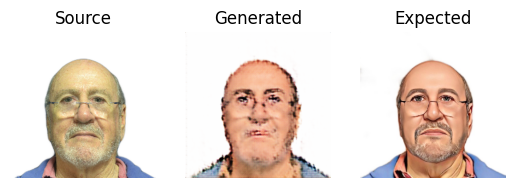

In [ ]:
from keras.models import load_model
from numpy.random import randint
from numpy import vstack
from matplotlib import pyplot


model = load_model('models (1)/model_latest.h5')


# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, 3, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # show title
        pyplot.title(titles[i])
    pyplot.show()


def preprocess_data(data):
        # load compressed arrays
        # unpack arrays
        X1, X2 = data[0], data[1]
        # scale from [0,255] to [-1,1]
        X1 = (X1 - 127.5) / 127.5
        X2 = (X2 - 127.5) / 127.5
        return [X1, X2]

src_images = np.load('src_images.npy')
tar_images = np.load('tar_images.npy')

src_images, tar_images = preprocess_data([src_images, tar_images])


# select random example
ix = randint(0, len(src_images), 1)
src_image, tar_image = src_images[ix], tar_images[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

1/1 [==============================] - 1s 656ms/step


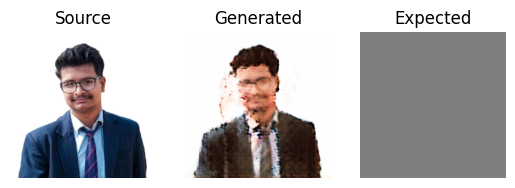

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# load image for directory
def load_image(filename, size=(256, 256)):
    # load image with the preferred size
    pixels = load_img(filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # scale from [0,255] to [-1,1]
    pixels = (pixels - 127.5) / 127.5
    # reshape to 1 sample
    pixels = np.expand_dims(pixels, 0)
    return pixels


src_image = load_image('test.jpg')

gen_image = model.predict(src_image)
# plot all three images
tar_image = np.zeros((1, 256, 256, 3))
plot_images(src_image, gen_image, tar_image)